# Variational AutoEncoder

## Trained on Kaggle

[The kaggle notebook can be accessed here.](https://www.kaggle.com/code/tarun42/vae-1)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [2]:
import os
import zipfile
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [3]:
# Load the CSV data
data = pd.read_csv('/kaggle/input/biomaterial-attachement/BacteriaA.csv')

### Matching the Image IDs to their respective Labels

In [4]:
# List all image IDs from the unzipped images
image_ids = [int(file.split('.')[0]) for file in os.listdir("/kaggle/input/biomaterial-attachement/ProcessedImages")]

# Convert image IDs to a DataFrame
image_ids_df = pd.DataFrame(image_ids, columns=['FeatID'])

# Merge with the ground truth data
merged_data = pd.merge(image_ids_df, data, how='inner', on='FeatID')

# Loading the Data

In [5]:
# A custom dataloader class to keep data transfomation consistent,
# it is also necessary due to multimodal data loading is required
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """# Initializer: Accepts a dataframe with data, 
        root directory of images, and transformations to be applied."""
        self.dataframe = dataframe
        self.root_dir = root_dir
        # Resizing all images to 200x200 pixels and then applying any additional transformations.
        self.transform = transforms.Compose([transforms.Resize((200, 200)), transform])

    def __len__(self):
        """Returns the number 
        of items in the dataset."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Fetches a single data item 
        (image and its ground truth) 
        given its index."""
        
        # Convert to list if the input is a tensor.
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, f"{img_id}.png")
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Getting the ground truth for the image from the dataframe.
        ground_truth = self.dataframe.iloc[idx, 1]
        ground_truth = torch.tensor(ground_truth).float()

        return image, ground_truth

# The VAE Model

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder Layers
        self.fc1 = nn.Linear(200*200*3+1, 400)  # Fully connected layer to reduce dimensionality
        self.bn1 = nn.BatchNorm1d(400)  # Batch normalization to stabilize learning and improve convergence
        self.fc21 = nn.Linear(400, 20)  # Fully connected layer for mean (mu) of latent space
        self.fc22 = nn.Linear(400, 20)  # Fully connected layer for log variance (logvar) of latent space

        # Decoder layers:
        self.fc3 = nn.Linear(20+1, 400)  # Fully connected layer to increase dimensionality
        self.bn2 = nn.BatchNorm1d(400)  # Batch normalization layer
        self.fc4 = nn.Linear(400, 200*200*3)  # Final fully connected layer to reconstruct the original data

    def encode(self, x):
        """Encodes the input data to the latent space representation (mu and logvar)."""
        h1 = F.relu(self.bn1(self.fc1(x)))  # Apply batch normalization after fc1
        return self.fc21(h1), self.fc22(h1) # Apply ReLU activation after fully connected layer

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: Generates a sample from Gaussian distribution defined by mu and logvar."""
        std = torch.exp(0.5*logvar)  # Standard deviation derived from log variance
        eps = torch.randn_like(std)  # Random noise (epsilon) with same shape as standard deviation
        return mu + eps*std  # Reparameterized sample

    def decode(self, z):
        """Decodes the given latent space representation back to original data space."""
        h3 = F.relu(self.bn2(self.fc3(z)))  # Apply ReLU activation after fully connected layer and batch normalization
        return torch.sigmoid(self.fc4(h3))  # Sigmoid activation to get values between 0 and 1 for final output

    def forward(self, x, ground_truth):
        """Forward pass of the VAE. Encodes input data to latent space and then decodes it."""
        # Encoding step: concatenate input data with ground truth before encoding
        mu, logvar = self.encode(torch.cat((x, ground_truth), dim=-1))
        # Reparameterization step: generate a sample from the latent space
        z = self.reparameterize(mu, logvar)
        # Decoding step: concatenate the latent sample with ground truth before decoding
        return self.decode(torch.cat((z, ground_truth), dim=-1)), mu, logvar

In [7]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
# Create the dataset
dataset = CustomDataset(merged_data, "/kaggle/input/biomaterial-attachement/ProcessedImages", transform=transform)

In [9]:
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
device = torch.device("cuda:0")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# Create the VAE
vae = VAE().to(device)

In [12]:
# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

### Difining Loss Function

In [13]:
def loss_function(recon_x, x, mu, logvar):
    """
    Compute the loss for a Variational Autoencoder (VAE).
    
    This function computes the sum of the reconstruction loss (BCE) and 
    the KL divergence loss, which together form the VAE's loss function.

    Parameters:
    - recon_x: The reconstructed data from the VAE's decoder.
    - x: The original input data.
    - mu: The mean of the latent Gaussian distribution.
    - logvar: The logarithm of the variance of the latent Gaussian distribution.

    Returns:
    - Total loss (BCE + KLD)
    """
#     print(recon_x.min(), recon_x.max())
    
    # Compute the Binary Cross Entropy loss (BCE) between the original data and the reconstructed data.
    # Reshape the original data to match the shape of recon_x.
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 200*200*3), reduction='sum')
    
    # Compute the KL Divergence loss (KLD). This loss measures how much the learned latent variable distribution
    # diverges from a standard normal distribution, which is the assumed prior distribution for the latent space in VAEs.
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Return the total loss, which is the sum of BCE and KLD.
    return BCE + KLD


In [31]:
import os
import sys
from contextlib import contextmanager

@contextmanager
def suppress_output():
    # Open a null stream to suppress output
    with open(os.devnull, 'w') as fnull:
        # Save the current stdout
        original_stdout = sys.stdout
        # Redirect stdout to the null stream
        sys.stdout = fnull
        yield
        # Restore stdout
        sys.stdout = original_stdout

In [32]:
def train(epoch):
    """
    Train the VAE model for one epoch.
    
    Parameters:
    - epoch: The current epoch number. Used for logging purposes.
    """
    
    # Set the VAE model to training mode. This enables features like dropout and batch normalization.
    vae.train()
    
    # Initialize a variable to keep track of the cumulative loss during the epoch.
    train_loss = 0
    
    # Use the suppress_output context manager to silence any verbose output (e.g., from PyTorch).
    with suppress_output():
        
        # Loop over each batch of data and ground truth from the dataloader.
        for batch_idx, (data, ground_truth) in enumerate(dataloader):
            
            # Reshape the data and move it to the desired device (e.g., GPU).
            data = data.view(data.size(0), -1).to(device)
            
            # Reshape the ground truth and move it to the desired device.
            ground_truth = ground_truth.view(ground_truth.size(0), -1).to(device)
            
            # Zero out any gradients in the optimizer, preparing it for a new optimization step.
            optimizer.zero_grad()
            
            # Forward pass: Pass the data through the VAE model to get the reconstructed batch, mu, and logvar.
            recon_batch, mu, logvar = vae(data, ground_truth)
            
            # Compute the loss for this batch using the loss function.
            loss = loss_function(recon_batch, data, mu, logvar)
            
            # Backward pass: Compute the gradients of the loss with respect to the model parameters.
            loss.backward()
            
            # Apply gradient clipping to prevent any unusually large gradients, which can lead to unstable training.
            nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1)
            
            # Update the cumulative training loss.
            train_loss += loss.item()
            
            # Perform an optimization step: Update the model's parameters based on the computed gradients.
            optimizer.step()

    # Print the epoch number for logging purposes.
    print('====> Epoch: {}'.format(epoch))


In [34]:
# Train the model
from tqdm import tqdm

num_epochs = 2000
for epoch in tqdm(range(1, num_epochs + 1), desc="Training"):
    train(epoch)

Training:   0%|          | 1/2000 [00:06<3:27:49,  6.24s/it]

====> Epoch: 1


Training:   0%|          | 2/2000 [00:12<3:28:58,  6.28s/it]

====> Epoch: 2


Training:   0%|          | 3/2000 [00:18<3:26:06,  6.19s/it]

====> Epoch: 3


Training:   0%|          | 4/2000 [00:24<3:24:43,  6.15s/it]

====> Epoch: 4


Training:   0%|          | 5/2000 [00:30<3:24:22,  6.15s/it]

====> Epoch: 5


Training:   0%|          | 6/2000 [00:37<3:27:14,  6.24s/it]

====> Epoch: 6


Training:   0%|          | 7/2000 [00:43<3:30:58,  6.35s/it]

====> Epoch: 7


Training:   0%|          | 8/2000 [00:49<3:28:05,  6.27s/it]

====> Epoch: 8


Training:   0%|          | 9/2000 [00:56<3:27:26,  6.25s/it]

====> Epoch: 9


Training:   0%|          | 10/2000 [01:02<3:24:55,  6.18s/it]

====> Epoch: 10


Training:   1%|          | 11/2000 [01:08<3:22:54,  6.12s/it]

====> Epoch: 11


Training:   1%|          | 12/2000 [01:14<3:25:58,  6.22s/it]

====> Epoch: 12


Training:   1%|          | 13/2000 [01:20<3:23:10,  6.13s/it]

====> Epoch: 13


Training:   1%|          | 14/2000 [01:26<3:23:35,  6.15s/it]

====> Epoch: 14


Training:   1%|          | 15/2000 [01:33<3:24:41,  6.19s/it]

====> Epoch: 15


Training:   1%|          | 16/2000 [01:39<3:23:21,  6.15s/it]

====> Epoch: 16


Training:   1%|          | 17/2000 [01:45<3:27:11,  6.27s/it]

====> Epoch: 17


Training:   1%|          | 18/2000 [01:51<3:25:16,  6.21s/it]

====> Epoch: 18


Training:   1%|          | 19/2000 [01:57<3:23:26,  6.16s/it]

====> Epoch: 19


Training:   1%|          | 20/2000 [02:03<3:21:03,  6.09s/it]

====> Epoch: 20


Training:   1%|          | 21/2000 [02:09<3:19:19,  6.04s/it]

====> Epoch: 21


Training:   1%|          | 22/2000 [02:15<3:22:08,  6.13s/it]

====> Epoch: 22


Training:   1%|          | 23/2000 [02:21<3:19:27,  6.05s/it]

====> Epoch: 23


Training:   1%|          | 24/2000 [02:27<3:20:22,  6.08s/it]

====> Epoch: 24


Training:   1%|▏         | 25/2000 [02:34<3:21:17,  6.11s/it]

====> Epoch: 25


Training:   1%|▏         | 26/2000 [02:40<3:22:30,  6.16s/it]

====> Epoch: 26


Training:   1%|▏         | 27/2000 [02:46<3:24:36,  6.22s/it]

====> Epoch: 27


Training:   1%|▏         | 28/2000 [02:52<3:22:23,  6.16s/it]

====> Epoch: 28


Training:   1%|▏         | 29/2000 [02:58<3:20:36,  6.11s/it]

====> Epoch: 29


Training:   2%|▏         | 30/2000 [03:04<3:18:51,  6.06s/it]

====> Epoch: 30


Training:   2%|▏         | 31/2000 [03:10<3:18:10,  6.04s/it]

====> Epoch: 31


Training:   2%|▏         | 32/2000 [03:17<3:20:28,  6.11s/it]

====> Epoch: 32


Training:   2%|▏         | 33/2000 [03:22<3:17:48,  6.03s/it]

====> Epoch: 33


Training:   2%|▏         | 34/2000 [03:28<3:17:07,  6.02s/it]

====> Epoch: 34


Training:   2%|▏         | 35/2000 [03:34<3:17:41,  6.04s/it]

====> Epoch: 35


Training:   2%|▏         | 36/2000 [03:40<3:18:02,  6.05s/it]

====> Epoch: 36


Training:   2%|▏         | 37/2000 [03:47<3:19:49,  6.11s/it]

====> Epoch: 37


Training:   2%|▏         | 38/2000 [03:53<3:19:28,  6.10s/it]

====> Epoch: 38


Training:   2%|▏         | 39/2000 [03:59<3:23:32,  6.23s/it]

====> Epoch: 39


Training:   2%|▏         | 40/2000 [04:06<3:27:45,  6.36s/it]

====> Epoch: 40


Training:   2%|▏         | 41/2000 [04:13<3:29:17,  6.41s/it]

====> Epoch: 41


Training:   2%|▏         | 42/2000 [04:19<3:34:04,  6.56s/it]

====> Epoch: 42


Training:   2%|▏         | 43/2000 [04:26<3:29:22,  6.42s/it]

====> Epoch: 43


Training:   2%|▏         | 44/2000 [04:32<3:25:59,  6.32s/it]

====> Epoch: 44


Training:   2%|▏         | 45/2000 [04:38<3:25:07,  6.30s/it]

====> Epoch: 45


Training:   2%|▏         | 46/2000 [04:44<3:22:57,  6.23s/it]

====> Epoch: 46


Training:   2%|▏         | 47/2000 [04:50<3:25:45,  6.32s/it]

====> Epoch: 47


Training:   2%|▏         | 48/2000 [04:57<3:24:47,  6.29s/it]

====> Epoch: 48


Training:   2%|▏         | 49/2000 [05:03<3:20:55,  6.18s/it]

====> Epoch: 49


Training:   2%|▎         | 50/2000 [05:09<3:19:31,  6.14s/it]

====> Epoch: 50


Training:   3%|▎         | 51/2000 [05:15<3:18:07,  6.10s/it]

====> Epoch: 51


Training:   3%|▎         | 52/2000 [05:21<3:19:06,  6.13s/it]

====> Epoch: 52


Training:   3%|▎         | 53/2000 [05:27<3:21:34,  6.21s/it]

====> Epoch: 53


Training:   3%|▎         | 54/2000 [05:34<3:21:43,  6.22s/it]

====> Epoch: 54


Training:   3%|▎         | 55/2000 [05:40<3:22:13,  6.24s/it]

====> Epoch: 55


Training:   3%|▎         | 56/2000 [05:46<3:21:32,  6.22s/it]

====> Epoch: 56


Training:   3%|▎         | 57/2000 [05:52<3:22:12,  6.24s/it]

====> Epoch: 57


Training:   3%|▎         | 58/2000 [05:59<3:23:03,  6.27s/it]

====> Epoch: 58


Training:   3%|▎         | 59/2000 [06:05<3:21:29,  6.23s/it]

====> Epoch: 59


Training:   3%|▎         | 60/2000 [06:11<3:20:05,  6.19s/it]

====> Epoch: 60


Training:   3%|▎         | 61/2000 [06:17<3:18:11,  6.13s/it]

====> Epoch: 61


Training:   3%|▎         | 62/2000 [06:23<3:17:18,  6.11s/it]

====> Epoch: 62


Training:   3%|▎         | 63/2000 [06:30<3:22:17,  6.27s/it]

====> Epoch: 63


Training:   3%|▎         | 64/2000 [06:36<3:23:00,  6.29s/it]

====> Epoch: 64


Training:   3%|▎         | 65/2000 [06:42<3:21:20,  6.24s/it]

====> Epoch: 65


Training:   3%|▎         | 66/2000 [06:48<3:20:38,  6.22s/it]

====> Epoch: 66


Training:   3%|▎         | 67/2000 [06:54<3:20:11,  6.21s/it]

====> Epoch: 67


Training:   3%|▎         | 68/2000 [07:01<3:22:11,  6.28s/it]

====> Epoch: 68


Training:   3%|▎         | 69/2000 [07:07<3:19:22,  6.20s/it]

====> Epoch: 69


Training:   4%|▎         | 70/2000 [07:13<3:18:22,  6.17s/it]

====> Epoch: 70


Training:   4%|▎         | 71/2000 [07:19<3:15:59,  6.10s/it]

====> Epoch: 71


Training:   4%|▎         | 72/2000 [07:25<3:17:19,  6.14s/it]

====> Epoch: 72


Training:   4%|▎         | 73/2000 [07:31<3:19:19,  6.21s/it]

====> Epoch: 73


Training:   4%|▎         | 74/2000 [07:38<3:19:49,  6.22s/it]

====> Epoch: 74


Training:   4%|▍         | 75/2000 [07:44<3:19:19,  6.21s/it]

====> Epoch: 75


Training:   4%|▍         | 76/2000 [07:50<3:18:05,  6.18s/it]

====> Epoch: 76


Training:   4%|▍         | 77/2000 [07:56<3:16:26,  6.13s/it]

====> Epoch: 77


Training:   4%|▍         | 78/2000 [08:02<3:18:23,  6.19s/it]

====> Epoch: 78


Training:   4%|▍         | 79/2000 [08:08<3:17:10,  6.16s/it]

====> Epoch: 79


Training:   4%|▍         | 80/2000 [08:14<3:14:29,  6.08s/it]

====> Epoch: 80


Training:   4%|▍         | 81/2000 [08:20<3:13:45,  6.06s/it]

====> Epoch: 81


Training:   4%|▍         | 82/2000 [08:26<3:14:36,  6.09s/it]

====> Epoch: 82


Training:   4%|▍         | 83/2000 [08:33<3:18:17,  6.21s/it]

====> Epoch: 83


Training:   4%|▍         | 84/2000 [08:39<3:17:20,  6.18s/it]

====> Epoch: 84


Training:   4%|▍         | 85/2000 [08:45<3:16:51,  6.17s/it]

====> Epoch: 85


Training:   4%|▍         | 86/2000 [08:51<3:15:32,  6.13s/it]

====> Epoch: 86


Training:   4%|▍         | 87/2000 [08:57<3:14:51,  6.11s/it]

====> Epoch: 87


Training:   4%|▍         | 88/2000 [09:04<3:16:18,  6.16s/it]

====> Epoch: 88


Training:   4%|▍         | 89/2000 [09:10<3:15:05,  6.13s/it]

====> Epoch: 89


Training:   4%|▍         | 90/2000 [09:16<3:13:07,  6.07s/it]

====> Epoch: 90


Training:   5%|▍         | 91/2000 [09:21<3:11:02,  6.00s/it]

====> Epoch: 91


Training:   5%|▍         | 92/2000 [09:28<3:12:39,  6.06s/it]

====> Epoch: 92


Training:   5%|▍         | 93/2000 [09:34<3:17:15,  6.21s/it]

====> Epoch: 93


Training:   5%|▍         | 94/2000 [09:40<3:18:01,  6.23s/it]

====> Epoch: 94


Training:   5%|▍         | 95/2000 [09:47<3:16:45,  6.20s/it]

====> Epoch: 95


Training:   5%|▍         | 96/2000 [09:53<3:15:56,  6.17s/it]

====> Epoch: 96


Training:   5%|▍         | 97/2000 [09:59<3:13:35,  6.10s/it]

====> Epoch: 97


Training:   5%|▍         | 98/2000 [10:05<3:12:16,  6.07s/it]

====> Epoch: 98


Training:   5%|▍         | 99/2000 [10:11<3:16:20,  6.20s/it]

====> Epoch: 99


Training:   5%|▌         | 100/2000 [10:17<3:13:34,  6.11s/it]

====> Epoch: 100


Training:   5%|▌         | 101/2000 [10:23<3:11:36,  6.05s/it]

====> Epoch: 101


Training:   5%|▌         | 102/2000 [10:29<3:13:09,  6.11s/it]

====> Epoch: 102


Training:   5%|▌         | 103/2000 [10:35<3:14:47,  6.16s/it]

====> Epoch: 103


Training:   5%|▌         | 104/2000 [10:42<3:16:04,  6.20s/it]

====> Epoch: 104


Training:   5%|▌         | 105/2000 [10:48<3:14:00,  6.14s/it]

====> Epoch: 105


Training:   5%|▌         | 106/2000 [10:54<3:13:24,  6.13s/it]

====> Epoch: 106


Training:   5%|▌         | 107/2000 [11:00<3:14:17,  6.16s/it]

====> Epoch: 107


Training:   5%|▌         | 108/2000 [11:06<3:14:59,  6.18s/it]

====> Epoch: 108


Training:   5%|▌         | 109/2000 [11:13<3:17:33,  6.27s/it]

====> Epoch: 109


Training:   6%|▌         | 110/2000 [11:19<3:15:43,  6.21s/it]

====> Epoch: 110


Training:   6%|▌         | 111/2000 [11:25<3:15:33,  6.21s/it]

====> Epoch: 111


Training:   6%|▌         | 112/2000 [11:31<3:15:20,  6.21s/it]

====> Epoch: 112


Training:   6%|▌         | 113/2000 [11:38<3:15:51,  6.23s/it]

====> Epoch: 113


Training:   6%|▌         | 114/2000 [11:44<3:16:49,  6.26s/it]

====> Epoch: 114


Training:   6%|▌         | 115/2000 [11:50<3:15:12,  6.21s/it]

====> Epoch: 115


Training:   6%|▌         | 116/2000 [11:56<3:14:25,  6.19s/it]

====> Epoch: 116


Training:   6%|▌         | 117/2000 [12:02<3:11:29,  6.10s/it]

====> Epoch: 117


Training:   6%|▌         | 118/2000 [12:08<3:11:49,  6.12s/it]

====> Epoch: 118


Training:   6%|▌         | 119/2000 [12:15<3:15:01,  6.22s/it]

====> Epoch: 119


Training:   6%|▌         | 120/2000 [12:21<3:11:53,  6.12s/it]

====> Epoch: 120


Training:   6%|▌         | 121/2000 [12:27<3:11:56,  6.13s/it]

====> Epoch: 121


Training:   6%|▌         | 122/2000 [12:33<3:11:56,  6.13s/it]

====> Epoch: 122


Training:   6%|▌         | 123/2000 [12:39<3:12:53,  6.17s/it]

====> Epoch: 123


Training:   6%|▌         | 124/2000 [12:46<3:15:21,  6.25s/it]

====> Epoch: 124


Training:   6%|▋         | 125/2000 [12:52<3:13:42,  6.20s/it]

====> Epoch: 125


Training:   6%|▋         | 126/2000 [12:57<3:10:14,  6.09s/it]

====> Epoch: 126


Training:   6%|▋         | 127/2000 [13:03<3:08:01,  6.02s/it]

====> Epoch: 127


Training:   6%|▋         | 128/2000 [13:09<3:07:46,  6.02s/it]

====> Epoch: 128


Training:   6%|▋         | 129/2000 [13:16<3:10:20,  6.10s/it]

====> Epoch: 129


Training:   6%|▋         | 130/2000 [13:22<3:09:35,  6.08s/it]

====> Epoch: 130


Training:   7%|▋         | 131/2000 [13:28<3:10:14,  6.11s/it]

====> Epoch: 131


Training:   7%|▋         | 132/2000 [13:34<3:11:10,  6.14s/it]

====> Epoch: 132


Training:   7%|▋         | 133/2000 [13:40<3:11:50,  6.17s/it]

====> Epoch: 133


Training:   7%|▋         | 134/2000 [13:47<3:13:22,  6.22s/it]

====> Epoch: 134


Training:   7%|▋         | 135/2000 [13:53<3:12:53,  6.21s/it]

====> Epoch: 135


Training:   7%|▋         | 136/2000 [13:59<3:10:40,  6.14s/it]

====> Epoch: 136


Training:   7%|▋         | 137/2000 [14:05<3:08:36,  6.07s/it]

====> Epoch: 137


Training:   7%|▋         | 138/2000 [14:11<3:07:24,  6.04s/it]

====> Epoch: 138


Training:   7%|▋         | 139/2000 [14:17<3:06:16,  6.01s/it]

====> Epoch: 139


Training:   7%|▋         | 140/2000 [14:23<3:09:04,  6.10s/it]

====> Epoch: 140


Training:   7%|▋         | 141/2000 [14:29<3:09:30,  6.12s/it]

====> Epoch: 141


Training:   7%|▋         | 142/2000 [14:35<3:09:51,  6.13s/it]

====> Epoch: 142


Training:   7%|▋         | 143/2000 [14:41<3:09:50,  6.13s/it]

====> Epoch: 143


Training:   7%|▋         | 144/2000 [14:47<3:09:00,  6.11s/it]

====> Epoch: 144


Training:   7%|▋         | 145/2000 [14:54<3:11:04,  6.18s/it]

====> Epoch: 145


Training:   7%|▋         | 146/2000 [15:00<3:08:56,  6.11s/it]

====> Epoch: 146


Training:   7%|▋         | 147/2000 [15:06<3:06:57,  6.05s/it]

====> Epoch: 147


Training:   7%|▋         | 148/2000 [15:12<3:06:23,  6.04s/it]

====> Epoch: 148


Training:   7%|▋         | 149/2000 [15:18<3:05:33,  6.01s/it]

====> Epoch: 149


Training:   8%|▊         | 150/2000 [15:24<3:08:51,  6.13s/it]

====> Epoch: 150


Training:   8%|▊         | 151/2000 [15:30<3:09:28,  6.15s/it]

====> Epoch: 151


Training:   8%|▊         | 152/2000 [15:36<3:10:11,  6.17s/it]

====> Epoch: 152


Training:   8%|▊         | 153/2000 [15:43<3:11:58,  6.24s/it]

====> Epoch: 153


Training:   8%|▊         | 154/2000 [15:49<3:12:10,  6.25s/it]

====> Epoch: 154


Training:   8%|▊         | 155/2000 [15:56<3:14:29,  6.32s/it]

====> Epoch: 155


Training:   8%|▊         | 156/2000 [16:02<3:11:49,  6.24s/it]

====> Epoch: 156


Training:   8%|▊         | 157/2000 [16:08<3:10:03,  6.19s/it]

====> Epoch: 157


Training:   8%|▊         | 158/2000 [16:14<3:09:49,  6.18s/it]

====> Epoch: 158


Training:   8%|▊         | 159/2000 [16:20<3:09:18,  6.17s/it]

====> Epoch: 159


Training:   8%|▊         | 160/2000 [16:27<3:13:40,  6.32s/it]

====> Epoch: 160


Training:   8%|▊         | 161/2000 [16:33<3:11:41,  6.25s/it]

====> Epoch: 161


Training:   8%|▊         | 162/2000 [16:39<3:12:12,  6.27s/it]

====> Epoch: 162


Training:   8%|▊         | 163/2000 [16:46<3:13:51,  6.33s/it]

====> Epoch: 163


Training:   8%|▊         | 164/2000 [16:52<3:13:06,  6.31s/it]

====> Epoch: 164


Training:   8%|▊         | 165/2000 [16:58<3:13:13,  6.32s/it]

====> Epoch: 165


Training:   8%|▊         | 166/2000 [17:04<3:10:07,  6.22s/it]

====> Epoch: 166


Training:   8%|▊         | 167/2000 [17:10<3:10:07,  6.22s/it]

====> Epoch: 167


Training:   8%|▊         | 168/2000 [17:16<3:07:30,  6.14s/it]

====> Epoch: 168


Training:   8%|▊         | 169/2000 [17:22<3:06:39,  6.12s/it]

====> Epoch: 169


Training:   8%|▊         | 170/2000 [17:29<3:11:20,  6.27s/it]

====> Epoch: 170


Training:   9%|▊         | 171/2000 [17:35<3:12:13,  6.31s/it]

====> Epoch: 171


Training:   9%|▊         | 172/2000 [17:42<3:11:38,  6.29s/it]

====> Epoch: 172


Training:   9%|▊         | 173/2000 [17:48<3:09:09,  6.21s/it]

====> Epoch: 173


Training:   9%|▊         | 174/2000 [17:54<3:07:15,  6.15s/it]

====> Epoch: 174


Training:   9%|▉         | 175/2000 [18:00<3:09:51,  6.24s/it]

====> Epoch: 175


Training:   9%|▉         | 176/2000 [18:06<3:10:04,  6.25s/it]

====> Epoch: 176


Training:   9%|▉         | 177/2000 [18:12<3:07:36,  6.17s/it]

====> Epoch: 177


Training:   9%|▉         | 178/2000 [18:18<3:06:30,  6.14s/it]

====> Epoch: 178


Training:   9%|▉         | 179/2000 [18:25<3:10:37,  6.28s/it]

====> Epoch: 179


Training:   9%|▉         | 180/2000 [18:32<3:12:19,  6.34s/it]

====> Epoch: 180


Training:   9%|▉         | 181/2000 [18:38<3:10:34,  6.29s/it]

====> Epoch: 181


Training:   9%|▉         | 182/2000 [18:44<3:10:25,  6.28s/it]

====> Epoch: 182


Training:   9%|▉         | 183/2000 [18:50<3:08:47,  6.23s/it]

====> Epoch: 183


Training:   9%|▉         | 184/2000 [18:56<3:06:58,  6.18s/it]

====> Epoch: 184


Training:   9%|▉         | 185/2000 [19:02<3:06:40,  6.17s/it]

====> Epoch: 185


Training:   9%|▉         | 186/2000 [19:08<3:05:32,  6.14s/it]

====> Epoch: 186


Training:   9%|▉         | 187/2000 [19:14<3:04:05,  6.09s/it]

====> Epoch: 187


Training:   9%|▉         | 188/2000 [19:20<3:04:06,  6.10s/it]

====> Epoch: 188


Training:   9%|▉         | 189/2000 [19:27<3:04:10,  6.10s/it]

====> Epoch: 189


Training:  10%|▉         | 190/2000 [19:33<3:05:40,  6.16s/it]

====> Epoch: 190


Training:  10%|▉         | 191/2000 [19:39<3:08:31,  6.25s/it]

====> Epoch: 191


Training:  10%|▉         | 192/2000 [19:45<3:07:23,  6.22s/it]

====> Epoch: 192


Training:  10%|▉         | 193/2000 [19:52<3:05:50,  6.17s/it]

====> Epoch: 193


Training:  10%|▉         | 194/2000 [19:57<3:03:12,  6.09s/it]

====> Epoch: 194


Training:  10%|▉         | 195/2000 [20:03<3:02:07,  6.05s/it]

====> Epoch: 195


Training:  10%|▉         | 196/2000 [20:10<3:04:26,  6.13s/it]

====> Epoch: 196


Training:  10%|▉         | 197/2000 [20:16<3:03:33,  6.11s/it]

====> Epoch: 197


Training:  10%|▉         | 198/2000 [20:22<3:01:40,  6.05s/it]

====> Epoch: 198


Training:  10%|▉         | 199/2000 [20:28<3:03:11,  6.10s/it]

====> Epoch: 199


Training:  10%|█         | 200/2000 [20:35<3:12:51,  6.43s/it]

====> Epoch: 200


Training:  10%|█         | 201/2000 [20:42<3:14:03,  6.47s/it]

====> Epoch: 201


Training:  10%|█         | 202/2000 [20:48<3:12:44,  6.43s/it]

====> Epoch: 202


Training:  10%|█         | 203/2000 [20:55<3:17:42,  6.60s/it]

====> Epoch: 203


Training:  10%|█         | 204/2000 [21:02<3:19:37,  6.67s/it]

====> Epoch: 204


Training:  10%|█         | 205/2000 [21:09<3:24:38,  6.84s/it]

====> Epoch: 205


Training:  10%|█         | 206/2000 [21:15<3:19:04,  6.66s/it]

====> Epoch: 206


Training:  10%|█         | 207/2000 [21:22<3:15:22,  6.54s/it]

====> Epoch: 207


Training:  10%|█         | 208/2000 [21:28<3:12:37,  6.45s/it]

====> Epoch: 208


Training:  10%|█         | 209/2000 [21:34<3:10:47,  6.39s/it]

====> Epoch: 209


Training:  11%|█▏        | 225/2000 [23:11<2:58:55,  6.05s/it]

====> Epoch: 225


Training:  11%|█▏        | 226/2000 [23:18<3:01:09,  6.13s/it]

====> Epoch: 226


Training:  11%|█▏        | 227/2000 [23:24<2:59:57,  6.09s/it]

====> Epoch: 227


Training:  11%|█▏        | 228/2000 [23:30<3:00:36,  6.12s/it]

====> Epoch: 228


Training:  11%|█▏        | 229/2000 [23:36<3:00:23,  6.11s/it]

====> Epoch: 229


Training:  12%|█▏        | 230/2000 [23:42<3:01:39,  6.16s/it]

====> Epoch: 230


Training:  12%|█▏        | 231/2000 [23:49<3:03:41,  6.23s/it]

====> Epoch: 231


Training:  12%|█▏        | 232/2000 [23:55<3:01:02,  6.14s/it]

====> Epoch: 232


Training:  12%|█▏        | 233/2000 [24:01<2:58:31,  6.06s/it]

====> Epoch: 233


Training:  12%|█▏        | 234/2000 [24:07<2:57:32,  6.03s/it]

====> Epoch: 234


Training:  12%|█▏        | 235/2000 [24:12<2:55:44,  5.97s/it]

====> Epoch: 235


Training:  12%|█▏        | 236/2000 [24:19<2:58:16,  6.06s/it]

====> Epoch: 236


Training:  12%|█▏        | 237/2000 [24:25<2:57:56,  6.06s/it]

====> Epoch: 237


Training:  12%|█▏        | 238/2000 [24:31<2:56:35,  6.01s/it]

====> Epoch: 238


Training:  12%|█▏        | 239/2000 [24:37<2:56:32,  6.02s/it]

====> Epoch: 239


Training:  12%|█▏        | 240/2000 [24:43<2:57:32,  6.05s/it]

====> Epoch: 240


Training:  12%|█▏        | 241/2000 [24:49<2:59:13,  6.11s/it]

====> Epoch: 241


Training:  12%|█▏        | 242/2000 [24:55<2:59:08,  6.11s/it]

====> Epoch: 242


Training:  12%|█▏        | 243/2000 [25:01<2:56:43,  6.03s/it]

====> Epoch: 243


Training:  12%|█▏        | 244/2000 [25:07<2:56:09,  6.02s/it]

====> Epoch: 244


Training:  12%|█▏        | 245/2000 [25:13<2:56:46,  6.04s/it]

====> Epoch: 245


Training:  12%|█▏        | 246/2000 [25:19<2:56:08,  6.03s/it]

====> Epoch: 246


Training:  12%|█▏        | 247/2000 [25:25<2:59:24,  6.14s/it]

====> Epoch: 247


Training:  12%|█▏        | 248/2000 [25:31<2:58:30,  6.11s/it]

====> Epoch: 248


Training:  12%|█▏        | 249/2000 [25:38<2:57:45,  6.09s/it]

====> Epoch: 249


Training:  12%|█▎        | 250/2000 [25:44<2:57:52,  6.10s/it]

====> Epoch: 250


Training:  13%|█▎        | 251/2000 [25:50<2:56:21,  6.05s/it]

====> Epoch: 251


Training:  13%|█▎        | 252/2000 [25:56<2:57:33,  6.09s/it]

====> Epoch: 252


Training:  13%|█▎        | 253/2000 [26:02<2:55:08,  6.02s/it]

====> Epoch: 253


Training:  13%|█▎        | 254/2000 [26:08<2:54:18,  5.99s/it]

====> Epoch: 254


Training:  13%|█▎        | 255/2000 [26:13<2:53:27,  5.96s/it]

====> Epoch: 255


Training:  13%|█▎        | 256/2000 [26:19<2:52:36,  5.94s/it]

====> Epoch: 256


Training:  13%|█▎        | 257/2000 [26:26<2:55:50,  6.05s/it]

====> Epoch: 257


Training:  13%|█▎        | 258/2000 [26:32<2:55:46,  6.05s/it]

====> Epoch: 258


Training:  13%|█▎        | 259/2000 [26:38<2:55:53,  6.06s/it]

====> Epoch: 259


Training:  13%|█▎        | 260/2000 [26:44<2:55:42,  6.06s/it]

====> Epoch: 260


Training:  13%|█▎        | 261/2000 [26:50<2:55:33,  6.06s/it]

====> Epoch: 261


Training:  13%|█▎        | 262/2000 [26:56<2:57:25,  6.12s/it]

====> Epoch: 262


Training:  13%|█▎        | 263/2000 [27:02<2:54:39,  6.03s/it]

====> Epoch: 263


Training:  13%|█▎        | 264/2000 [27:08<2:53:39,  6.00s/it]

====> Epoch: 264


Training:  13%|█▎        | 265/2000 [27:14<2:53:07,  5.99s/it]

====> Epoch: 265


Training:  13%|█▎        | 266/2000 [27:20<2:53:03,  5.99s/it]

====> Epoch: 266


Training:  14%|█▍        | 281/2000 [28:54<2:58:33,  6.23s/it]

====> Epoch: 281


Training:  14%|█▍        | 282/2000 [29:01<2:57:15,  6.19s/it]

====> Epoch: 282


Training:  14%|█▍        | 283/2000 [29:07<2:58:49,  6.25s/it]

====> Epoch: 283


Training:  14%|█▍        | 284/2000 [29:13<2:56:03,  6.16s/it]

====> Epoch: 284


Training:  14%|█▍        | 285/2000 [29:19<2:54:23,  6.10s/it]

====> Epoch: 285


Training:  14%|█▍        | 286/2000 [29:25<2:56:03,  6.16s/it]

====> Epoch: 286


Training:  14%|█▍        | 287/2000 [29:31<2:55:27,  6.15s/it]

====> Epoch: 287


Training:  14%|█▍        | 288/2000 [29:38<2:58:28,  6.26s/it]

====> Epoch: 288


Training:  14%|█▍        | 289/2000 [29:44<2:59:36,  6.30s/it]

====> Epoch: 289


Training:  14%|█▍        | 290/2000 [29:50<2:58:41,  6.27s/it]

====> Epoch: 290


Training:  15%|█▍        | 291/2000 [29:57<2:58:00,  6.25s/it]

====> Epoch: 291


Training:  15%|█▍        | 292/2000 [30:03<2:54:57,  6.15s/it]

====> Epoch: 292


Training:  15%|█▍        | 293/2000 [30:09<2:56:44,  6.21s/it]

====> Epoch: 293


Training:  15%|█▍        | 294/2000 [30:15<2:54:41,  6.14s/it]

====> Epoch: 294


Training:  15%|█▍        | 295/2000 [30:21<2:53:21,  6.10s/it]

====> Epoch: 295


Training:  15%|█▍        | 296/2000 [30:27<2:54:39,  6.15s/it]

====> Epoch: 296


Training:  15%|█▍        | 297/2000 [30:33<2:53:57,  6.13s/it]

====> Epoch: 297


Training:  15%|█▍        | 298/2000 [30:40<2:58:18,  6.29s/it]

====> Epoch: 298


Training:  15%|█▍        | 299/2000 [30:46<2:55:13,  6.18s/it]

====> Epoch: 299


Training:  15%|█▌        | 300/2000 [30:52<2:54:05,  6.14s/it]

====> Epoch: 300


Training:  15%|█▌        | 301/2000 [30:58<2:52:11,  6.08s/it]

====> Epoch: 301


Training:  15%|█▌        | 302/2000 [31:04<2:50:42,  6.03s/it]

====> Epoch: 302


Training:  15%|█▌        | 303/2000 [31:10<2:51:57,  6.08s/it]

====> Epoch: 303


Training:  15%|█▌        | 304/2000 [31:16<2:49:37,  6.00s/it]

====> Epoch: 304


Training:  15%|█▌        | 305/2000 [31:22<2:47:58,  5.95s/it]

====> Epoch: 305


Training:  15%|█▌        | 306/2000 [31:28<2:48:40,  5.97s/it]

====> Epoch: 306


Training:  15%|█▌        | 307/2000 [31:34<2:48:44,  5.98s/it]

====> Epoch: 307


Training:  15%|█▌        | 308/2000 [31:40<2:52:42,  6.12s/it]

====> Epoch: 308


Training:  15%|█▌        | 309/2000 [31:46<2:52:16,  6.11s/it]

====> Epoch: 309


Training:  16%|█▌        | 310/2000 [31:52<2:52:02,  6.11s/it]

====> Epoch: 310


Training:  16%|█▌        | 311/2000 [31:58<2:51:36,  6.10s/it]

====> Epoch: 311


Training:  16%|█▌        | 312/2000 [32:04<2:49:04,  6.01s/it]

====> Epoch: 312


Training:  16%|█▌        | 313/2000 [32:10<2:48:26,  5.99s/it]

====> Epoch: 313


Training:  16%|█▌        | 314/2000 [32:16<2:50:09,  6.06s/it]

====> Epoch: 314


Training:  16%|█▌        | 315/2000 [32:22<2:48:26,  6.00s/it]

====> Epoch: 315


Training:  16%|█▌        | 316/2000 [32:28<2:48:14,  5.99s/it]

====> Epoch: 316


Training:  16%|█▌        | 317/2000 [32:34<2:48:40,  6.01s/it]

====> Epoch: 317


Training:  16%|█▌        | 318/2000 [32:40<2:50:13,  6.07s/it]

====> Epoch: 318


Training:  16%|█▌        | 319/2000 [32:47<2:51:35,  6.12s/it]

====> Epoch: 319


Training:  16%|█▌        | 320/2000 [32:52<2:49:16,  6.05s/it]

====> Epoch: 320


Training:  16%|█▌        | 321/2000 [32:58<2:48:14,  6.01s/it]

====> Epoch: 321


Training:  16%|█▌        | 322/2000 [33:04<2:46:38,  5.96s/it]

====> Epoch: 322


Training:  17%|█▋        | 338/2000 [34:41<2:49:07,  6.11s/it]

====> Epoch: 338


Training:  17%|█▋        | 339/2000 [34:47<2:48:02,  6.07s/it]

====> Epoch: 339


Training:  17%|█▋        | 340/2000 [34:53<2:49:00,  6.11s/it]

====> Epoch: 340


Training:  17%|█▋        | 341/2000 [34:59<2:47:43,  6.07s/it]

====> Epoch: 341


Training:  17%|█▋        | 342/2000 [35:05<2:46:53,  6.04s/it]

====> Epoch: 342


Training:  17%|█▋        | 343/2000 [35:11<2:44:38,  5.96s/it]

====> Epoch: 343


Training:  17%|█▋        | 344/2000 [35:17<2:42:49,  5.90s/it]

====> Epoch: 344


Training:  17%|█▋        | 345/2000 [35:23<2:44:21,  5.96s/it]

====> Epoch: 345


Training:  17%|█▋        | 346/2000 [35:29<2:44:42,  5.97s/it]

====> Epoch: 346


Training:  17%|█▋        | 347/2000 [35:35<2:44:16,  5.96s/it]

====> Epoch: 347


Training:  17%|█▋        | 348/2000 [35:41<2:45:13,  6.00s/it]

====> Epoch: 348


Training:  17%|█▋        | 349/2000 [35:47<2:45:13,  6.00s/it]

====> Epoch: 349


Training:  18%|█▊        | 350/2000 [35:53<2:46:39,  6.06s/it]

====> Epoch: 350


Training:  18%|█▊        | 351/2000 [35:59<2:44:05,  5.97s/it]

====> Epoch: 351


Training:  18%|█▊        | 352/2000 [36:05<2:42:02,  5.90s/it]

====> Epoch: 352


Training:  18%|█▊        | 353/2000 [36:10<2:41:35,  5.89s/it]

====> Epoch: 353


Training:  18%|█▊        | 354/2000 [36:16<2:40:38,  5.86s/it]

====> Epoch: 354


Training:  18%|█▊        | 355/2000 [36:22<2:39:46,  5.83s/it]

====> Epoch: 355


Training:  18%|█▊        | 356/2000 [36:28<2:43:30,  5.97s/it]

====> Epoch: 356


Training:  18%|█▊        | 357/2000 [36:34<2:43:14,  5.96s/it]

====> Epoch: 357


Training:  18%|█▊        | 358/2000 [36:40<2:45:20,  6.04s/it]

====> Epoch: 358


Training:  18%|█▊        | 359/2000 [36:46<2:44:34,  6.02s/it]

====> Epoch: 359


Training:  18%|█▊        | 360/2000 [36:52<2:44:13,  6.01s/it]

====> Epoch: 360


Training:  18%|█▊        | 361/2000 [36:59<2:46:46,  6.10s/it]

====> Epoch: 361


Training:  18%|█▊        | 362/2000 [37:05<2:43:53,  6.00s/it]

====> Epoch: 362


Training:  18%|█▊        | 363/2000 [37:11<2:43:33,  5.99s/it]

====> Epoch: 363


Training:  18%|█▊        | 364/2000 [37:16<2:41:56,  5.94s/it]

====> Epoch: 364


Training:  18%|█▊        | 365/2000 [37:22<2:41:55,  5.94s/it]

====> Epoch: 365


Training:  18%|█▊        | 366/2000 [37:29<2:44:50,  6.05s/it]

====> Epoch: 366


Training:  18%|█▊        | 367/2000 [37:35<2:43:49,  6.02s/it]

====> Epoch: 367


Training:  18%|█▊        | 368/2000 [37:41<2:44:41,  6.05s/it]

====> Epoch: 368


Training:  18%|█▊        | 369/2000 [37:47<2:43:35,  6.02s/it]

====> Epoch: 369


Training:  18%|█▊        | 370/2000 [37:53<2:43:09,  6.01s/it]

====> Epoch: 370


Training:  19%|█▊        | 371/2000 [37:59<2:46:07,  6.12s/it]

====> Epoch: 371


Training:  19%|█▊        | 372/2000 [38:05<2:42:36,  5.99s/it]

====> Epoch: 372


Training:  19%|█▊        | 373/2000 [38:11<2:41:32,  5.96s/it]

====> Epoch: 373


Training:  19%|█▊        | 374/2000 [38:16<2:40:11,  5.91s/it]

====> Epoch: 374


Training:  19%|█▉        | 375/2000 [38:22<2:38:52,  5.87s/it]

====> Epoch: 375


Training:  19%|█▉        | 376/2000 [38:28<2:40:14,  5.92s/it]

====> Epoch: 376


Training:  19%|█▉        | 377/2000 [38:35<2:44:16,  6.07s/it]

====> Epoch: 377


Training:  19%|█▉        | 378/2000 [38:41<2:44:34,  6.09s/it]

====> Epoch: 378


Training:  19%|█▉        | 379/2000 [38:47<2:43:49,  6.06s/it]

====> Epoch: 379


Training:  19%|█▉        | 380/2000 [38:53<2:43:00,  6.04s/it]

====> Epoch: 380


Training:  19%|█▉        | 381/2000 [38:59<2:42:11,  6.01s/it]

====> Epoch: 381


Training:  19%|█▉        | 382/2000 [39:05<2:45:01,  6.12s/it]

====> Epoch: 382


Training:  19%|█▉        | 383/2000 [39:11<2:44:02,  6.09s/it]

====> Epoch: 383


Training:  19%|█▉        | 384/2000 [39:17<2:41:10,  5.98s/it]

====> Epoch: 384


Training:  19%|█▉        | 385/2000 [39:22<2:39:05,  5.91s/it]

====> Epoch: 385


Training:  19%|█▉        | 386/2000 [39:29<2:40:20,  5.96s/it]

====> Epoch: 386


Training:  19%|█▉        | 387/2000 [39:35<2:42:46,  6.06s/it]

====> Epoch: 387


Training:  19%|█▉        | 388/2000 [39:41<2:42:18,  6.04s/it]

====> Epoch: 388


Training:  19%|█▉        | 389/2000 [39:47<2:40:31,  5.98s/it]

====> Epoch: 389


Training:  20%|█▉        | 390/2000 [39:53<2:39:42,  5.95s/it]

====> Epoch: 390


Training:  20%|█▉        | 391/2000 [39:58<2:38:54,  5.93s/it]

====> Epoch: 391


Training:  20%|█▉        | 392/2000 [40:04<2:39:20,  5.95s/it]

====> Epoch: 392


Training:  20%|█▉        | 393/2000 [40:10<2:39:24,  5.95s/it]

====> Epoch: 393


Training:  20%|█▉        | 394/2000 [40:16<2:37:36,  5.89s/it]

====> Epoch: 394


Training:  20%|█▉        | 395/2000 [40:22<2:36:39,  5.86s/it]

====> Epoch: 395


Training:  20%|█▉        | 396/2000 [40:28<2:37:47,  5.90s/it]

====> Epoch: 396


Training:  20%|█▉        | 397/2000 [40:34<2:37:41,  5.90s/it]

====> Epoch: 397


Training:  20%|█▉        | 398/2000 [40:40<2:41:55,  6.06s/it]

====> Epoch: 398


Training:  20%|█▉        | 399/2000 [40:46<2:40:38,  6.02s/it]

====> Epoch: 399


Training:  20%|██        | 400/2000 [40:52<2:39:20,  5.98s/it]

====> Epoch: 400


Training:  20%|██        | 401/2000 [40:58<2:38:19,  5.94s/it]

====> Epoch: 401


Training:  20%|██        | 402/2000 [41:04<2:37:03,  5.90s/it]

====> Epoch: 402


Training:  20%|██        | 403/2000 [41:10<2:40:17,  6.02s/it]

====> Epoch: 403


Training:  20%|██        | 404/2000 [41:16<2:38:49,  5.97s/it]

====> Epoch: 404


Training:  20%|██        | 405/2000 [41:22<2:40:12,  6.03s/it]

====> Epoch: 405


Training:  20%|██        | 406/2000 [41:28<2:42:17,  6.11s/it]

====> Epoch: 406


Training:  20%|██        | 407/2000 [41:35<2:46:45,  6.28s/it]

====> Epoch: 407


Training:  20%|██        | 408/2000 [41:42<2:48:41,  6.36s/it]

====> Epoch: 408


Training:  20%|██        | 409/2000 [41:48<2:46:57,  6.30s/it]

====> Epoch: 409


Training:  20%|██        | 410/2000 [41:54<2:43:40,  6.18s/it]

====> Epoch: 410


Training:  21%|██        | 411/2000 [42:00<2:42:27,  6.13s/it]

====> Epoch: 411


Training:  21%|██        | 412/2000 [42:06<2:43:05,  6.16s/it]

====> Epoch: 412


Training:  21%|██        | 413/2000 [42:13<2:47:02,  6.32s/it]

====> Epoch: 413


Training:  21%|██        | 414/2000 [42:18<2:43:09,  6.17s/it]

====> Epoch: 414


Training:  21%|██        | 415/2000 [42:25<2:44:57,  6.24s/it]

====> Epoch: 415


Training:  21%|██        | 416/2000 [42:31<2:44:53,  6.25s/it]

====> Epoch: 416


Training:  21%|██        | 417/2000 [42:37<2:43:17,  6.19s/it]

====> Epoch: 417


Training:  21%|██        | 418/2000 [42:43<2:44:13,  6.23s/it]

====> Epoch: 418


Training:  21%|██        | 419/2000 [42:49<2:42:40,  6.17s/it]

====> Epoch: 419


Training:  21%|██        | 420/2000 [42:56<2:42:37,  6.18s/it]

====> Epoch: 420


Training:  21%|██        | 421/2000 [43:02<2:42:50,  6.19s/it]

====> Epoch: 421


Training:  21%|██        | 422/2000 [43:08<2:42:26,  6.18s/it]

====> Epoch: 422


Training:  21%|██        | 423/2000 [43:14<2:41:31,  6.15s/it]

====> Epoch: 423


Training:  21%|██        | 424/2000 [43:20<2:40:13,  6.10s/it]

====> Epoch: 424


Training:  21%|██▏       | 425/2000 [43:26<2:39:08,  6.06s/it]

====> Epoch: 425


Training:  21%|██▏       | 426/2000 [43:32<2:38:40,  6.05s/it]

====> Epoch: 426


Training:  21%|██▏       | 427/2000 [43:38<2:40:57,  6.14s/it]

====> Epoch: 427


Training:  21%|██▏       | 428/2000 [43:45<2:42:29,  6.20s/it]

====> Epoch: 428


Training:  21%|██▏       | 429/2000 [43:51<2:43:01,  6.23s/it]

====> Epoch: 429


Training:  22%|██▏       | 430/2000 [43:57<2:41:07,  6.16s/it]

====> Epoch: 430


Training:  22%|██▏       | 431/2000 [44:03<2:38:09,  6.05s/it]

====> Epoch: 431


Training:  22%|██▏       | 432/2000 [44:09<2:37:59,  6.05s/it]

====> Epoch: 432


Training:  22%|██▏       | 433/2000 [44:15<2:38:53,  6.08s/it]

====> Epoch: 433


Training:  22%|██▏       | 434/2000 [44:21<2:40:38,  6.16s/it]

====> Epoch: 434


Training:  22%|██▏       | 435/2000 [44:27<2:39:57,  6.13s/it]

====> Epoch: 435


Training:  22%|██▏       | 436/2000 [44:33<2:38:51,  6.09s/it]

====> Epoch: 436


Training:  22%|██▏       | 437/2000 [44:40<2:38:35,  6.09s/it]

====> Epoch: 437


Training:  22%|██▏       | 438/2000 [44:46<2:38:21,  6.08s/it]

====> Epoch: 438


Training:  22%|██▏       | 439/2000 [44:52<2:42:10,  6.23s/it]

====> Epoch: 439


Training:  22%|██▏       | 440/2000 [44:58<2:41:10,  6.20s/it]

====> Epoch: 440


Training:  22%|██▏       | 441/2000 [45:04<2:37:20,  6.06s/it]

====> Epoch: 441


Training:  22%|██▏       | 442/2000 [45:10<2:36:18,  6.02s/it]

====> Epoch: 442


Training:  22%|██▏       | 443/2000 [45:16<2:34:46,  5.96s/it]

====> Epoch: 443


Training:  22%|██▏       | 444/2000 [45:22<2:36:57,  6.05s/it]

====> Epoch: 444


Training:  22%|██▏       | 445/2000 [45:29<2:43:02,  6.29s/it]

====> Epoch: 445


Training:  22%|██▏       | 446/2000 [45:35<2:40:47,  6.21s/it]

====> Epoch: 446


Training:  22%|██▏       | 447/2000 [45:41<2:39:10,  6.15s/it]

====> Epoch: 447


Training:  22%|██▏       | 448/2000 [45:47<2:37:09,  6.08s/it]

====> Epoch: 448


Training:  22%|██▏       | 449/2000 [45:53<2:40:00,  6.19s/it]

====> Epoch: 449


Training:  22%|██▎       | 450/2000 [46:00<2:44:19,  6.36s/it]

====> Epoch: 450


Training:  23%|██▎       | 451/2000 [46:06<2:43:39,  6.34s/it]

====> Epoch: 451


Training:  23%|██▎       | 452/2000 [46:13<2:42:29,  6.30s/it]

====> Epoch: 452


Training:  23%|██▎       | 453/2000 [46:19<2:39:42,  6.19s/it]

====> Epoch: 453


Training:  23%|██▎       | 454/2000 [46:25<2:41:34,  6.27s/it]

====> Epoch: 454


Training:  23%|██▎       | 455/2000 [46:31<2:40:03,  6.22s/it]

====> Epoch: 455


Training:  23%|██▎       | 456/2000 [46:37<2:40:26,  6.24s/it]

====> Epoch: 456


Training:  23%|██▎       | 457/2000 [46:44<2:40:40,  6.25s/it]

====> Epoch: 457


Training:  23%|██▎       | 458/2000 [46:49<2:37:49,  6.14s/it]

====> Epoch: 458


Training:  23%|██▎       | 459/2000 [46:56<2:38:18,  6.16s/it]

====> Epoch: 459


Training:  23%|██▎       | 460/2000 [47:02<2:35:35,  6.06s/it]

====> Epoch: 460


Training:  23%|██▎       | 461/2000 [47:07<2:34:36,  6.03s/it]

====> Epoch: 461


Training:  23%|██▎       | 462/2000 [47:14<2:34:28,  6.03s/it]

====> Epoch: 462


Training:  23%|██▎       | 463/2000 [47:20<2:35:25,  6.07s/it]

====> Epoch: 463


Training:  23%|██▎       | 464/2000 [47:26<2:35:35,  6.08s/it]

====> Epoch: 464


Training:  23%|██▎       | 465/2000 [47:32<2:37:50,  6.17s/it]

====> Epoch: 465


Training:  23%|██▎       | 466/2000 [47:38<2:36:40,  6.13s/it]

====> Epoch: 466


Training:  23%|██▎       | 467/2000 [47:44<2:36:21,  6.12s/it]

====> Epoch: 467


Training:  23%|██▎       | 468/2000 [47:50<2:35:03,  6.07s/it]

====> Epoch: 468


Training:  23%|██▎       | 469/2000 [47:56<2:36:16,  6.12s/it]

====> Epoch: 469


Training:  24%|██▎       | 470/2000 [48:03<2:36:31,  6.14s/it]

====> Epoch: 470


Training:  24%|██▎       | 471/2000 [48:08<2:33:59,  6.04s/it]

====> Epoch: 471


Training:  24%|██▎       | 472/2000 [48:14<2:32:12,  5.98s/it]

====> Epoch: 472


Training:  24%|██▎       | 473/2000 [48:20<2:30:55,  5.93s/it]

====> Epoch: 473


Training:  24%|██▎       | 474/2000 [48:26<2:32:23,  5.99s/it]

====> Epoch: 474


Training:  24%|██▍       | 475/2000 [48:33<2:36:31,  6.16s/it]

====> Epoch: 475


Training:  24%|██▍       | 476/2000 [48:39<2:34:10,  6.07s/it]

====> Epoch: 476


Training:  24%|██▍       | 477/2000 [48:45<2:34:32,  6.09s/it]

====> Epoch: 477


Training:  24%|██▍       | 478/2000 [48:51<2:33:58,  6.07s/it]

====> Epoch: 478


Training:  24%|██▍       | 479/2000 [48:57<2:32:21,  6.01s/it]

====> Epoch: 479


Training:  24%|██▍       | 480/2000 [49:03<2:33:35,  6.06s/it]

====> Epoch: 480


Training:  24%|██▍       | 481/2000 [49:09<2:31:45,  5.99s/it]

====> Epoch: 481


Training:  24%|██▍       | 482/2000 [49:15<2:31:19,  5.98s/it]

====> Epoch: 482


Training:  24%|██▍       | 483/2000 [49:21<2:30:45,  5.96s/it]

====> Epoch: 483


Training:  24%|██▍       | 484/2000 [49:27<2:31:20,  5.99s/it]

====> Epoch: 484


Training:  24%|██▍       | 485/2000 [49:33<2:32:45,  6.05s/it]

====> Epoch: 485


Training:  24%|██▍       | 486/2000 [49:39<2:33:44,  6.09s/it]

====> Epoch: 486


Training:  24%|██▍       | 487/2000 [49:45<2:33:43,  6.10s/it]

====> Epoch: 487


Training:  24%|██▍       | 488/2000 [49:51<2:32:32,  6.05s/it]

====> Epoch: 488


Training:  24%|██▍       | 489/2000 [49:57<2:30:59,  6.00s/it]

====> Epoch: 489


Training:  24%|██▍       | 490/2000 [50:03<2:29:17,  5.93s/it]

====> Epoch: 490


Training:  25%|██▍       | 491/2000 [50:09<2:32:28,  6.06s/it]

====> Epoch: 491


Training:  25%|██▍       | 492/2000 [50:15<2:31:26,  6.03s/it]

====> Epoch: 492


Training:  25%|██▍       | 493/2000 [50:21<2:30:02,  5.97s/it]

====> Epoch: 493


Training:  25%|██▍       | 494/2000 [50:27<2:31:06,  6.02s/it]

====> Epoch: 494


Training:  25%|██▍       | 495/2000 [50:33<2:31:41,  6.05s/it]

====> Epoch: 495


Training:  25%|██▍       | 496/2000 [50:40<2:34:07,  6.15s/it]

====> Epoch: 496


Training:  25%|██▍       | 497/2000 [50:45<2:32:36,  6.09s/it]

====> Epoch: 497


Training:  25%|██▍       | 498/2000 [50:51<2:31:36,  6.06s/it]

====> Epoch: 498


Training:  25%|██▍       | 499/2000 [50:57<2:30:26,  6.01s/it]

====> Epoch: 499


Training:  25%|██▌       | 500/2000 [51:03<2:29:05,  5.96s/it]

====> Epoch: 500


Training:  26%|██▌       | 516/2000 [52:40<2:30:07,  6.07s/it]

====> Epoch: 516


Training:  26%|██▌       | 517/2000 [52:46<2:31:25,  6.13s/it]

====> Epoch: 517


Training:  26%|██▌       | 518/2000 [52:53<2:30:26,  6.09s/it]

====> Epoch: 518


Training:  26%|██▌       | 519/2000 [52:58<2:28:51,  6.03s/it]

====> Epoch: 519


Training:  26%|██▌       | 520/2000 [53:04<2:27:07,  5.96s/it]

====> Epoch: 520


Training:  26%|██▌       | 521/2000 [53:10<2:27:04,  5.97s/it]

====> Epoch: 521


Training:  26%|██▌       | 522/2000 [53:16<2:29:18,  6.06s/it]

====> Epoch: 522


Training:  26%|██▌       | 523/2000 [53:22<2:27:19,  5.99s/it]

====> Epoch: 523


Training:  26%|██▌       | 524/2000 [53:28<2:27:12,  5.98s/it]

====> Epoch: 524


Training:  26%|██▋       | 525/2000 [53:34<2:28:57,  6.06s/it]

====> Epoch: 525


Training:  26%|██▋       | 526/2000 [53:41<2:30:10,  6.11s/it]

====> Epoch: 526


Training:  26%|██▋       | 527/2000 [53:47<2:32:42,  6.22s/it]

====> Epoch: 527


Training:  26%|██▋       | 528/2000 [53:53<2:30:59,  6.15s/it]

====> Epoch: 528


Training:  26%|██▋       | 529/2000 [53:59<2:29:13,  6.09s/it]

====> Epoch: 529


Training:  26%|██▋       | 530/2000 [54:05<2:27:53,  6.04s/it]

====> Epoch: 530


Training:  27%|██▋       | 531/2000 [54:11<2:26:30,  5.98s/it]

====> Epoch: 531


Training:  27%|██▋       | 532/2000 [54:17<2:26:39,  5.99s/it]

====> Epoch: 532


Training:  27%|██▋       | 533/2000 [54:23<2:28:54,  6.09s/it]

====> Epoch: 533


Training:  27%|██▋       | 534/2000 [54:30<2:30:18,  6.15s/it]

====> Epoch: 534


Training:  27%|██▋       | 535/2000 [54:36<2:30:19,  6.16s/it]

====> Epoch: 535


Training:  27%|██▋       | 536/2000 [54:42<2:31:05,  6.19s/it]

====> Epoch: 536


Training:  27%|██▋       | 537/2000 [54:48<2:29:43,  6.14s/it]

====> Epoch: 537


Training:  27%|██▋       | 538/2000 [54:54<2:30:35,  6.18s/it]

====> Epoch: 538


Training:  27%|██▋       | 539/2000 [55:00<2:29:52,  6.16s/it]

====> Epoch: 539


Training:  27%|██▋       | 540/2000 [55:06<2:27:36,  6.07s/it]

====> Epoch: 540


Training:  27%|██▋       | 541/2000 [55:12<2:25:52,  6.00s/it]

====> Epoch: 541


Training:  27%|██▋       | 542/2000 [55:18<2:24:44,  5.96s/it]

====> Epoch: 542


Training:  27%|██▋       | 543/2000 [55:24<2:26:57,  6.05s/it]

====> Epoch: 543


Training:  27%|██▋       | 544/2000 [55:30<2:26:26,  6.04s/it]

====> Epoch: 544


Training:  27%|██▋       | 545/2000 [55:36<2:26:52,  6.06s/it]

====> Epoch: 545


Training:  27%|██▋       | 546/2000 [55:42<2:27:22,  6.08s/it]

====> Epoch: 546


Training:  27%|██▋       | 547/2000 [55:48<2:26:22,  6.04s/it]

====> Epoch: 547


Training:  27%|██▋       | 548/2000 [55:55<2:27:26,  6.09s/it]

====> Epoch: 548


Training:  27%|██▋       | 549/2000 [56:00<2:25:31,  6.02s/it]

====> Epoch: 549


Training:  28%|██▊       | 550/2000 [56:06<2:24:02,  5.96s/it]

====> Epoch: 550


Training:  28%|██▊       | 551/2000 [56:12<2:22:59,  5.92s/it]

====> Epoch: 551


Training:  28%|██▊       | 552/2000 [56:18<2:22:19,  5.90s/it]

====> Epoch: 552


Training:  28%|██▊       | 553/2000 [56:24<2:24:27,  5.99s/it]

====> Epoch: 553


Training:  28%|██▊       | 554/2000 [56:30<2:25:11,  6.02s/it]

====> Epoch: 554


Training:  28%|██▊       | 555/2000 [56:36<2:25:12,  6.03s/it]

====> Epoch: 555


Training:  28%|██▊       | 556/2000 [56:42<2:25:34,  6.05s/it]

====> Epoch: 556


Training:  28%|██▊       | 557/2000 [56:48<2:24:26,  6.01s/it]

====> Epoch: 557


Training:  28%|██▊       | 558/2000 [56:54<2:24:19,  6.00s/it]

====> Epoch: 558


Training:  28%|██▊       | 559/2000 [57:01<2:26:22,  6.09s/it]

====> Epoch: 559


Training:  28%|██▊       | 560/2000 [57:06<2:24:29,  6.02s/it]

====> Epoch: 560


Training:  29%|██▊       | 573/2000 [58:24<2:21:12,  5.94s/it]

====> Epoch: 573


Training:  29%|██▊       | 574/2000 [58:30<2:21:19,  5.95s/it]

====> Epoch: 574


Training:  29%|██▉       | 575/2000 [58:36<2:21:42,  5.97s/it]

====> Epoch: 575


Training:  29%|██▉       | 576/2000 [58:42<2:21:45,  5.97s/it]

====> Epoch: 576


Training:  29%|██▉       | 577/2000 [58:48<2:20:37,  5.93s/it]

====> Epoch: 577


Training:  29%|██▉       | 578/2000 [58:54<2:20:25,  5.93s/it]

====> Epoch: 578


Training:  29%|██▉       | 579/2000 [58:59<2:19:06,  5.87s/it]

====> Epoch: 579


Training:  29%|██▉       | 580/2000 [59:05<2:20:49,  5.95s/it]

====> Epoch: 580


Training:  29%|██▉       | 581/2000 [59:11<2:19:20,  5.89s/it]

====> Epoch: 581


Training:  29%|██▉       | 582/2000 [59:17<2:18:22,  5.85s/it]

====> Epoch: 582


Training:  29%|██▉       | 583/2000 [59:23<2:17:38,  5.83s/it]

====> Epoch: 583


Training:  29%|██▉       | 584/2000 [59:29<2:18:25,  5.87s/it]

====> Epoch: 584


Training:  29%|██▉       | 585/2000 [59:35<2:21:42,  6.01s/it]

====> Epoch: 585


Training:  29%|██▉       | 586/2000 [59:41<2:21:45,  6.02s/it]

====> Epoch: 586


Training:  29%|██▉       | 587/2000 [59:47<2:20:00,  5.95s/it]

====> Epoch: 587


Training:  29%|██▉       | 588/2000 [59:53<2:18:37,  5.89s/it]

====> Epoch: 588


Training:  29%|██▉       | 589/2000 [59:59<2:18:14,  5.88s/it]

====> Epoch: 589


Training:  30%|██▉       | 590/2000 [1:00:04<2:17:19,  5.84s/it]

====> Epoch: 590


Training:  30%|██▉       | 591/2000 [1:00:10<2:19:04,  5.92s/it]

====> Epoch: 591


Training:  30%|██▉       | 592/2000 [1:00:16<2:16:45,  5.83s/it]

====> Epoch: 592


Training:  30%|██▉       | 593/2000 [1:00:22<2:15:46,  5.79s/it]

====> Epoch: 593


Training:  30%|██▉       | 594/2000 [1:00:28<2:17:10,  5.85s/it]

====> Epoch: 594


Training:  30%|██▉       | 595/2000 [1:00:34<2:17:22,  5.87s/it]

====> Epoch: 595


Training:  30%|██▉       | 596/2000 [1:00:40<2:21:34,  6.05s/it]

====> Epoch: 596


Training:  30%|██▉       | 597/2000 [1:00:46<2:20:28,  6.01s/it]

====> Epoch: 597


Training:  30%|██▉       | 598/2000 [1:00:52<2:18:53,  5.94s/it]

====> Epoch: 598


Training:  30%|██▉       | 599/2000 [1:00:58<2:17:54,  5.91s/it]

====> Epoch: 599


Training:  30%|███       | 600/2000 [1:01:03<2:16:24,  5.85s/it]

====> Epoch: 600


Training:  30%|███       | 601/2000 [1:01:09<2:18:06,  5.92s/it]

====> Epoch: 601


Training:  30%|███       | 602/2000 [1:01:15<2:16:54,  5.88s/it]

====> Epoch: 602


Training:  30%|███       | 603/2000 [1:01:21<2:16:01,  5.84s/it]

====> Epoch: 603


Training:  30%|███       | 604/2000 [1:01:27<2:17:05,  5.89s/it]

====> Epoch: 604


Training:  30%|███       | 605/2000 [1:01:33<2:17:18,  5.91s/it]

====> Epoch: 605


Training:  30%|███       | 606/2000 [1:01:39<2:17:20,  5.91s/it]

====> Epoch: 606


Training:  30%|███       | 607/2000 [1:01:45<2:20:26,  6.05s/it]

====> Epoch: 607


Training:  30%|███       | 608/2000 [1:01:51<2:19:30,  6.01s/it]

====> Epoch: 608


Training:  30%|███       | 609/2000 [1:01:57<2:16:42,  5.90s/it]

====> Epoch: 609


Training:  30%|███       | 610/2000 [1:02:03<2:16:10,  5.88s/it]

====> Epoch: 610


Training:  31%|███       | 611/2000 [1:02:08<2:15:38,  5.86s/it]

====> Epoch: 611


Training:  31%|███       | 612/2000 [1:02:14<2:17:17,  5.93s/it]

====> Epoch: 612


Training:  31%|███       | 613/2000 [1:02:20<2:16:00,  5.88s/it]

====> Epoch: 613


Training:  31%|███       | 614/2000 [1:02:26<2:16:22,  5.90s/it]

====> Epoch: 614


Training:  31%|███       | 615/2000 [1:02:32<2:16:42,  5.92s/it]

====> Epoch: 615


Training:  31%|███       | 616/2000 [1:02:38<2:16:28,  5.92s/it]

====> Epoch: 616


Training:  31%|███       | 617/2000 [1:02:44<2:19:20,  6.05s/it]

====> Epoch: 617


Training:  31%|███       | 618/2000 [1:02:50<2:18:32,  6.01s/it]

====> Epoch: 618


Training:  32%|███▏      | 635/2000 [1:04:31<2:15:33,  5.96s/it]

====> Epoch: 635


Training:  32%|███▏      | 636/2000 [1:04:37<2:16:43,  6.01s/it]

====> Epoch: 636


Training:  32%|███▏      | 637/2000 [1:04:43<2:16:12,  6.00s/it]

====> Epoch: 637


Training:  32%|███▏      | 638/2000 [1:04:49<2:16:53,  6.03s/it]

====> Epoch: 638


Training:  32%|███▏      | 639/2000 [1:04:56<2:17:22,  6.06s/it]

====> Epoch: 639


Training:  32%|███▏      | 640/2000 [1:05:01<2:16:21,  6.02s/it]

====> Epoch: 640


Training:  32%|███▏      | 641/2000 [1:05:07<2:15:54,  6.00s/it]

====> Epoch: 641


Training:  32%|███▏      | 642/2000 [1:05:13<2:15:08,  5.97s/it]

====> Epoch: 642


Training:  32%|███▏      | 643/2000 [1:05:19<2:14:36,  5.95s/it]

====> Epoch: 643


Training:  32%|███▏      | 644/2000 [1:05:25<2:16:12,  6.03s/it]

====> Epoch: 644


Training:  32%|███▏      | 645/2000 [1:05:31<2:15:47,  6.01s/it]

====> Epoch: 645


Training:  32%|███▏      | 646/2000 [1:05:37<2:15:36,  6.01s/it]

====> Epoch: 646


Training:  32%|███▏      | 647/2000 [1:05:43<2:15:38,  6.02s/it]

====> Epoch: 647


Training:  32%|███▏      | 648/2000 [1:05:49<2:15:16,  6.00s/it]

====> Epoch: 648


Training:  32%|███▏      | 649/2000 [1:05:56<2:16:26,  6.06s/it]

====> Epoch: 649


Training:  32%|███▎      | 650/2000 [1:06:01<2:14:01,  5.96s/it]

====> Epoch: 650


Training:  33%|███▎      | 651/2000 [1:06:07<2:13:47,  5.95s/it]

====> Epoch: 651


Training:  33%|███▎      | 652/2000 [1:06:13<2:12:42,  5.91s/it]

====> Epoch: 652


Training:  33%|███▎      | 653/2000 [1:06:19<2:12:30,  5.90s/it]

====> Epoch: 653


Training:  33%|███▎      | 654/2000 [1:06:26<2:18:08,  6.16s/it]

====> Epoch: 654


Training:  33%|███▎      | 655/2000 [1:06:32<2:16:56,  6.11s/it]

====> Epoch: 655


Training:  33%|███▎      | 656/2000 [1:06:38<2:15:46,  6.06s/it]

====> Epoch: 656


Training:  33%|███▎      | 657/2000 [1:06:44<2:15:38,  6.06s/it]

====> Epoch: 657


Training:  33%|███▎      | 658/2000 [1:06:50<2:14:31,  6.01s/it]

====> Epoch: 658


Training:  33%|███▎      | 659/2000 [1:06:56<2:16:34,  6.11s/it]

====> Epoch: 659


Training:  33%|███▎      | 660/2000 [1:07:02<2:16:52,  6.13s/it]

====> Epoch: 660


Training:  33%|███▎      | 661/2000 [1:07:08<2:15:09,  6.06s/it]

====> Epoch: 661


Training:  33%|███▎      | 662/2000 [1:07:14<2:13:01,  5.97s/it]

====> Epoch: 662


Training:  33%|███▎      | 663/2000 [1:07:20<2:13:07,  5.97s/it]

====> Epoch: 663


Training:  33%|███▎      | 664/2000 [1:07:26<2:13:53,  6.01s/it]

====> Epoch: 664


Training:  33%|███▎      | 665/2000 [1:07:32<2:15:35,  6.09s/it]

====> Epoch: 665


Training:  33%|███▎      | 666/2000 [1:07:38<2:16:13,  6.13s/it]

====> Epoch: 666


Training:  33%|███▎      | 667/2000 [1:07:45<2:16:05,  6.13s/it]

====> Epoch: 667


Training:  33%|███▎      | 668/2000 [1:07:50<2:13:54,  6.03s/it]

====> Epoch: 668


Training:  33%|███▎      | 669/2000 [1:07:56<2:13:10,  6.00s/it]

====> Epoch: 669


Training:  34%|███▎      | 670/2000 [1:08:02<2:14:39,  6.07s/it]

====> Epoch: 670


Training:  34%|███▎      | 671/2000 [1:08:08<2:13:49,  6.04s/it]

====> Epoch: 671


Training:  34%|███▎      | 672/2000 [1:08:14<2:12:25,  5.98s/it]

====> Epoch: 672


Training:  34%|███▎      | 673/2000 [1:08:21<2:14:50,  6.10s/it]

====> Epoch: 673


Training:  34%|███▎      | 674/2000 [1:08:27<2:14:11,  6.07s/it]

====> Epoch: 674


Training:  34%|███▍      | 675/2000 [1:08:33<2:15:57,  6.16s/it]

====> Epoch: 675


Training:  35%|███▍      | 692/2000 [1:10:14<2:10:15,  5.98s/it]

====> Epoch: 692


Training:  35%|███▍      | 693/2000 [1:10:20<2:08:39,  5.91s/it]

====> Epoch: 693


Training:  35%|███▍      | 694/2000 [1:10:26<2:09:37,  5.96s/it]

====> Epoch: 694


Training:  35%|███▍      | 695/2000 [1:10:32<2:08:55,  5.93s/it]

====> Epoch: 695


Training:  35%|███▍      | 696/2000 [1:10:38<2:11:17,  6.04s/it]

====> Epoch: 696


Training:  35%|███▍      | 697/2000 [1:10:44<2:10:51,  6.03s/it]

====> Epoch: 697


Training:  35%|███▍      | 698/2000 [1:10:50<2:09:52,  5.99s/it]

====> Epoch: 698


Training:  35%|███▍      | 699/2000 [1:10:56<2:09:01,  5.95s/it]

====> Epoch: 699


Training:  35%|███▌      | 700/2000 [1:11:02<2:07:41,  5.89s/it]

====> Epoch: 700


Training:  35%|███▌      | 701/2000 [1:11:07<2:06:57,  5.86s/it]

====> Epoch: 701


Training:  35%|███▌      | 702/2000 [1:11:14<2:09:13,  5.97s/it]

====> Epoch: 702


Training:  35%|███▌      | 703/2000 [1:11:20<2:08:33,  5.95s/it]

====> Epoch: 703


Training:  35%|███▌      | 704/2000 [1:11:26<2:09:39,  6.00s/it]

====> Epoch: 704


Training:  35%|███▌      | 705/2000 [1:11:32<2:09:17,  5.99s/it]

====> Epoch: 705


Training:  35%|███▌      | 706/2000 [1:11:38<2:09:36,  6.01s/it]

====> Epoch: 706


Training:  35%|███▌      | 707/2000 [1:11:44<2:12:54,  6.17s/it]

====> Epoch: 707


Training:  35%|███▌      | 708/2000 [1:11:50<2:12:43,  6.16s/it]

====> Epoch: 708


Training:  35%|███▌      | 709/2000 [1:11:56<2:11:06,  6.09s/it]

====> Epoch: 709


Training:  36%|███▌      | 710/2000 [1:12:02<2:08:43,  5.99s/it]

====> Epoch: 710


Training:  36%|███▌      | 711/2000 [1:12:08<2:07:56,  5.96s/it]

====> Epoch: 711


Training:  36%|███▌      | 712/2000 [1:12:14<2:08:55,  6.01s/it]

====> Epoch: 712


Training:  36%|███▌      | 713/2000 [1:12:20<2:07:22,  5.94s/it]

====> Epoch: 713


Training:  36%|███▌      | 714/2000 [1:12:26<2:07:30,  5.95s/it]

====> Epoch: 714


Training:  36%|███▌      | 715/2000 [1:12:32<2:07:08,  5.94s/it]

====> Epoch: 715


Training:  36%|███▌      | 716/2000 [1:12:38<2:08:01,  5.98s/it]

====> Epoch: 716


Training:  36%|███▌      | 717/2000 [1:12:44<2:09:57,  6.08s/it]

====> Epoch: 717


Training:  36%|███▌      | 718/2000 [1:12:50<2:08:28,  6.01s/it]

====> Epoch: 718


Training:  36%|███▌      | 719/2000 [1:12:56<2:08:24,  6.01s/it]

====> Epoch: 719


Training:  36%|███▌      | 720/2000 [1:13:02<2:06:28,  5.93s/it]

====> Epoch: 720


Training:  36%|███▌      | 721/2000 [1:13:08<2:06:17,  5.92s/it]

====> Epoch: 721


Training:  36%|███▌      | 722/2000 [1:13:14<2:06:44,  5.95s/it]

====> Epoch: 722


Training:  36%|███▌      | 723/2000 [1:13:20<2:07:37,  6.00s/it]

====> Epoch: 723


Training:  36%|███▌      | 724/2000 [1:13:26<2:08:15,  6.03s/it]

====> Epoch: 724


Training:  36%|███▋      | 725/2000 [1:13:32<2:07:18,  5.99s/it]

====> Epoch: 725


Training:  36%|███▋      | 726/2000 [1:13:38<2:06:46,  5.97s/it]

====> Epoch: 726


Training:  36%|███▋      | 727/2000 [1:13:44<2:07:33,  6.01s/it]

====> Epoch: 727


Training:  36%|███▋      | 728/2000 [1:13:50<2:09:25,  6.11s/it]

====> Epoch: 728


Training:  36%|███▋      | 729/2000 [1:13:56<2:07:29,  6.02s/it]

====> Epoch: 729


Training:  36%|███▋      | 730/2000 [1:14:02<2:06:20,  5.97s/it]

====> Epoch: 730


Training:  37%|███▋      | 731/2000 [1:14:08<2:06:32,  5.98s/it]

====> Epoch: 731


Training:  37%|███▋      | 732/2000 [1:14:14<2:05:57,  5.96s/it]

====> Epoch: 732


Training:  37%|███▋      | 733/2000 [1:14:20<2:08:21,  6.08s/it]

====> Epoch: 733


Training:  37%|███▋      | 749/2000 [1:15:57<2:08:33,  6.17s/it]

====> Epoch: 749


Training:  38%|███▊      | 750/2000 [1:16:03<2:06:10,  6.06s/it]

====> Epoch: 750


Training:  38%|███▊      | 751/2000 [1:16:09<2:05:16,  6.02s/it]

====> Epoch: 751


Training:  38%|███▊      | 752/2000 [1:16:15<2:03:49,  5.95s/it]

====> Epoch: 752


Training:  38%|███▊      | 753/2000 [1:16:20<2:03:12,  5.93s/it]

====> Epoch: 753


Training:  38%|███▊      | 754/2000 [1:16:27<2:05:41,  6.05s/it]

====> Epoch: 754


Training:  38%|███▊      | 755/2000 [1:16:33<2:05:20,  6.04s/it]

====> Epoch: 755


Training:  38%|███▊      | 756/2000 [1:16:39<2:05:29,  6.05s/it]

====> Epoch: 756


Training:  38%|███▊      | 757/2000 [1:16:45<2:06:11,  6.09s/it]

====> Epoch: 757


Training:  38%|███▊      | 758/2000 [1:16:51<2:04:56,  6.04s/it]

====> Epoch: 758


Training:  38%|███▊      | 759/2000 [1:16:57<2:06:03,  6.09s/it]

====> Epoch: 759


Training:  38%|███▊      | 760/2000 [1:17:03<2:03:59,  6.00s/it]

====> Epoch: 760


Training:  38%|███▊      | 761/2000 [1:17:09<2:02:55,  5.95s/it]

====> Epoch: 761


Training:  38%|███▊      | 762/2000 [1:17:15<2:02:13,  5.92s/it]

====> Epoch: 762


Training:  38%|███▊      | 763/2000 [1:17:20<2:01:13,  5.88s/it]

====> Epoch: 763


Training:  38%|███▊      | 764/2000 [1:17:26<2:01:52,  5.92s/it]

====> Epoch: 764


Training:  38%|███▊      | 765/2000 [1:17:33<2:03:54,  6.02s/it]

====> Epoch: 765


Training:  38%|███▊      | 766/2000 [1:17:39<2:03:08,  5.99s/it]

====> Epoch: 766


Training:  38%|███▊      | 767/2000 [1:17:45<2:03:18,  6.00s/it]

====> Epoch: 767


Training:  38%|███▊      | 768/2000 [1:17:51<2:02:48,  5.98s/it]

====> Epoch: 768


Training:  38%|███▊      | 769/2000 [1:17:57<2:02:24,  5.97s/it]

====> Epoch: 769


Training:  38%|███▊      | 770/2000 [1:18:03<2:02:41,  5.98s/it]

====> Epoch: 770


Training:  39%|███▊      | 771/2000 [1:18:09<2:02:37,  5.99s/it]

====> Epoch: 771


Training:  39%|███▊      | 772/2000 [1:18:14<2:02:06,  5.97s/it]

====> Epoch: 772


Training:  39%|███▊      | 773/2000 [1:18:20<2:02:17,  5.98s/it]

====> Epoch: 773


Training:  39%|███▊      | 774/2000 [1:18:27<2:02:59,  6.02s/it]

====> Epoch: 774


Training:  39%|███▉      | 775/2000 [1:18:33<2:04:35,  6.10s/it]

====> Epoch: 775


Training:  39%|███▉      | 776/2000 [1:18:39<2:03:44,  6.07s/it]

====> Epoch: 776


Training:  39%|███▉      | 777/2000 [1:18:45<2:03:14,  6.05s/it]

====> Epoch: 777


Training:  39%|███▉      | 778/2000 [1:18:51<2:02:05,  5.99s/it]

====> Epoch: 778


Training:  39%|███▉      | 779/2000 [1:18:57<2:01:03,  5.95s/it]

====> Epoch: 779


Training:  39%|███▉      | 780/2000 [1:19:03<2:01:15,  5.96s/it]

====> Epoch: 780


Training:  39%|███▉      | 781/2000 [1:19:09<2:01:09,  5.96s/it]

====> Epoch: 781


Training:  39%|███▉      | 782/2000 [1:19:14<1:59:42,  5.90s/it]

====> Epoch: 782


Training:  39%|███▉      | 783/2000 [1:19:20<1:59:17,  5.88s/it]

====> Epoch: 783


Training:  39%|███▉      | 784/2000 [1:19:26<2:00:16,  5.93s/it]

====> Epoch: 784


Training:  39%|███▉      | 785/2000 [1:19:32<2:00:34,  5.95s/it]

====> Epoch: 785


Training:  39%|███▉      | 786/2000 [1:19:39<2:02:43,  6.07s/it]

====> Epoch: 786


Training:  39%|███▉      | 787/2000 [1:19:45<2:02:09,  6.04s/it]

====> Epoch: 787


Training:  39%|███▉      | 788/2000 [1:19:50<2:01:34,  6.02s/it]

====> Epoch: 788


Training:  39%|███▉      | 789/2000 [1:19:56<2:01:25,  6.02s/it]

====> Epoch: 789


Training:  40%|███▉      | 790/2000 [1:20:02<1:59:25,  5.92s/it]

====> Epoch: 790


Training:  40%|████      | 807/2000 [1:21:44<2:00:39,  6.07s/it]

====> Epoch: 807


Training:  40%|████      | 808/2000 [1:21:50<1:59:51,  6.03s/it]

====> Epoch: 808


Training:  40%|████      | 809/2000 [1:21:56<1:59:05,  6.00s/it]

====> Epoch: 809


Training:  40%|████      | 810/2000 [1:22:02<1:57:40,  5.93s/it]

====> Epoch: 810


Training:  41%|████      | 811/2000 [1:22:08<1:58:21,  5.97s/it]

====> Epoch: 811


Training:  41%|████      | 812/2000 [1:22:14<1:58:50,  6.00s/it]

====> Epoch: 812


Training:  41%|████      | 813/2000 [1:22:20<1:57:18,  5.93s/it]

====> Epoch: 813


Training:  41%|████      | 814/2000 [1:22:26<1:57:49,  5.96s/it]

====> Epoch: 814


Training:  41%|████      | 815/2000 [1:22:32<1:56:27,  5.90s/it]

====> Epoch: 815


Training:  41%|████      | 816/2000 [1:22:38<1:57:20,  5.95s/it]

====> Epoch: 816


Training:  41%|████      | 817/2000 [1:22:44<1:59:02,  6.04s/it]

====> Epoch: 817


Training:  41%|████      | 818/2000 [1:22:50<1:59:05,  6.05s/it]

====> Epoch: 818


Training:  41%|████      | 819/2000 [1:22:56<1:57:49,  5.99s/it]

====> Epoch: 819


Training:  41%|████      | 820/2000 [1:23:01<1:55:55,  5.89s/it]

====> Epoch: 820


Training:  41%|████      | 821/2000 [1:23:07<1:55:41,  5.89s/it]

====> Epoch: 821


Training:  41%|████      | 822/2000 [1:23:13<1:54:31,  5.83s/it]

====> Epoch: 822


Training:  41%|████      | 823/2000 [1:23:19<1:56:10,  5.92s/it]

====> Epoch: 823


Training:  41%|████      | 824/2000 [1:23:25<1:56:50,  5.96s/it]

====> Epoch: 824


Training:  41%|████▏     | 825/2000 [1:23:31<1:56:29,  5.95s/it]

====> Epoch: 825


Training:  41%|████▏     | 826/2000 [1:23:37<1:56:23,  5.95s/it]

====> Epoch: 826


Training:  41%|████▏     | 827/2000 [1:23:43<1:57:18,  6.00s/it]

====> Epoch: 827


Training:  41%|████▏     | 828/2000 [1:23:50<2:01:21,  6.21s/it]

====> Epoch: 828


Training:  41%|████▏     | 829/2000 [1:23:56<1:59:49,  6.14s/it]

====> Epoch: 829


Training:  42%|████▏     | 830/2000 [1:24:02<1:57:09,  6.01s/it]

====> Epoch: 830


Training:  42%|████▏     | 831/2000 [1:24:07<1:55:40,  5.94s/it]

====> Epoch: 831


Training:  42%|████▏     | 832/2000 [1:24:13<1:54:37,  5.89s/it]

====> Epoch: 832


Training:  42%|████▏     | 833/2000 [1:24:19<1:55:32,  5.94s/it]

====> Epoch: 833


Training:  42%|████▏     | 834/2000 [1:24:25<1:55:59,  5.97s/it]

====> Epoch: 834


Training:  42%|████▏     | 835/2000 [1:24:31<1:55:54,  5.97s/it]

====> Epoch: 835


Training:  42%|████▏     | 836/2000 [1:24:37<1:56:14,  5.99s/it]

====> Epoch: 836


Training:  42%|████▏     | 837/2000 [1:24:43<1:56:46,  6.02s/it]

====> Epoch: 837


Training:  42%|████▏     | 838/2000 [1:24:49<1:56:16,  6.00s/it]

====> Epoch: 838


Training:  42%|████▏     | 839/2000 [1:24:56<1:59:47,  6.19s/it]

====> Epoch: 839


Training:  42%|████▏     | 840/2000 [1:25:02<1:59:44,  6.19s/it]

====> Epoch: 840


Training:  42%|████▏     | 841/2000 [1:25:08<1:57:39,  6.09s/it]

====> Epoch: 841


Training:  42%|████▏     | 842/2000 [1:25:14<1:56:03,  6.01s/it]

====> Epoch: 842


Training:  42%|████▏     | 843/2000 [1:25:20<1:54:43,  5.95s/it]

====> Epoch: 843


Training:  42%|████▏     | 844/2000 [1:25:26<1:56:39,  6.05s/it]

====> Epoch: 844


Training:  42%|████▏     | 845/2000 [1:25:32<1:55:54,  6.02s/it]

====> Epoch: 845


Training:  42%|████▏     | 846/2000 [1:25:38<1:54:55,  5.98s/it]

====> Epoch: 846


Training:  42%|████▏     | 847/2000 [1:25:44<1:54:03,  5.94s/it]

====> Epoch: 847


Training:  42%|████▏     | 848/2000 [1:25:49<1:53:01,  5.89s/it]

====> Epoch: 848


Training:  42%|████▏     | 849/2000 [1:25:55<1:54:22,  5.96s/it]

====> Epoch: 849


Training:  42%|████▎     | 850/2000 [1:26:01<1:52:43,  5.88s/it]

====> Epoch: 850


Training:  43%|████▎     | 851/2000 [1:26:07<1:52:04,  5.85s/it]

====> Epoch: 851


Training:  43%|████▎     | 852/2000 [1:26:13<1:51:24,  5.82s/it]

====> Epoch: 852


Training:  43%|████▎     | 853/2000 [1:26:19<1:51:22,  5.83s/it]

====> Epoch: 853


Training:  43%|████▎     | 854/2000 [1:26:25<1:53:04,  5.92s/it]

====> Epoch: 854


Training:  43%|████▎     | 855/2000 [1:26:31<1:54:18,  5.99s/it]

====> Epoch: 855


Training:  43%|████▎     | 856/2000 [1:26:37<1:54:19,  6.00s/it]

====> Epoch: 856


Training:  43%|████▎     | 857/2000 [1:26:43<1:54:11,  5.99s/it]

====> Epoch: 857


Training:  43%|████▎     | 858/2000 [1:26:49<1:53:36,  5.97s/it]

====> Epoch: 858


Training:  43%|████▎     | 859/2000 [1:26:55<1:53:55,  5.99s/it]

====> Epoch: 859


Training:  43%|████▎     | 860/2000 [1:27:01<1:55:31,  6.08s/it]

====> Epoch: 860


Training:  43%|████▎     | 861/2000 [1:27:07<1:54:10,  6.01s/it]

====> Epoch: 861


Training:  43%|████▎     | 862/2000 [1:27:13<1:53:25,  5.98s/it]

====> Epoch: 862


Training:  43%|████▎     | 863/2000 [1:27:19<1:53:15,  5.98s/it]

====> Epoch: 863


Training:  43%|████▎     | 864/2000 [1:27:25<1:53:20,  5.99s/it]

====> Epoch: 864


Training:  43%|████▎     | 865/2000 [1:27:31<1:55:40,  6.11s/it]

====> Epoch: 865


Training:  43%|████▎     | 866/2000 [1:27:37<1:55:46,  6.13s/it]

====> Epoch: 866


Training:  43%|████▎     | 867/2000 [1:27:43<1:55:40,  6.13s/it]

====> Epoch: 867


Training:  43%|████▎     | 868/2000 [1:27:49<1:54:19,  6.06s/it]

====> Epoch: 868


Training:  43%|████▎     | 869/2000 [1:27:55<1:54:11,  6.06s/it]

====> Epoch: 869


Training:  44%|████▎     | 870/2000 [1:28:02<1:55:03,  6.11s/it]

====> Epoch: 870


Training:  44%|████▎     | 871/2000 [1:28:08<1:54:12,  6.07s/it]

====> Epoch: 871


Training:  44%|████▎     | 872/2000 [1:28:14<1:53:31,  6.04s/it]

====> Epoch: 872


Training:  44%|████▎     | 873/2000 [1:28:20<1:52:47,  6.00s/it]

====> Epoch: 873


Training:  44%|████▎     | 874/2000 [1:28:26<1:52:38,  6.00s/it]

====> Epoch: 874


Training:  44%|████▍     | 875/2000 [1:28:32<1:55:06,  6.14s/it]

====> Epoch: 875


Training:  44%|████▍     | 876/2000 [1:28:38<1:55:03,  6.14s/it]

====> Epoch: 876


Training:  44%|████▍     | 877/2000 [1:28:44<1:54:40,  6.13s/it]

====> Epoch: 877


Training:  44%|████▍     | 878/2000 [1:28:50<1:53:39,  6.08s/it]

====> Epoch: 878


Training:  44%|████▍     | 879/2000 [1:28:56<1:53:18,  6.06s/it]

====> Epoch: 879


Training:  44%|████▍     | 880/2000 [1:29:02<1:51:28,  5.97s/it]

====> Epoch: 880


Training:  44%|████▍     | 881/2000 [1:29:08<1:52:36,  6.04s/it]

====> Epoch: 881


Training:  44%|████▍     | 882/2000 [1:29:14<1:50:38,  5.94s/it]

====> Epoch: 882


Training:  44%|████▍     | 883/2000 [1:29:20<1:49:38,  5.89s/it]

====> Epoch: 883


Training:  44%|████▍     | 884/2000 [1:29:26<1:50:35,  5.95s/it]

====> Epoch: 884


Training:  44%|████▍     | 885/2000 [1:29:32<1:49:35,  5.90s/it]

====> Epoch: 885


Training:  44%|████▍     | 886/2000 [1:29:38<1:50:46,  5.97s/it]

====> Epoch: 886


Training:  44%|████▍     | 887/2000 [1:29:44<1:50:12,  5.94s/it]

====> Epoch: 887


Training:  44%|████▍     | 888/2000 [1:29:49<1:49:38,  5.92s/it]

====> Epoch: 888


Training:  44%|████▍     | 889/2000 [1:29:55<1:49:59,  5.94s/it]

====> Epoch: 889


Training:  44%|████▍     | 890/2000 [1:30:01<1:49:07,  5.90s/it]

====> Epoch: 890


Training:  45%|████▍     | 891/2000 [1:30:08<1:51:37,  6.04s/it]

====> Epoch: 891


Training:  45%|████▍     | 892/2000 [1:30:14<1:51:32,  6.04s/it]

====> Epoch: 892


Training:  45%|████▍     | 893/2000 [1:30:20<1:51:02,  6.02s/it]

====> Epoch: 893


Training:  45%|████▍     | 894/2000 [1:30:26<1:51:37,  6.06s/it]

====> Epoch: 894


Training:  45%|████▍     | 895/2000 [1:30:32<1:50:54,  6.02s/it]

====> Epoch: 895


Training:  45%|████▍     | 896/2000 [1:30:38<1:52:37,  6.12s/it]

====> Epoch: 896


Training:  45%|████▍     | 897/2000 [1:30:44<1:52:38,  6.13s/it]

====> Epoch: 897


Training:  45%|████▍     | 898/2000 [1:30:50<1:51:00,  6.04s/it]

====> Epoch: 898


Training:  45%|████▍     | 899/2000 [1:30:56<1:50:31,  6.02s/it]

====> Epoch: 899


Training:  45%|████▌     | 900/2000 [1:31:02<1:49:12,  5.96s/it]

====> Epoch: 900


Training:  45%|████▌     | 901/2000 [1:31:08<1:48:39,  5.93s/it]

====> Epoch: 901


Training:  45%|████▌     | 902/2000 [1:31:14<1:50:13,  6.02s/it]

====> Epoch: 902


Training:  45%|████▌     | 903/2000 [1:31:20<1:49:08,  5.97s/it]

====> Epoch: 903


Training:  45%|████▌     | 904/2000 [1:31:26<1:49:40,  6.00s/it]

====> Epoch: 904


Training:  45%|████▌     | 905/2000 [1:31:32<1:49:06,  5.98s/it]

====> Epoch: 905


Training:  45%|████▌     | 906/2000 [1:31:38<1:48:59,  5.98s/it]

====> Epoch: 906


Training:  45%|████▌     | 907/2000 [1:31:44<1:51:03,  6.10s/it]

====> Epoch: 907


Training:  45%|████▌     | 908/2000 [1:31:50<1:50:21,  6.06s/it]

====> Epoch: 908


Training:  45%|████▌     | 909/2000 [1:31:56<1:49:14,  6.01s/it]

====> Epoch: 909


Training:  46%|████▌     | 910/2000 [1:32:02<1:47:55,  5.94s/it]

====> Epoch: 910


Training:  46%|████▌     | 911/2000 [1:32:08<1:47:23,  5.92s/it]

====> Epoch: 911


Training:  46%|████▌     | 912/2000 [1:32:14<1:48:25,  5.98s/it]

====> Epoch: 912


Training:  46%|████▌     | 913/2000 [1:32:19<1:46:58,  5.91s/it]

====> Epoch: 913


Training:  46%|████▌     | 914/2000 [1:32:25<1:47:35,  5.94s/it]

====> Epoch: 914


Training:  46%|████▌     | 915/2000 [1:32:31<1:46:58,  5.92s/it]

====> Epoch: 915


Training:  46%|████▌     | 916/2000 [1:32:37<1:46:58,  5.92s/it]

====> Epoch: 916


Training:  46%|████▌     | 917/2000 [1:32:43<1:47:17,  5.94s/it]

====> Epoch: 917


Training:  46%|████▌     | 918/2000 [1:32:49<1:48:35,  6.02s/it]

====> Epoch: 918


Training:  46%|████▌     | 919/2000 [1:32:55<1:47:58,  5.99s/it]

====> Epoch: 919


Training:  46%|████▌     | 920/2000 [1:33:01<1:46:39,  5.93s/it]

====> Epoch: 920


Training:  46%|████▌     | 921/2000 [1:33:07<1:45:45,  5.88s/it]

====> Epoch: 921


Training:  46%|████▌     | 922/2000 [1:33:13<1:44:48,  5.83s/it]

====> Epoch: 922


Training:  46%|████▌     | 923/2000 [1:33:19<1:45:59,  5.91s/it]

====> Epoch: 923


Training:  46%|████▌     | 924/2000 [1:33:25<1:46:06,  5.92s/it]

====> Epoch: 924


Training:  46%|████▋     | 925/2000 [1:33:31<1:45:52,  5.91s/it]

====> Epoch: 925


Training:  46%|████▋     | 926/2000 [1:33:37<1:46:18,  5.94s/it]

====> Epoch: 926


Training:  46%|████▋     | 927/2000 [1:33:43<1:46:18,  5.94s/it]

====> Epoch: 927


Training:  46%|████▋     | 928/2000 [1:33:49<1:48:28,  6.07s/it]

====> Epoch: 928


Training:  46%|████▋     | 929/2000 [1:33:55<1:47:59,  6.05s/it]

====> Epoch: 929


Training:  46%|████▋     | 930/2000 [1:34:01<1:46:08,  5.95s/it]

====> Epoch: 930


Training:  47%|████▋     | 931/2000 [1:34:06<1:45:27,  5.92s/it]

====> Epoch: 931


Training:  47%|████▋     | 932/2000 [1:34:12<1:44:42,  5.88s/it]

====> Epoch: 932


Training:  47%|████▋     | 933/2000 [1:34:18<1:43:50,  5.84s/it]

====> Epoch: 933


Training:  47%|████▋     | 934/2000 [1:34:24<1:45:16,  5.93s/it]

====> Epoch: 934


Training:  47%|████▋     | 935/2000 [1:34:30<1:44:41,  5.90s/it]

====> Epoch: 935


Training:  47%|████▋     | 936/2000 [1:34:36<1:45:16,  5.94s/it]

====> Epoch: 936


Training:  47%|████▋     | 937/2000 [1:34:42<1:45:06,  5.93s/it]

====> Epoch: 937


Training:  47%|████▋     | 938/2000 [1:34:48<1:44:27,  5.90s/it]

====> Epoch: 938


Training:  47%|████▋     | 939/2000 [1:34:54<1:45:41,  5.98s/it]

====> Epoch: 939


Training:  47%|████▋     | 940/2000 [1:35:00<1:44:59,  5.94s/it]

====> Epoch: 940


Training:  47%|████▋     | 941/2000 [1:35:06<1:44:11,  5.90s/it]

====> Epoch: 941


Training:  47%|████▋     | 942/2000 [1:35:11<1:43:52,  5.89s/it]

====> Epoch: 942


Training:  47%|████▋     | 943/2000 [1:35:17<1:43:04,  5.85s/it]

====> Epoch: 943


Training:  47%|████▋     | 944/2000 [1:35:23<1:44:43,  5.95s/it]

====> Epoch: 944


Training:  47%|████▋     | 945/2000 [1:35:29<1:44:47,  5.96s/it]

====> Epoch: 945


Training:  47%|████▋     | 946/2000 [1:35:35<1:45:08,  5.99s/it]

====> Epoch: 946


Training:  47%|████▋     | 947/2000 [1:35:41<1:45:02,  5.98s/it]

====> Epoch: 947


Training:  47%|████▋     | 948/2000 [1:35:47<1:44:10,  5.94s/it]

====> Epoch: 948


Training:  47%|████▋     | 949/2000 [1:35:53<1:44:18,  5.95s/it]

====> Epoch: 949


Training:  48%|████▊     | 950/2000 [1:35:59<1:44:43,  5.98s/it]

====> Epoch: 950


Training:  48%|████▊     | 951/2000 [1:36:05<1:43:50,  5.94s/it]

====> Epoch: 951


Training:  48%|████▊     | 952/2000 [1:36:11<1:42:19,  5.86s/it]

====> Epoch: 952


Training:  48%|████▊     | 953/2000 [1:36:17<1:41:52,  5.84s/it]

====> Epoch: 953


Training:  48%|████▊     | 954/2000 [1:36:22<1:41:29,  5.82s/it]

====> Epoch: 954


Training:  48%|████▊     | 955/2000 [1:36:29<1:43:37,  5.95s/it]

====> Epoch: 955


Training:  48%|████▊     | 956/2000 [1:36:35<1:44:01,  5.98s/it]

====> Epoch: 956


Training:  48%|████▊     | 957/2000 [1:36:41<1:44:17,  6.00s/it]

====> Epoch: 957


Training:  48%|████▊     | 958/2000 [1:36:47<1:43:48,  5.98s/it]

====> Epoch: 958


Training:  48%|████▊     | 959/2000 [1:36:52<1:43:18,  5.95s/it]

====> Epoch: 959


Training:  48%|████▊     | 960/2000 [1:36:59<1:44:46,  6.04s/it]

====> Epoch: 960


Training:  48%|████▊     | 961/2000 [1:37:04<1:43:06,  5.95s/it]

====> Epoch: 961


Training:  48%|████▊     | 962/2000 [1:37:10<1:42:36,  5.93s/it]

====> Epoch: 962


Training:  48%|████▊     | 963/2000 [1:37:16<1:41:50,  5.89s/it]

====> Epoch: 963


Training:  48%|████▊     | 964/2000 [1:37:22<1:40:59,  5.85s/it]

====> Epoch: 964


Training:  48%|████▊     | 965/2000 [1:37:28<1:41:31,  5.89s/it]

====> Epoch: 965


Training:  48%|████▊     | 966/2000 [1:37:34<1:43:24,  6.00s/it]

====> Epoch: 966


Training:  48%|████▊     | 967/2000 [1:37:40<1:44:00,  6.04s/it]

====> Epoch: 967


Training:  48%|████▊     | 968/2000 [1:37:46<1:43:41,  6.03s/it]

====> Epoch: 968


Training:  48%|████▊     | 969/2000 [1:37:52<1:42:48,  5.98s/it]

====> Epoch: 969


Training:  48%|████▊     | 970/2000 [1:37:58<1:42:07,  5.95s/it]

====> Epoch: 970


Training:  49%|████▊     | 971/2000 [1:38:04<1:42:57,  6.00s/it]

====> Epoch: 971


Training:  49%|████▊     | 972/2000 [1:38:10<1:42:10,  5.96s/it]

====> Epoch: 972


Training:  49%|████▊     | 973/2000 [1:38:16<1:41:30,  5.93s/it]

====> Epoch: 973


Training:  49%|████▊     | 974/2000 [1:38:22<1:40:51,  5.90s/it]

====> Epoch: 974


Training:  49%|████▉     | 975/2000 [1:38:28<1:41:00,  5.91s/it]

====> Epoch: 975


Training:  49%|████▉     | 976/2000 [1:38:34<1:43:07,  6.04s/it]

====> Epoch: 976


Training:  49%|████▉     | 977/2000 [1:38:40<1:44:05,  6.10s/it]

====> Epoch: 977


Training:  49%|████▉     | 978/2000 [1:38:46<1:42:36,  6.02s/it]

====> Epoch: 978


Training:  49%|████▉     | 979/2000 [1:38:52<1:42:24,  6.02s/it]

====> Epoch: 979


Training:  49%|████▉     | 980/2000 [1:38:58<1:41:28,  5.97s/it]

====> Epoch: 980


Training:  49%|████▉     | 981/2000 [1:39:04<1:42:16,  6.02s/it]

====> Epoch: 981


Training:  49%|████▉     | 982/2000 [1:39:10<1:41:32,  5.99s/it]

====> Epoch: 982


Training:  49%|████▉     | 983/2000 [1:39:16<1:40:39,  5.94s/it]

====> Epoch: 983


Training:  49%|████▉     | 984/2000 [1:39:22<1:39:13,  5.86s/it]

====> Epoch: 984


Training:  49%|████▉     | 985/2000 [1:39:27<1:39:26,  5.88s/it]

====> Epoch: 985


Training:  49%|████▉     | 986/2000 [1:39:33<1:39:37,  5.90s/it]

====> Epoch: 986


Training:  49%|████▉     | 987/2000 [1:39:40<1:41:57,  6.04s/it]

====> Epoch: 987


Training:  49%|████▉     | 988/2000 [1:39:46<1:41:49,  6.04s/it]

====> Epoch: 988


Training:  49%|████▉     | 989/2000 [1:39:52<1:40:24,  5.96s/it]

====> Epoch: 989


Training:  50%|████▉     | 990/2000 [1:39:57<1:39:51,  5.93s/it]

====> Epoch: 990


Training:  50%|████▉     | 991/2000 [1:40:03<1:38:47,  5.87s/it]

====> Epoch: 991


Training:  50%|████▉     | 992/2000 [1:40:09<1:40:16,  5.97s/it]

====> Epoch: 992


Training:  50%|████▉     | 993/2000 [1:40:15<1:38:53,  5.89s/it]

====> Epoch: 993


Training:  50%|████▉     | 994/2000 [1:40:21<1:38:00,  5.85s/it]

====> Epoch: 994


Training:  50%|████▉     | 995/2000 [1:40:27<1:39:12,  5.92s/it]

====> Epoch: 995


Training:  50%|████▉     | 996/2000 [1:40:33<1:39:28,  5.94s/it]

====> Epoch: 996


Training:  50%|████▉     | 997/2000 [1:40:39<1:41:47,  6.09s/it]

====> Epoch: 997


Training:  50%|████▉     | 998/2000 [1:40:45<1:41:12,  6.06s/it]

====> Epoch: 998


Training:  50%|████▉     | 999/2000 [1:40:51<1:40:16,  6.01s/it]

====> Epoch: 999


Training:  50%|█████     | 1000/2000 [1:40:57<1:40:02,  6.00s/it]

====> Epoch: 1000


Training:  50%|█████     | 1001/2000 [1:41:03<1:38:38,  5.92s/it]

====> Epoch: 1001


Training:  50%|█████     | 1002/2000 [1:41:09<1:38:16,  5.91s/it]

====> Epoch: 1002


Training:  50%|█████     | 1003/2000 [1:41:15<1:39:10,  5.97s/it]

====> Epoch: 1003


Training:  50%|█████     | 1004/2000 [1:41:21<1:38:16,  5.92s/it]

====> Epoch: 1004


Training:  50%|█████     | 1005/2000 [1:41:27<1:38:44,  5.95s/it]

====> Epoch: 1005


Training:  50%|█████     | 1006/2000 [1:41:33<1:38:39,  5.96s/it]

====> Epoch: 1006


Training:  50%|█████     | 1007/2000 [1:41:39<1:38:24,  5.95s/it]

====> Epoch: 1007


Training:  50%|█████     | 1008/2000 [1:41:45<1:39:28,  6.02s/it]

====> Epoch: 1008


Training:  50%|█████     | 1009/2000 [1:41:51<1:39:24,  6.02s/it]

====> Epoch: 1009


Training:  50%|█████     | 1010/2000 [1:41:57<1:39:45,  6.05s/it]

====> Epoch: 1010


Training:  51%|█████     | 1011/2000 [1:42:03<1:38:26,  5.97s/it]

====> Epoch: 1011


Training:  51%|█████     | 1012/2000 [1:42:09<1:37:16,  5.91s/it]

====> Epoch: 1012


Training:  51%|█████     | 1013/2000 [1:42:15<1:38:00,  5.96s/it]

====> Epoch: 1013


Training:  51%|█████     | 1014/2000 [1:42:21<1:37:54,  5.96s/it]

====> Epoch: 1014


Training:  51%|█████     | 1015/2000 [1:42:27<1:38:13,  5.98s/it]

====> Epoch: 1015


Training:  51%|█████     | 1016/2000 [1:42:33<1:38:47,  6.02s/it]

====> Epoch: 1016


Training:  51%|█████     | 1017/2000 [1:42:39<1:39:32,  6.08s/it]

====> Epoch: 1017


Training:  51%|█████     | 1018/2000 [1:42:45<1:41:32,  6.20s/it]

====> Epoch: 1018


Training:  51%|█████     | 1019/2000 [1:42:51<1:40:09,  6.13s/it]

====> Epoch: 1019


Training:  51%|█████     | 1020/2000 [1:42:57<1:39:13,  6.08s/it]

====> Epoch: 1020


Training:  51%|█████     | 1021/2000 [1:43:03<1:37:52,  6.00s/it]

====> Epoch: 1021


Training:  51%|█████     | 1022/2000 [1:43:09<1:37:07,  5.96s/it]

====> Epoch: 1022


Training:  51%|█████     | 1023/2000 [1:43:15<1:35:48,  5.88s/it]

====> Epoch: 1023


Training:  51%|█████     | 1024/2000 [1:43:21<1:37:26,  5.99s/it]

====> Epoch: 1024


Training:  51%|█████▏    | 1025/2000 [1:43:27<1:37:23,  5.99s/it]

====> Epoch: 1025


Training:  51%|█████▏    | 1026/2000 [1:43:33<1:37:31,  6.01s/it]

====> Epoch: 1026


Training:  51%|█████▏    | 1027/2000 [1:43:39<1:37:14,  6.00s/it]

====> Epoch: 1027


Training:  51%|█████▏    | 1028/2000 [1:43:45<1:37:27,  6.02s/it]

====> Epoch: 1028


Training:  51%|█████▏    | 1029/2000 [1:43:51<1:38:57,  6.11s/it]

====> Epoch: 1029


Training:  52%|█████▏    | 1030/2000 [1:43:57<1:37:50,  6.05s/it]

====> Epoch: 1030


Training:  52%|█████▏    | 1031/2000 [1:44:03<1:36:44,  5.99s/it]

====> Epoch: 1031


Training:  52%|█████▏    | 1032/2000 [1:44:09<1:36:49,  6.00s/it]

====> Epoch: 1032


Training:  52%|█████▏    | 1033/2000 [1:44:15<1:36:03,  5.96s/it]

====> Epoch: 1033


Training:  52%|█████▏    | 1034/2000 [1:44:21<1:36:48,  6.01s/it]

====> Epoch: 1034


Training:  52%|█████▏    | 1035/2000 [1:44:27<1:36:28,  6.00s/it]

====> Epoch: 1035


Training:  52%|█████▏    | 1036/2000 [1:44:33<1:35:45,  5.96s/it]

====> Epoch: 1036


Training:  52%|█████▏    | 1037/2000 [1:44:39<1:36:01,  5.98s/it]

====> Epoch: 1037


Training:  52%|█████▏    | 1038/2000 [1:44:45<1:36:06,  5.99s/it]

====> Epoch: 1038


Training:  52%|█████▏    | 1039/2000 [1:44:51<1:36:06,  6.00s/it]

====> Epoch: 1039


Training:  52%|█████▏    | 1040/2000 [1:44:57<1:36:28,  6.03s/it]

====> Epoch: 1040


Training:  52%|█████▏    | 1041/2000 [1:45:03<1:35:33,  5.98s/it]

====> Epoch: 1041


Training:  52%|█████▏    | 1042/2000 [1:45:09<1:35:01,  5.95s/it]

====> Epoch: 1042


Training:  52%|█████▏    | 1043/2000 [1:45:15<1:33:55,  5.89s/it]

====> Epoch: 1043


Training:  52%|█████▏    | 1044/2000 [1:45:21<1:34:00,  5.90s/it]

====> Epoch: 1044


Training:  52%|█████▏    | 1045/2000 [1:45:27<1:36:57,  6.09s/it]

====> Epoch: 1045


Training:  52%|█████▏    | 1046/2000 [1:45:33<1:36:20,  6.06s/it]

====> Epoch: 1046


Training:  52%|█████▏    | 1047/2000 [1:45:39<1:35:47,  6.03s/it]

====> Epoch: 1047


Training:  52%|█████▏    | 1048/2000 [1:45:45<1:35:52,  6.04s/it]

====> Epoch: 1048


Training:  52%|█████▏    | 1049/2000 [1:45:51<1:35:28,  6.02s/it]

====> Epoch: 1049


Training:  52%|█████▎    | 1050/2000 [1:45:57<1:36:15,  6.08s/it]

====> Epoch: 1050


Training:  53%|█████▎    | 1051/2000 [1:46:03<1:34:28,  5.97s/it]

====> Epoch: 1051


Training:  53%|█████▎    | 1052/2000 [1:46:09<1:34:10,  5.96s/it]

====> Epoch: 1052


Training:  53%|█████▎    | 1053/2000 [1:46:15<1:33:54,  5.95s/it]

====> Epoch: 1053


Training:  53%|█████▎    | 1054/2000 [1:46:21<1:33:12,  5.91s/it]

====> Epoch: 1054


Training:  53%|█████▎    | 1055/2000 [1:46:27<1:35:26,  6.06s/it]

====> Epoch: 1055


Training:  53%|█████▎    | 1056/2000 [1:46:33<1:35:12,  6.05s/it]

====> Epoch: 1056


Training:  53%|█████▎    | 1057/2000 [1:46:39<1:35:16,  6.06s/it]

====> Epoch: 1057


Training:  53%|█████▎    | 1058/2000 [1:46:45<1:35:21,  6.07s/it]

====> Epoch: 1058


Training:  53%|█████▎    | 1059/2000 [1:46:51<1:33:41,  5.97s/it]

====> Epoch: 1059


Training:  53%|█████▎    | 1060/2000 [1:46:57<1:33:51,  5.99s/it]

====> Epoch: 1060


Training:  53%|█████▎    | 1061/2000 [1:47:03<1:34:17,  6.02s/it]

====> Epoch: 1061


Training:  53%|█████▎    | 1062/2000 [1:47:09<1:33:25,  5.98s/it]

====> Epoch: 1062


Training:  53%|█████▎    | 1063/2000 [1:47:15<1:32:33,  5.93s/it]

====> Epoch: 1063


Training:  53%|█████▎    | 1064/2000 [1:47:21<1:31:45,  5.88s/it]

====> Epoch: 1064


Training:  53%|█████▎    | 1065/2000 [1:47:27<1:31:59,  5.90s/it]

====> Epoch: 1065


Training:  53%|█████▎    | 1066/2000 [1:47:33<1:33:28,  6.01s/it]

====> Epoch: 1066


Training:  53%|█████▎    | 1067/2000 [1:47:39<1:33:01,  5.98s/it]

====> Epoch: 1067


Training:  53%|█████▎    | 1068/2000 [1:47:45<1:33:19,  6.01s/it]

====> Epoch: 1068


Training:  53%|█████▎    | 1069/2000 [1:47:51<1:32:59,  5.99s/it]

====> Epoch: 1069


Training:  54%|█████▎    | 1070/2000 [1:47:57<1:32:29,  5.97s/it]

====> Epoch: 1070


Training:  54%|█████▎    | 1071/2000 [1:48:03<1:33:36,  6.05s/it]

====> Epoch: 1071


Training:  54%|█████▎    | 1072/2000 [1:48:09<1:32:24,  5.97s/it]

====> Epoch: 1072


Training:  54%|█████▎    | 1073/2000 [1:48:14<1:31:06,  5.90s/it]

====> Epoch: 1073


Training:  54%|█████▎    | 1074/2000 [1:48:20<1:30:29,  5.86s/it]

====> Epoch: 1074


Training:  54%|█████▍    | 1075/2000 [1:48:26<1:31:04,  5.91s/it]

====> Epoch: 1075


Training:  54%|█████▍    | 1076/2000 [1:48:32<1:31:52,  5.97s/it]

====> Epoch: 1076


Training:  54%|█████▍    | 1077/2000 [1:48:38<1:31:46,  5.97s/it]

====> Epoch: 1077


Training:  54%|█████▍    | 1078/2000 [1:48:44<1:31:56,  5.98s/it]

====> Epoch: 1078


Training:  54%|█████▍    | 1079/2000 [1:48:50<1:31:14,  5.94s/it]

====> Epoch: 1079


Training:  54%|█████▍    | 1080/2000 [1:48:56<1:30:35,  5.91s/it]

====> Epoch: 1080


Training:  55%|█████▍    | 1096/2000 [1:50:32<1:30:09,  5.98s/it]

====> Epoch: 1096


Training:  55%|█████▍    | 1097/2000 [1:50:38<1:30:47,  6.03s/it]

====> Epoch: 1097


Training:  55%|█████▍    | 1098/2000 [1:50:44<1:31:57,  6.12s/it]

====> Epoch: 1098


Training:  55%|█████▍    | 1099/2000 [1:50:50<1:31:27,  6.09s/it]

====> Epoch: 1099


Training:  55%|█████▌    | 1100/2000 [1:50:56<1:30:36,  6.04s/it]

====> Epoch: 1100


Training:  55%|█████▌    | 1101/2000 [1:51:02<1:30:06,  6.01s/it]

====> Epoch: 1101


Training:  55%|█████▌    | 1102/2000 [1:51:08<1:29:25,  5.98s/it]

====> Epoch: 1102


Training:  55%|█████▌    | 1103/2000 [1:51:14<1:30:26,  6.05s/it]

====> Epoch: 1103


Training:  55%|█████▌    | 1104/2000 [1:51:20<1:30:14,  6.04s/it]

====> Epoch: 1104


Training:  55%|█████▌    | 1105/2000 [1:51:26<1:30:12,  6.05s/it]

====> Epoch: 1105


Training:  55%|█████▌    | 1106/2000 [1:51:32<1:30:08,  6.05s/it]

====> Epoch: 1106


Training:  55%|█████▌    | 1107/2000 [1:51:38<1:30:08,  6.06s/it]

====> Epoch: 1107


Training:  55%|█████▌    | 1108/2000 [1:51:45<1:31:33,  6.16s/it]

====> Epoch: 1108


Training:  55%|█████▌    | 1109/2000 [1:51:51<1:31:02,  6.13s/it]

====> Epoch: 1109


Training:  56%|█████▌    | 1110/2000 [1:51:57<1:30:20,  6.09s/it]

====> Epoch: 1110


Training:  56%|█████▌    | 1111/2000 [1:52:03<1:29:10,  6.02s/it]

====> Epoch: 1111


Training:  56%|█████▌    | 1112/2000 [1:52:08<1:28:07,  5.95s/it]

====> Epoch: 1112


Training:  56%|█████▌    | 1113/2000 [1:52:15<1:28:38,  6.00s/it]

====> Epoch: 1113


Training:  56%|█████▌    | 1114/2000 [1:52:20<1:27:16,  5.91s/it]

====> Epoch: 1114


Training:  56%|█████▌    | 1115/2000 [1:52:26<1:28:01,  5.97s/it]

====> Epoch: 1115


Training:  56%|█████▌    | 1116/2000 [1:52:32<1:27:12,  5.92s/it]

====> Epoch: 1116


Training:  56%|█████▌    | 1117/2000 [1:52:38<1:27:49,  5.97s/it]

====> Epoch: 1117


Training:  56%|█████▌    | 1118/2000 [1:52:44<1:27:30,  5.95s/it]

====> Epoch: 1118


Training:  56%|█████▌    | 1119/2000 [1:52:50<1:28:52,  6.05s/it]

====> Epoch: 1119


Training:  56%|█████▌    | 1120/2000 [1:52:56<1:28:12,  6.01s/it]

====> Epoch: 1120


Training:  56%|█████▌    | 1121/2000 [1:53:02<1:27:10,  5.95s/it]

====> Epoch: 1121


Training:  56%|█████▌    | 1122/2000 [1:53:08<1:26:23,  5.90s/it]

====> Epoch: 1122


Training:  56%|█████▌    | 1123/2000 [1:53:14<1:26:13,  5.90s/it]

====> Epoch: 1123


Training:  56%|█████▌    | 1124/2000 [1:53:20<1:26:58,  5.96s/it]

====> Epoch: 1124


Training:  56%|█████▋    | 1125/2000 [1:53:26<1:26:04,  5.90s/it]

====> Epoch: 1125


Training:  56%|█████▋    | 1126/2000 [1:53:31<1:24:57,  5.83s/it]

====> Epoch: 1126


Training:  56%|█████▋    | 1127/2000 [1:53:37<1:25:39,  5.89s/it]

====> Epoch: 1127


Training:  56%|█████▋    | 1128/2000 [1:53:43<1:26:02,  5.92s/it]

====> Epoch: 1128


Training:  56%|█████▋    | 1129/2000 [1:53:50<1:26:58,  5.99s/it]

====> Epoch: 1129


Training:  56%|█████▋    | 1130/2000 [1:53:56<1:26:55,  5.99s/it]

====> Epoch: 1130


Training:  57%|█████▋    | 1131/2000 [1:54:01<1:25:40,  5.92s/it]

====> Epoch: 1131


Training:  57%|█████▋    | 1132/2000 [1:54:07<1:24:59,  5.88s/it]

====> Epoch: 1132


Training:  57%|█████▋    | 1133/2000 [1:54:13<1:24:21,  5.84s/it]

====> Epoch: 1133


Training:  57%|█████▋    | 1134/2000 [1:54:19<1:23:41,  5.80s/it]

====> Epoch: 1134


Training:  57%|█████▋    | 1135/2000 [1:54:25<1:25:26,  5.93s/it]

====> Epoch: 1135


Training:  57%|█████▋    | 1136/2000 [1:54:31<1:25:30,  5.94s/it]

====> Epoch: 1136


Training:  57%|█████▋    | 1137/2000 [1:54:37<1:26:12,  5.99s/it]

====> Epoch: 1137


Training:  57%|█████▋    | 1138/2000 [1:54:43<1:25:38,  5.96s/it]

====> Epoch: 1138


Training:  57%|█████▋    | 1139/2000 [1:54:49<1:24:43,  5.90s/it]

====> Epoch: 1139


Training:  57%|█████▋    | 1140/2000 [1:54:55<1:25:56,  6.00s/it]

====> Epoch: 1140


Training:  57%|█████▋    | 1141/2000 [1:55:00<1:24:50,  5.93s/it]

====> Epoch: 1141


Training:  57%|█████▋    | 1142/2000 [1:55:06<1:24:19,  5.90s/it]

====> Epoch: 1142


Training:  57%|█████▋    | 1143/2000 [1:55:12<1:23:34,  5.85s/it]

====> Epoch: 1143


Training:  57%|█████▋    | 1144/2000 [1:55:18<1:22:42,  5.80s/it]

====> Epoch: 1144


Training:  57%|█████▋    | 1145/2000 [1:55:24<1:23:46,  5.88s/it]

====> Epoch: 1145


Training:  57%|█████▋    | 1146/2000 [1:55:30<1:23:48,  5.89s/it]

====> Epoch: 1146


Training:  57%|█████▋    | 1147/2000 [1:55:36<1:23:58,  5.91s/it]

====> Epoch: 1147


Training:  57%|█████▋    | 1148/2000 [1:55:42<1:24:24,  5.94s/it]

====> Epoch: 1148


Training:  57%|█████▋    | 1149/2000 [1:55:47<1:23:31,  5.89s/it]

====> Epoch: 1149


Training:  57%|█████▊    | 1150/2000 [1:55:53<1:23:06,  5.87s/it]

====> Epoch: 1150


Training:  58%|█████▊    | 1151/2000 [1:55:59<1:24:03,  5.94s/it]

====> Epoch: 1151


Training:  58%|█████▊    | 1152/2000 [1:56:05<1:23:40,  5.92s/it]

====> Epoch: 1152


Training:  58%|█████▊    | 1153/2000 [1:56:11<1:22:58,  5.88s/it]

====> Epoch: 1153


Training:  58%|█████▊    | 1154/2000 [1:56:17<1:22:27,  5.85s/it]

====> Epoch: 1154


Training:  58%|█████▊    | 1155/2000 [1:56:23<1:22:19,  5.85s/it]

====> Epoch: 1155


Training:  58%|█████▊    | 1156/2000 [1:56:29<1:24:27,  6.00s/it]

====> Epoch: 1156


Training:  58%|█████▊    | 1157/2000 [1:56:35<1:24:19,  6.00s/it]

====> Epoch: 1157


Training:  58%|█████▊    | 1158/2000 [1:56:41<1:24:21,  6.01s/it]

====> Epoch: 1158


Training:  58%|█████▊    | 1159/2000 [1:56:47<1:23:55,  5.99s/it]

====> Epoch: 1159


Training:  58%|█████▊    | 1160/2000 [1:56:53<1:23:44,  5.98s/it]

====> Epoch: 1160


Training:  58%|█████▊    | 1161/2000 [1:56:59<1:24:25,  6.04s/it]

====> Epoch: 1161


Training:  58%|█████▊    | 1162/2000 [1:57:05<1:23:44,  6.00s/it]

====> Epoch: 1162


Training:  58%|█████▊    | 1163/2000 [1:57:11<1:23:20,  5.97s/it]

====> Epoch: 1163


Training:  58%|█████▊    | 1164/2000 [1:57:17<1:22:44,  5.94s/it]

====> Epoch: 1164


Training:  58%|█████▊    | 1165/2000 [1:57:23<1:22:47,  5.95s/it]

====> Epoch: 1165


Training:  58%|█████▊    | 1166/2000 [1:57:29<1:22:42,  5.95s/it]

====> Epoch: 1166


Training:  58%|█████▊    | 1167/2000 [1:57:35<1:24:04,  6.06s/it]

====> Epoch: 1167


Training:  58%|█████▊    | 1168/2000 [1:57:41<1:23:52,  6.05s/it]

====> Epoch: 1168


Training:  58%|█████▊    | 1169/2000 [1:57:47<1:23:00,  5.99s/it]

====> Epoch: 1169


Training:  58%|█████▊    | 1170/2000 [1:57:53<1:22:19,  5.95s/it]

====> Epoch: 1170


Training:  59%|█████▊    | 1171/2000 [1:57:59<1:21:55,  5.93s/it]

====> Epoch: 1171


Training:  59%|█████▊    | 1172/2000 [1:58:05<1:22:45,  6.00s/it]

====> Epoch: 1172


Training:  59%|█████▊    | 1173/2000 [1:58:11<1:22:00,  5.95s/it]

====> Epoch: 1173


Training:  59%|█████▊    | 1174/2000 [1:58:16<1:21:19,  5.91s/it]

====> Epoch: 1174


Training:  59%|█████▉    | 1175/2000 [1:58:22<1:21:07,  5.90s/it]

====> Epoch: 1175


Training:  59%|█████▉    | 1176/2000 [1:58:28<1:21:37,  5.94s/it]

====> Epoch: 1176


Training:  59%|█████▉    | 1177/2000 [1:58:35<1:23:17,  6.07s/it]

====> Epoch: 1177


Training:  59%|█████▉    | 1178/2000 [1:58:41<1:23:47,  6.12s/it]

====> Epoch: 1178


Training:  59%|█████▉    | 1179/2000 [1:58:47<1:23:15,  6.09s/it]

====> Epoch: 1179


Training:  59%|█████▉    | 1180/2000 [1:58:53<1:23:02,  6.08s/it]

====> Epoch: 1180


Training:  59%|█████▉    | 1181/2000 [1:58:59<1:22:00,  6.01s/it]

====> Epoch: 1181


Training:  59%|█████▉    | 1182/2000 [1:59:05<1:21:50,  6.00s/it]

====> Epoch: 1182


Training:  59%|█████▉    | 1183/2000 [1:59:11<1:21:54,  6.02s/it]

====> Epoch: 1183


Training:  59%|█████▉    | 1184/2000 [1:59:17<1:20:56,  5.95s/it]

====> Epoch: 1184


Training:  59%|█████▉    | 1185/2000 [1:59:23<1:20:24,  5.92s/it]

====> Epoch: 1185


Training:  59%|█████▉    | 1186/2000 [1:59:29<1:21:04,  5.98s/it]

====> Epoch: 1186


Training:  59%|█████▉    | 1187/2000 [1:59:35<1:21:25,  6.01s/it]

====> Epoch: 1187


Training:  59%|█████▉    | 1188/2000 [1:59:42<1:24:22,  6.23s/it]

====> Epoch: 1188


Training:  59%|█████▉    | 1189/2000 [1:59:47<1:22:50,  6.13s/it]

====> Epoch: 1189


Training:  60%|█████▉    | 1190/2000 [1:59:53<1:21:39,  6.05s/it]

====> Epoch: 1190


Training:  60%|█████▉    | 1191/2000 [1:59:59<1:21:14,  6.03s/it]

====> Epoch: 1191


Training:  60%|█████▉    | 1192/2000 [2:00:05<1:20:43,  5.99s/it]

====> Epoch: 1192


Training:  60%|█████▉    | 1193/2000 [2:00:11<1:21:34,  6.06s/it]

====> Epoch: 1193


Training:  60%|█████▉    | 1194/2000 [2:00:17<1:20:05,  5.96s/it]

====> Epoch: 1194


Training:  60%|█████▉    | 1195/2000 [2:00:23<1:19:20,  5.91s/it]

====> Epoch: 1195


Training:  60%|█████▉    | 1196/2000 [2:00:29<1:19:40,  5.95s/it]

====> Epoch: 1196


Training:  60%|█████▉    | 1197/2000 [2:00:35<1:20:06,  5.99s/it]

====> Epoch: 1197


Training:  60%|█████▉    | 1198/2000 [2:00:41<1:21:31,  6.10s/it]

====> Epoch: 1198


Training:  60%|█████▉    | 1199/2000 [2:00:47<1:20:17,  6.01s/it]

====> Epoch: 1199


Training:  60%|██████    | 1200/2000 [2:00:53<1:19:43,  5.98s/it]

====> Epoch: 1200


Training:  60%|██████    | 1201/2000 [2:00:59<1:19:03,  5.94s/it]

====> Epoch: 1201


Training:  60%|██████    | 1202/2000 [2:01:05<1:18:11,  5.88s/it]

====> Epoch: 1202


Training:  60%|██████    | 1203/2000 [2:01:11<1:18:15,  5.89s/it]

====> Epoch: 1203


Training:  60%|██████    | 1204/2000 [2:01:17<1:19:18,  5.98s/it]

====> Epoch: 1204


Training:  60%|██████    | 1205/2000 [2:01:23<1:18:13,  5.90s/it]

====> Epoch: 1205


Training:  60%|██████    | 1206/2000 [2:01:29<1:18:39,  5.94s/it]

====> Epoch: 1206


Training:  60%|██████    | 1207/2000 [2:01:35<1:18:50,  5.97s/it]

====> Epoch: 1207


Training:  60%|██████    | 1208/2000 [2:01:41<1:19:28,  6.02s/it]

====> Epoch: 1208


Training:  60%|██████    | 1209/2000 [2:01:47<1:20:21,  6.10s/it]

====> Epoch: 1209


Training:  60%|██████    | 1210/2000 [2:01:53<1:19:39,  6.05s/it]

====> Epoch: 1210


Training:  61%|██████    | 1211/2000 [2:01:59<1:18:39,  5.98s/it]

====> Epoch: 1211


Training:  61%|██████    | 1212/2000 [2:02:05<1:17:51,  5.93s/it]

====> Epoch: 1212


Training:  61%|██████    | 1213/2000 [2:02:10<1:17:37,  5.92s/it]

====> Epoch: 1213


Training:  61%|██████    | 1214/2000 [2:02:17<1:18:12,  5.97s/it]

====> Epoch: 1214


Training:  61%|██████    | 1215/2000 [2:02:22<1:17:44,  5.94s/it]

====> Epoch: 1215


Training:  61%|██████    | 1216/2000 [2:02:28<1:17:46,  5.95s/it]

====> Epoch: 1216


Training:  61%|██████    | 1217/2000 [2:02:34<1:17:39,  5.95s/it]

====> Epoch: 1217


Training:  61%|██████    | 1218/2000 [2:02:40<1:18:10,  6.00s/it]

====> Epoch: 1218


Training:  61%|██████    | 1219/2000 [2:02:47<1:18:46,  6.05s/it]

====> Epoch: 1219


Training:  61%|██████    | 1220/2000 [2:02:53<1:18:32,  6.04s/it]

====> Epoch: 1220


Training:  61%|██████    | 1221/2000 [2:02:58<1:17:39,  5.98s/it]

====> Epoch: 1221


Training:  61%|██████    | 1222/2000 [2:03:04<1:16:25,  5.89s/it]

====> Epoch: 1222


Training:  61%|██████    | 1223/2000 [2:03:10<1:16:41,  5.92s/it]

====> Epoch: 1223


Training:  61%|██████    | 1224/2000 [2:03:16<1:16:19,  5.90s/it]

====> Epoch: 1224


Training:  61%|██████▏   | 1225/2000 [2:03:22<1:17:03,  5.97s/it]

====> Epoch: 1225


Training:  61%|██████▏   | 1226/2000 [2:03:28<1:17:12,  5.99s/it]

====> Epoch: 1226


Training:  61%|██████▏   | 1227/2000 [2:03:34<1:16:59,  5.98s/it]

====> Epoch: 1227


Training:  61%|██████▏   | 1228/2000 [2:03:40<1:16:57,  5.98s/it]

====> Epoch: 1228


Training:  61%|██████▏   | 1229/2000 [2:03:46<1:16:35,  5.96s/it]

====> Epoch: 1229


Training:  62%|██████▏   | 1230/2000 [2:03:52<1:17:37,  6.05s/it]

====> Epoch: 1230


Training:  62%|██████▏   | 1231/2000 [2:03:58<1:16:53,  6.00s/it]

====> Epoch: 1231


Training:  62%|██████▏   | 1232/2000 [2:04:04<1:16:43,  5.99s/it]

====> Epoch: 1232


Training:  62%|██████▏   | 1233/2000 [2:04:10<1:16:36,  5.99s/it]

====> Epoch: 1233


Training:  62%|██████▏   | 1234/2000 [2:04:16<1:15:52,  5.94s/it]

====> Epoch: 1234


Training:  62%|██████▏   | 1235/2000 [2:04:22<1:16:20,  5.99s/it]

====> Epoch: 1235


Training:  62%|██████▏   | 1236/2000 [2:04:28<1:16:11,  5.98s/it]

====> Epoch: 1236


Training:  62%|██████▏   | 1237/2000 [2:04:34<1:16:06,  5.98s/it]

====> Epoch: 1237


Training:  62%|██████▏   | 1238/2000 [2:04:40<1:16:23,  6.02s/it]

====> Epoch: 1238


Training:  62%|██████▏   | 1239/2000 [2:04:46<1:16:33,  6.04s/it]

====> Epoch: 1239


Training:  62%|██████▏   | 1240/2000 [2:04:52<1:16:08,  6.01s/it]

====> Epoch: 1240


Training:  62%|██████▏   | 1241/2000 [2:04:58<1:17:02,  6.09s/it]

====> Epoch: 1241


Training:  62%|██████▏   | 1242/2000 [2:05:04<1:16:01,  6.02s/it]

====> Epoch: 1242


Training:  62%|██████▏   | 1243/2000 [2:05:10<1:16:04,  6.03s/it]

====> Epoch: 1243


Training:  62%|██████▏   | 1244/2000 [2:05:16<1:15:28,  5.99s/it]

====> Epoch: 1244


Training:  62%|██████▏   | 1245/2000 [2:05:22<1:14:42,  5.94s/it]

====> Epoch: 1245


Training:  62%|██████▏   | 1246/2000 [2:05:28<1:15:44,  6.03s/it]

====> Epoch: 1246


Training:  62%|██████▏   | 1247/2000 [2:05:34<1:15:51,  6.04s/it]

====> Epoch: 1247


Training:  62%|██████▏   | 1248/2000 [2:05:40<1:15:58,  6.06s/it]

====> Epoch: 1248


Training:  62%|██████▏   | 1249/2000 [2:05:46<1:15:25,  6.03s/it]

====> Epoch: 1249


Training:  62%|██████▎   | 1250/2000 [2:05:52<1:14:52,  5.99s/it]

====> Epoch: 1250


Training:  63%|██████▎   | 1251/2000 [2:05:59<1:15:58,  6.09s/it]

====> Epoch: 1251


Training:  63%|██████▎   | 1252/2000 [2:06:04<1:14:58,  6.01s/it]

====> Epoch: 1252


Training:  63%|██████▎   | 1253/2000 [2:06:10<1:14:57,  6.02s/it]

====> Epoch: 1253


Training:  63%|██████▎   | 1254/2000 [2:06:16<1:14:14,  5.97s/it]

====> Epoch: 1254


Training:  63%|██████▎   | 1255/2000 [2:06:22<1:13:38,  5.93s/it]

====> Epoch: 1255


Training:  63%|██████▎   | 1256/2000 [2:06:28<1:14:57,  6.05s/it]

====> Epoch: 1256


Training:  63%|██████▎   | 1257/2000 [2:06:34<1:14:34,  6.02s/it]

====> Epoch: 1257


Training:  63%|██████▎   | 1258/2000 [2:06:41<1:15:32,  6.11s/it]

====> Epoch: 1258


Training:  63%|██████▎   | 1259/2000 [2:06:47<1:15:03,  6.08s/it]

====> Epoch: 1259


Training:  63%|██████▎   | 1260/2000 [2:06:53<1:14:42,  6.06s/it]

====> Epoch: 1260


Training:  63%|██████▎   | 1261/2000 [2:06:59<1:14:23,  6.04s/it]

====> Epoch: 1261


Training:  63%|██████▎   | 1262/2000 [2:07:05<1:13:58,  6.01s/it]

====> Epoch: 1262


Training:  63%|██████▎   | 1263/2000 [2:07:11<1:13:42,  6.00s/it]

====> Epoch: 1263


Training:  63%|██████▎   | 1264/2000 [2:07:17<1:13:56,  6.03s/it]

====> Epoch: 1264


Training:  63%|██████▎   | 1265/2000 [2:07:23<1:13:04,  5.97s/it]

====> Epoch: 1265


Training:  63%|██████▎   | 1266/2000 [2:07:29<1:13:29,  6.01s/it]

====> Epoch: 1266


Training:  63%|██████▎   | 1267/2000 [2:07:35<1:14:39,  6.11s/it]

====> Epoch: 1267


Training:  63%|██████▎   | 1268/2000 [2:07:41<1:15:21,  6.18s/it]

====> Epoch: 1268


Training:  63%|██████▎   | 1269/2000 [2:07:48<1:15:17,  6.18s/it]

====> Epoch: 1269


Training:  64%|██████▎   | 1270/2000 [2:07:53<1:13:59,  6.08s/it]

====> Epoch: 1270


Training:  64%|██████▎   | 1271/2000 [2:07:59<1:12:42,  5.98s/it]

====> Epoch: 1271


Training:  64%|██████▎   | 1272/2000 [2:08:05<1:13:26,  6.05s/it]

====> Epoch: 1272


Training:  64%|██████▎   | 1273/2000 [2:08:11<1:12:24,  5.98s/it]

====> Epoch: 1273


Training:  64%|██████▎   | 1274/2000 [2:08:17<1:12:09,  5.96s/it]

====> Epoch: 1274


Training:  64%|██████▍   | 1275/2000 [2:08:23<1:12:58,  6.04s/it]

====> Epoch: 1275


Training:  64%|██████▍   | 1276/2000 [2:08:29<1:13:07,  6.06s/it]

====> Epoch: 1276


Training:  64%|██████▍   | 1277/2000 [2:08:36<1:14:42,  6.20s/it]

====> Epoch: 1277


Training:  64%|██████▍   | 1278/2000 [2:08:42<1:14:15,  6.17s/it]

====> Epoch: 1278


Training:  64%|██████▍   | 1279/2000 [2:08:48<1:13:06,  6.08s/it]

====> Epoch: 1279


Training:  64%|██████▍   | 1280/2000 [2:08:54<1:12:49,  6.07s/it]

====> Epoch: 1280


Training:  64%|██████▍   | 1281/2000 [2:09:00<1:13:01,  6.09s/it]

====> Epoch: 1281


Training:  64%|██████▍   | 1282/2000 [2:09:06<1:13:18,  6.13s/it]

====> Epoch: 1282


Training:  64%|██████▍   | 1283/2000 [2:09:12<1:12:12,  6.04s/it]

====> Epoch: 1283


Training:  64%|██████▍   | 1284/2000 [2:09:18<1:10:58,  5.95s/it]

====> Epoch: 1284


Training:  64%|██████▍   | 1285/2000 [2:09:24<1:10:14,  5.89s/it]

====> Epoch: 1285


Training:  64%|██████▍   | 1286/2000 [2:09:30<1:10:44,  5.95s/it]

====> Epoch: 1286


Training:  64%|██████▍   | 1287/2000 [2:09:36<1:11:13,  5.99s/it]

====> Epoch: 1287


Training:  64%|██████▍   | 1288/2000 [2:09:42<1:13:09,  6.17s/it]

====> Epoch: 1288


Training:  64%|██████▍   | 1289/2000 [2:09:48<1:11:43,  6.05s/it]

====> Epoch: 1289


Training:  64%|██████▍   | 1290/2000 [2:09:54<1:10:56,  6.00s/it]

====> Epoch: 1290


Training:  65%|██████▍   | 1291/2000 [2:10:00<1:10:11,  5.94s/it]

====> Epoch: 1291


Training:  65%|██████▍   | 1292/2000 [2:10:06<1:10:00,  5.93s/it]

====> Epoch: 1292


Training:  65%|██████▍   | 1293/2000 [2:10:12<1:10:48,  6.01s/it]

====> Epoch: 1293


Training:  65%|██████▍   | 1294/2000 [2:10:18<1:10:11,  5.96s/it]

====> Epoch: 1294


Training:  65%|██████▍   | 1295/2000 [2:10:24<1:09:50,  5.94s/it]

====> Epoch: 1295


Training:  65%|██████▍   | 1296/2000 [2:10:30<1:09:54,  5.96s/it]

====> Epoch: 1296


Training:  65%|██████▍   | 1297/2000 [2:10:36<1:10:35,  6.02s/it]

====> Epoch: 1297


Training:  65%|██████▍   | 1298/2000 [2:10:42<1:11:34,  6.12s/it]

====> Epoch: 1298


Training:  65%|██████▍   | 1299/2000 [2:10:48<1:10:31,  6.04s/it]

====> Epoch: 1299


Training:  65%|██████▌   | 1300/2000 [2:10:54<1:10:17,  6.03s/it]

====> Epoch: 1300


Training:  65%|██████▌   | 1301/2000 [2:11:00<1:09:49,  5.99s/it]

====> Epoch: 1301


Training:  65%|██████▌   | 1302/2000 [2:11:06<1:09:21,  5.96s/it]

====> Epoch: 1302


Training:  65%|██████▌   | 1303/2000 [2:11:12<1:10:15,  6.05s/it]

====> Epoch: 1303


Training:  65%|██████▌   | 1304/2000 [2:11:18<1:09:30,  5.99s/it]

====> Epoch: 1304


Training:  65%|██████▌   | 1305/2000 [2:11:24<1:09:06,  5.97s/it]

====> Epoch: 1305


Training:  65%|██████▌   | 1306/2000 [2:11:30<1:09:36,  6.02s/it]

====> Epoch: 1306


Training:  65%|██████▌   | 1307/2000 [2:11:36<1:09:08,  5.99s/it]

====> Epoch: 1307


Training:  65%|██████▌   | 1308/2000 [2:11:42<1:09:39,  6.04s/it]

====> Epoch: 1308


Training:  65%|██████▌   | 1309/2000 [2:11:49<1:10:48,  6.15s/it]

====> Epoch: 1309


Training:  66%|██████▌   | 1310/2000 [2:11:55<1:11:42,  6.24s/it]

====> Epoch: 1310


Training:  66%|██████▌   | 1311/2000 [2:12:01<1:11:26,  6.22s/it]

====> Epoch: 1311


Training:  66%|██████▌   | 1312/2000 [2:12:07<1:10:47,  6.17s/it]

====> Epoch: 1312


Training:  66%|██████▌   | 1313/2000 [2:12:13<1:09:14,  6.05s/it]

====> Epoch: 1313


Training:  66%|██████▌   | 1314/2000 [2:12:19<1:09:50,  6.11s/it]

====> Epoch: 1314


Training:  66%|██████▌   | 1315/2000 [2:12:25<1:09:19,  6.07s/it]

====> Epoch: 1315


Training:  66%|██████▌   | 1316/2000 [2:12:31<1:08:38,  6.02s/it]

====> Epoch: 1316


Training:  66%|██████▌   | 1317/2000 [2:12:37<1:08:07,  5.98s/it]

====> Epoch: 1317


Training:  66%|██████▌   | 1318/2000 [2:12:43<1:08:08,  5.99s/it]

====> Epoch: 1318


Training:  66%|██████▌   | 1319/2000 [2:12:50<1:09:42,  6.14s/it]

====> Epoch: 1319


Training:  66%|██████▌   | 1320/2000 [2:12:56<1:09:45,  6.16s/it]

====> Epoch: 1320


Training:  66%|██████▌   | 1321/2000 [2:13:02<1:08:29,  6.05s/it]

====> Epoch: 1321


Training:  66%|██████▌   | 1322/2000 [2:13:07<1:07:54,  6.01s/it]

====> Epoch: 1322


Training:  66%|██████▌   | 1323/2000 [2:13:13<1:07:23,  5.97s/it]

====> Epoch: 1323


Training:  66%|██████▌   | 1324/2000 [2:13:20<1:08:00,  6.04s/it]

====> Epoch: 1324


Training:  66%|██████▋   | 1325/2000 [2:13:26<1:07:57,  6.04s/it]

====> Epoch: 1325


Training:  66%|██████▋   | 1326/2000 [2:13:32<1:08:16,  6.08s/it]

====> Epoch: 1326


Training:  66%|██████▋   | 1327/2000 [2:13:38<1:08:18,  6.09s/it]

====> Epoch: 1327


Training:  66%|██████▋   | 1328/2000 [2:13:44<1:08:24,  6.11s/it]

====> Epoch: 1328


Training:  66%|██████▋   | 1329/2000 [2:13:50<1:08:47,  6.15s/it]

====> Epoch: 1329


Training:  66%|██████▋   | 1330/2000 [2:13:56<1:07:44,  6.07s/it]

====> Epoch: 1330


Training:  67%|██████▋   | 1331/2000 [2:14:02<1:06:49,  5.99s/it]

====> Epoch: 1331


Training:  67%|██████▋   | 1332/2000 [2:14:08<1:06:01,  5.93s/it]

====> Epoch: 1332


Training:  67%|██████▋   | 1333/2000 [2:14:13<1:05:19,  5.88s/it]

====> Epoch: 1333


Training:  67%|██████▋   | 1334/2000 [2:14:19<1:05:15,  5.88s/it]

====> Epoch: 1334


Training:  67%|██████▋   | 1335/2000 [2:14:26<1:06:34,  6.01s/it]

====> Epoch: 1335


Training:  67%|██████▋   | 1336/2000 [2:14:32<1:06:02,  5.97s/it]

====> Epoch: 1336


Training:  67%|██████▋   | 1337/2000 [2:14:37<1:05:49,  5.96s/it]

====> Epoch: 1337


Training:  67%|██████▋   | 1338/2000 [2:14:43<1:05:40,  5.95s/it]

====> Epoch: 1338


Training:  67%|██████▋   | 1339/2000 [2:14:49<1:05:37,  5.96s/it]

====> Epoch: 1339


Training:  67%|██████▋   | 1340/2000 [2:14:56<1:06:38,  6.06s/it]

====> Epoch: 1340


Training:  67%|██████▋   | 1341/2000 [2:15:02<1:05:42,  5.98s/it]

====> Epoch: 1341


Training:  67%|██████▋   | 1342/2000 [2:15:07<1:05:27,  5.97s/it]

====> Epoch: 1342


Training:  67%|██████▋   | 1343/2000 [2:15:13<1:05:02,  5.94s/it]

====> Epoch: 1343


Training:  67%|██████▋   | 1344/2000 [2:15:19<1:04:32,  5.90s/it]

====> Epoch: 1344


Training:  67%|██████▋   | 1345/2000 [2:15:25<1:05:50,  6.03s/it]

====> Epoch: 1345


Training:  67%|██████▋   | 1346/2000 [2:15:31<1:05:15,  5.99s/it]

====> Epoch: 1346


Training:  67%|██████▋   | 1347/2000 [2:15:37<1:05:18,  6.00s/it]

====> Epoch: 1347


Training:  67%|██████▋   | 1348/2000 [2:15:43<1:05:04,  5.99s/it]

====> Epoch: 1348


Training:  67%|██████▋   | 1349/2000 [2:15:49<1:04:35,  5.95s/it]

====> Epoch: 1349


Training:  68%|██████▊   | 1350/2000 [2:15:55<1:04:16,  5.93s/it]

====> Epoch: 1350


Training:  68%|██████▊   | 1351/2000 [2:16:01<1:04:42,  5.98s/it]

====> Epoch: 1351


Training:  68%|██████▊   | 1352/2000 [2:16:07<1:03:40,  5.90s/it]

====> Epoch: 1352


Training:  68%|██████▊   | 1353/2000 [2:16:13<1:02:59,  5.84s/it]

====> Epoch: 1353


Training:  68%|██████▊   | 1354/2000 [2:16:18<1:02:08,  5.77s/it]

====> Epoch: 1354


Training:  68%|██████▊   | 1355/2000 [2:16:24<1:02:22,  5.80s/it]

====> Epoch: 1355


Training:  68%|██████▊   | 1356/2000 [2:16:30<1:03:50,  5.95s/it]

====> Epoch: 1356


Training:  68%|██████▊   | 1357/2000 [2:16:36<1:03:50,  5.96s/it]

====> Epoch: 1357


Training:  68%|██████▊   | 1358/2000 [2:16:43<1:04:41,  6.05s/it]

====> Epoch: 1358


Training:  68%|██████▊   | 1359/2000 [2:16:49<1:04:40,  6.05s/it]

====> Epoch: 1359


Training:  68%|██████▊   | 1360/2000 [2:16:55<1:04:35,  6.05s/it]

====> Epoch: 1360


Training:  68%|██████▊   | 1361/2000 [2:17:01<1:05:05,  6.11s/it]

====> Epoch: 1361


Training:  68%|██████▊   | 1362/2000 [2:17:07<1:04:20,  6.05s/it]

====> Epoch: 1362


Training:  68%|██████▊   | 1363/2000 [2:17:13<1:03:32,  5.99s/it]

====> Epoch: 1363


Training:  68%|██████▊   | 1364/2000 [2:17:19<1:03:14,  5.97s/it]

====> Epoch: 1364


Training:  68%|██████▊   | 1365/2000 [2:17:25<1:03:06,  5.96s/it]

====> Epoch: 1365


Training:  68%|██████▊   | 1366/2000 [2:17:31<1:03:48,  6.04s/it]

====> Epoch: 1366


Training:  68%|██████▊   | 1367/2000 [2:17:37<1:03:50,  6.05s/it]

====> Epoch: 1367


Training:  68%|██████▊   | 1368/2000 [2:17:43<1:03:34,  6.04s/it]

====> Epoch: 1368


Training:  68%|██████▊   | 1369/2000 [2:17:49<1:03:09,  6.01s/it]

====> Epoch: 1369


Training:  68%|██████▊   | 1370/2000 [2:17:55<1:02:43,  5.97s/it]

====> Epoch: 1370


Training:  69%|██████▊   | 1371/2000 [2:18:01<1:02:11,  5.93s/it]

====> Epoch: 1371


Training:  69%|██████▊   | 1372/2000 [2:18:07<1:03:17,  6.05s/it]

====> Epoch: 1372


Training:  69%|██████▉   | 1388/2000 [2:19:43<1:02:39,  6.14s/it]

====> Epoch: 1388


Training:  69%|██████▉   | 1389/2000 [2:19:49<1:02:07,  6.10s/it]

====> Epoch: 1389


Training:  70%|██████▉   | 1390/2000 [2:19:55<1:01:39,  6.07s/it]

====> Epoch: 1390


Training:  70%|██████▉   | 1391/2000 [2:20:01<1:00:44,  5.98s/it]

====> Epoch: 1391


Training:  70%|██████▉   | 1392/2000 [2:20:07<1:00:15,  5.95s/it]

====> Epoch: 1392


Training:  70%|██████▉   | 1393/2000 [2:20:13<1:00:37,  5.99s/it]

====> Epoch: 1393


Training:  70%|██████▉   | 1394/2000 [2:20:19<1:00:09,  5.96s/it]

====> Epoch: 1394


Training:  70%|██████▉   | 1395/2000 [2:20:25<1:00:24,  5.99s/it]

====> Epoch: 1395


Training:  70%|██████▉   | 1396/2000 [2:20:31<1:00:33,  6.02s/it]

====> Epoch: 1396


Training:  70%|██████▉   | 1397/2000 [2:20:37<1:00:43,  6.04s/it]

====> Epoch: 1397


Training:  70%|██████▉   | 1398/2000 [2:20:43<1:01:36,  6.14s/it]

====> Epoch: 1398


Training:  70%|██████▉   | 1399/2000 [2:20:49<1:00:59,  6.09s/it]

====> Epoch: 1399


Training:  70%|███████   | 1400/2000 [2:20:55<1:00:35,  6.06s/it]

====> Epoch: 1400


Training:  70%|███████   | 1401/2000 [2:21:01<59:47,  5.99s/it]  

====> Epoch: 1401


Training:  70%|███████   | 1402/2000 [2:21:07<59:44,  5.99s/it]

====> Epoch: 1402


Training:  70%|███████   | 1403/2000 [2:21:13<59:55,  6.02s/it]

====> Epoch: 1403


Training:  70%|███████   | 1404/2000 [2:21:19<59:22,  5.98s/it]

====> Epoch: 1404


Training:  70%|███████   | 1405/2000 [2:21:25<59:12,  5.97s/it]

====> Epoch: 1405


Training:  70%|███████   | 1406/2000 [2:21:31<59:27,  6.01s/it]

====> Epoch: 1406


Training:  70%|███████   | 1407/2000 [2:21:37<59:37,  6.03s/it]

====> Epoch: 1407


Training:  70%|███████   | 1408/2000 [2:21:43<1:00:26,  6.13s/it]

====> Epoch: 1408


Training:  70%|███████   | 1409/2000 [2:21:49<59:54,  6.08s/it]  

====> Epoch: 1409


Training:  70%|███████   | 1410/2000 [2:21:55<59:35,  6.06s/it]

====> Epoch: 1410


Training:  71%|███████   | 1411/2000 [2:22:01<58:56,  6.00s/it]

====> Epoch: 1411


Training:  71%|███████   | 1412/2000 [2:22:07<58:50,  6.00s/it]

====> Epoch: 1412


Training:  71%|███████   | 1413/2000 [2:22:13<58:47,  6.01s/it]

====> Epoch: 1413


Training:  71%|███████   | 1414/2000 [2:22:19<59:00,  6.04s/it]

====> Epoch: 1414


Training:  71%|███████   | 1415/2000 [2:22:26<59:08,  6.07s/it]

====> Epoch: 1415


Training:  71%|███████   | 1416/2000 [2:22:32<59:06,  6.07s/it]

====> Epoch: 1416


Training:  71%|███████   | 1417/2000 [2:22:38<59:27,  6.12s/it]

====> Epoch: 1417


Training:  71%|███████   | 1418/2000 [2:22:44<59:02,  6.09s/it]

====> Epoch: 1418


Training:  71%|███████   | 1419/2000 [2:22:50<1:00:19,  6.23s/it]

====> Epoch: 1419


Training:  71%|███████   | 1420/2000 [2:22:57<59:47,  6.19s/it]  

====> Epoch: 1420


Training:  71%|███████   | 1421/2000 [2:23:02<58:50,  6.10s/it]

====> Epoch: 1421


Training:  71%|███████   | 1422/2000 [2:23:08<58:04,  6.03s/it]

====> Epoch: 1422


Training:  71%|███████   | 1423/2000 [2:23:14<57:37,  5.99s/it]

====> Epoch: 1423


Training:  71%|███████   | 1424/2000 [2:23:20<58:16,  6.07s/it]

====> Epoch: 1424


Training:  71%|███████▏  | 1425/2000 [2:23:26<57:58,  6.05s/it]

====> Epoch: 1425


Training:  71%|███████▏  | 1426/2000 [2:23:33<58:00,  6.06s/it]

====> Epoch: 1426


Training:  71%|███████▏  | 1427/2000 [2:23:39<58:14,  6.10s/it]

====> Epoch: 1427


Training:  71%|███████▏  | 1428/2000 [2:23:45<58:27,  6.13s/it]

====> Epoch: 1428


Training:  71%|███████▏  | 1429/2000 [2:23:51<59:22,  6.24s/it]

====> Epoch: 1429


Training:  72%|███████▏  | 1430/2000 [2:23:57<58:26,  6.15s/it]

====> Epoch: 1430


Training:  72%|███████▏  | 1431/2000 [2:24:03<57:37,  6.08s/it]

====> Epoch: 1431


Training:  72%|███████▏  | 1432/2000 [2:24:09<57:23,  6.06s/it]

====> Epoch: 1432


Training:  72%|███████▏  | 1433/2000 [2:24:15<57:29,  6.08s/it]

====> Epoch: 1433


Training:  72%|███████▏  | 1434/2000 [2:24:22<57:59,  6.15s/it]

====> Epoch: 1434


Training:  72%|███████▏  | 1435/2000 [2:24:28<58:07,  6.17s/it]

====> Epoch: 1435


Training:  72%|███████▏  | 1436/2000 [2:24:34<57:55,  6.16s/it]

====> Epoch: 1436


Training:  72%|███████▏  | 1437/2000 [2:24:40<57:30,  6.13s/it]

====> Epoch: 1437


Training:  72%|███████▏  | 1438/2000 [2:24:46<57:24,  6.13s/it]

====> Epoch: 1438


Training:  72%|███████▏  | 1439/2000 [2:24:52<56:55,  6.09s/it]

====> Epoch: 1439


Training:  72%|███████▏  | 1440/2000 [2:24:58<56:51,  6.09s/it]

====> Epoch: 1440


Training:  72%|███████▏  | 1441/2000 [2:25:04<55:49,  5.99s/it]

====> Epoch: 1441


Training:  72%|███████▏  | 1442/2000 [2:25:10<55:34,  5.97s/it]

====> Epoch: 1442


Training:  72%|███████▏  | 1443/2000 [2:25:16<54:51,  5.91s/it]

====> Epoch: 1443


Training:  72%|███████▏  | 1444/2000 [2:25:22<54:02,  5.83s/it]

====> Epoch: 1444


Training:  72%|███████▏  | 1445/2000 [2:25:28<55:39,  6.02s/it]

====> Epoch: 1445


Training:  72%|███████▏  | 1446/2000 [2:25:34<55:44,  6.04s/it]

====> Epoch: 1446


Training:  72%|███████▏  | 1447/2000 [2:25:40<56:09,  6.09s/it]

====> Epoch: 1447


Training:  72%|███████▏  | 1448/2000 [2:25:46<55:48,  6.07s/it]

====> Epoch: 1448


Training:  72%|███████▏  | 1449/2000 [2:25:52<55:23,  6.03s/it]

====> Epoch: 1449


Training:  72%|███████▎  | 1450/2000 [2:25:58<55:49,  6.09s/it]

====> Epoch: 1450


Training:  73%|███████▎  | 1451/2000 [2:26:04<54:56,  6.01s/it]

====> Epoch: 1451


Training:  73%|███████▎  | 1452/2000 [2:26:10<54:29,  5.97s/it]

====> Epoch: 1452


Training:  73%|███████▎  | 1453/2000 [2:26:16<53:54,  5.91s/it]

====> Epoch: 1453


Training:  73%|███████▎  | 1454/2000 [2:26:22<53:38,  5.89s/it]

====> Epoch: 1454


Training:  73%|███████▎  | 1455/2000 [2:26:28<54:46,  6.03s/it]

====> Epoch: 1455


Training:  73%|███████▎  | 1456/2000 [2:26:34<54:33,  6.02s/it]

====> Epoch: 1456


Training:  73%|███████▎  | 1457/2000 [2:26:40<54:42,  6.04s/it]

====> Epoch: 1457


Training:  73%|███████▎  | 1458/2000 [2:26:46<54:25,  6.02s/it]

====> Epoch: 1458


Training:  73%|███████▎  | 1459/2000 [2:26:52<54:17,  6.02s/it]

====> Epoch: 1459


Training:  73%|███████▎  | 1460/2000 [2:26:58<54:03,  6.01s/it]

====> Epoch: 1460


Training:  73%|███████▎  | 1461/2000 [2:27:04<54:17,  6.04s/it]

====> Epoch: 1461


Training:  73%|███████▎  | 1462/2000 [2:27:10<53:57,  6.02s/it]

====> Epoch: 1462


Training:  73%|███████▎  | 1463/2000 [2:27:16<53:25,  5.97s/it]

====> Epoch: 1463


Training:  73%|███████▎  | 1464/2000 [2:27:22<52:42,  5.90s/it]

====> Epoch: 1464


Training:  73%|███████▎  | 1465/2000 [2:27:28<53:31,  6.00s/it]

====> Epoch: 1465


Training:  73%|███████▎  | 1466/2000 [2:27:35<54:30,  6.13s/it]

====> Epoch: 1466


Training:  73%|███████▎  | 1467/2000 [2:27:41<54:21,  6.12s/it]

====> Epoch: 1467


Training:  73%|███████▎  | 1468/2000 [2:27:47<53:52,  6.08s/it]

====> Epoch: 1468


Training:  73%|███████▎  | 1469/2000 [2:27:53<53:36,  6.06s/it]

====> Epoch: 1469


Training:  74%|███████▎  | 1470/2000 [2:27:59<53:15,  6.03s/it]

====> Epoch: 1470


Training:  74%|███████▎  | 1471/2000 [2:28:05<53:32,  6.07s/it]

====> Epoch: 1471


Training:  74%|███████▎  | 1472/2000 [2:28:11<52:57,  6.02s/it]

====> Epoch: 1472


Training:  74%|███████▎  | 1473/2000 [2:28:16<52:16,  5.95s/it]

====> Epoch: 1473


Training:  74%|███████▎  | 1474/2000 [2:28:22<51:28,  5.87s/it]

====> Epoch: 1474


Training:  74%|███████▍  | 1475/2000 [2:28:28<51:49,  5.92s/it]

====> Epoch: 1475


Training:  74%|███████▍  | 1476/2000 [2:28:35<52:57,  6.06s/it]

====> Epoch: 1476


Training:  74%|███████▍  | 1477/2000 [2:28:41<52:52,  6.07s/it]

====> Epoch: 1477


Training:  74%|███████▍  | 1478/2000 [2:28:47<52:31,  6.04s/it]

====> Epoch: 1478


Training:  74%|███████▍  | 1479/2000 [2:28:53<52:13,  6.01s/it]

====> Epoch: 1479


Training:  74%|███████▍  | 1480/2000 [2:28:59<52:07,  6.02s/it]

====> Epoch: 1480


Training:  74%|███████▍  | 1481/2000 [2:29:04<51:24,  5.94s/it]

====> Epoch: 1481


Training:  74%|███████▍  | 1482/2000 [2:29:11<51:50,  6.01s/it]

====> Epoch: 1482


Training:  74%|███████▍  | 1483/2000 [2:29:16<51:12,  5.94s/it]

====> Epoch: 1483


Training:  74%|███████▍  | 1484/2000 [2:29:22<50:53,  5.92s/it]

====> Epoch: 1484


Training:  74%|███████▍  | 1485/2000 [2:29:28<51:07,  5.96s/it]

====> Epoch: 1485


Training:  74%|███████▍  | 1486/2000 [2:29:34<50:57,  5.95s/it]

====> Epoch: 1486


Training:  74%|███████▍  | 1487/2000 [2:29:41<52:08,  6.10s/it]

====> Epoch: 1487


Training:  74%|███████▍  | 1488/2000 [2:29:47<51:41,  6.06s/it]

====> Epoch: 1488


Training:  74%|███████▍  | 1489/2000 [2:29:52<51:10,  6.01s/it]

====> Epoch: 1489


Training:  74%|███████▍  | 1490/2000 [2:29:58<50:40,  5.96s/it]

====> Epoch: 1490


Training:  75%|███████▍  | 1491/2000 [2:30:04<50:06,  5.91s/it]

====> Epoch: 1491


Training:  75%|███████▍  | 1492/2000 [2:30:10<50:37,  5.98s/it]

====> Epoch: 1492


Training:  75%|███████▍  | 1493/2000 [2:30:16<50:14,  5.95s/it]

====> Epoch: 1493


Training:  75%|███████▍  | 1494/2000 [2:30:22<49:51,  5.91s/it]

====> Epoch: 1494


Training:  75%|███████▍  | 1495/2000 [2:30:28<50:22,  5.98s/it]

====> Epoch: 1495


Training:  75%|███████▍  | 1496/2000 [2:30:34<50:15,  5.98s/it]

====> Epoch: 1496


Training:  75%|███████▍  | 1497/2000 [2:30:40<51:06,  6.10s/it]

====> Epoch: 1497


Training:  75%|███████▍  | 1498/2000 [2:30:47<51:02,  6.10s/it]

====> Epoch: 1498


Training:  75%|███████▍  | 1499/2000 [2:30:53<51:15,  6.14s/it]

====> Epoch: 1499


Training:  75%|███████▌  | 1500/2000 [2:30:59<50:46,  6.09s/it]

====> Epoch: 1500


Training:  75%|███████▌  | 1501/2000 [2:31:05<50:00,  6.01s/it]

====> Epoch: 1501


Training:  75%|███████▌  | 1502/2000 [2:31:11<49:48,  6.00s/it]

====> Epoch: 1502


Training:  75%|███████▌  | 1503/2000 [2:31:17<50:28,  6.09s/it]

====> Epoch: 1503


Training:  75%|███████▌  | 1504/2000 [2:31:23<50:19,  6.09s/it]

====> Epoch: 1504


Training:  75%|███████▌  | 1505/2000 [2:31:29<51:02,  6.19s/it]

====> Epoch: 1505


Training:  75%|███████▌  | 1506/2000 [2:31:35<50:18,  6.11s/it]

====> Epoch: 1506


Training:  75%|███████▌  | 1507/2000 [2:31:41<50:12,  6.11s/it]

====> Epoch: 1507


Training:  75%|███████▌  | 1508/2000 [2:31:48<50:59,  6.22s/it]

====> Epoch: 1508


Training:  75%|███████▌  | 1509/2000 [2:31:54<50:52,  6.22s/it]

====> Epoch: 1509


Training:  76%|███████▌  | 1510/2000 [2:32:00<49:50,  6.10s/it]

====> Epoch: 1510


Training:  76%|███████▌  | 1511/2000 [2:32:06<49:12,  6.04s/it]

====> Epoch: 1511


Training:  76%|███████▌  | 1512/2000 [2:32:12<48:36,  5.98s/it]

====> Epoch: 1512


Training:  76%|███████▌  | 1513/2000 [2:32:18<48:57,  6.03s/it]

====> Epoch: 1513


Training:  76%|███████▌  | 1514/2000 [2:32:24<48:59,  6.05s/it]

====> Epoch: 1514


Training:  76%|███████▌  | 1515/2000 [2:32:30<49:39,  6.14s/it]

====> Epoch: 1515


Training:  76%|███████▌  | 1516/2000 [2:32:36<49:31,  6.14s/it]

====> Epoch: 1516


Training:  76%|███████▌  | 1517/2000 [2:32:42<49:18,  6.12s/it]

====> Epoch: 1517


Training:  76%|███████▌  | 1518/2000 [2:32:49<49:48,  6.20s/it]

====> Epoch: 1518


Training:  76%|███████▌  | 1519/2000 [2:32:55<49:38,  6.19s/it]

====> Epoch: 1519


Training:  76%|███████▌  | 1520/2000 [2:33:01<49:36,  6.20s/it]

====> Epoch: 1520


Training:  76%|███████▌  | 1521/2000 [2:33:07<48:53,  6.12s/it]

====> Epoch: 1521


Training:  76%|███████▌  | 1522/2000 [2:33:13<48:02,  6.03s/it]

====> Epoch: 1522


Training:  76%|███████▌  | 1523/2000 [2:33:19<48:17,  6.07s/it]

====> Epoch: 1523


Training:  76%|███████▌  | 1524/2000 [2:33:25<47:51,  6.03s/it]

====> Epoch: 1524


Training:  76%|███████▋  | 1525/2000 [2:33:32<48:38,  6.15s/it]

====> Epoch: 1525


Training:  76%|███████▋  | 1526/2000 [2:33:38<48:17,  6.11s/it]

====> Epoch: 1526


Training:  76%|███████▋  | 1527/2000 [2:33:44<48:07,  6.11s/it]

====> Epoch: 1527


Training:  76%|███████▋  | 1528/2000 [2:33:50<48:47,  6.20s/it]

====> Epoch: 1528


Training:  76%|███████▋  | 1529/2000 [2:33:56<48:02,  6.12s/it]

====> Epoch: 1529


Training:  76%|███████▋  | 1530/2000 [2:34:02<47:25,  6.05s/it]

====> Epoch: 1530


Training:  77%|███████▋  | 1531/2000 [2:34:08<46:52,  6.00s/it]

====> Epoch: 1531


Training:  77%|███████▋  | 1532/2000 [2:34:14<46:36,  5.98s/it]

====> Epoch: 1532


Training:  77%|███████▋  | 1533/2000 [2:34:20<46:09,  5.93s/it]

====> Epoch: 1533


Training:  77%|███████▋  | 1534/2000 [2:34:26<47:00,  6.05s/it]

====> Epoch: 1534


Training:  77%|███████▋  | 1535/2000 [2:34:32<46:44,  6.03s/it]

====> Epoch: 1535


Training:  77%|███████▋  | 1536/2000 [2:34:38<46:30,  6.01s/it]

====> Epoch: 1536


Training:  77%|███████▋  | 1537/2000 [2:34:44<46:23,  6.01s/it]

====> Epoch: 1537


Training:  77%|███████▋  | 1538/2000 [2:34:50<46:04,  5.98s/it]

====> Epoch: 1538


Training:  77%|███████▋  | 1539/2000 [2:34:56<46:45,  6.09s/it]

====> Epoch: 1539


Training:  77%|███████▋  | 1540/2000 [2:35:02<46:03,  6.01s/it]

====> Epoch: 1540


Training:  77%|███████▋  | 1541/2000 [2:35:08<45:44,  5.98s/it]

====> Epoch: 1541


Training:  77%|███████▋  | 1542/2000 [2:35:14<45:23,  5.95s/it]

====> Epoch: 1542


Training:  77%|███████▋  | 1543/2000 [2:35:19<44:58,  5.91s/it]

====> Epoch: 1543


Training:  77%|███████▋  | 1544/2000 [2:35:26<45:48,  6.03s/it]

====> Epoch: 1544


Training:  77%|███████▋  | 1545/2000 [2:35:32<45:40,  6.02s/it]

====> Epoch: 1545


Training:  77%|███████▋  | 1546/2000 [2:35:38<45:20,  5.99s/it]

====> Epoch: 1546


Training:  77%|███████▋  | 1547/2000 [2:35:44<45:22,  6.01s/it]

====> Epoch: 1547


Training:  77%|███████▋  | 1548/2000 [2:35:50<45:19,  6.02s/it]

====> Epoch: 1548


Training:  77%|███████▋  | 1549/2000 [2:35:56<45:59,  6.12s/it]

====> Epoch: 1549


Training:  78%|███████▊  | 1550/2000 [2:36:02<45:18,  6.04s/it]

====> Epoch: 1550


Training:  78%|███████▊  | 1551/2000 [2:36:08<44:46,  5.98s/it]

====> Epoch: 1551


Training:  78%|███████▊  | 1552/2000 [2:36:14<44:17,  5.93s/it]

====> Epoch: 1552


Training:  78%|███████▊  | 1553/2000 [2:36:20<44:19,  5.95s/it]

====> Epoch: 1553


Training:  78%|███████▊  | 1554/2000 [2:36:26<44:51,  6.03s/it]

====> Epoch: 1554


Training:  78%|███████▊  | 1555/2000 [2:36:32<45:48,  6.18s/it]

====> Epoch: 1555


Training:  78%|███████▊  | 1556/2000 [2:36:39<45:43,  6.18s/it]

====> Epoch: 1556


Training:  78%|███████▊  | 1557/2000 [2:36:45<45:41,  6.19s/it]

====> Epoch: 1557


Training:  78%|███████▊  | 1558/2000 [2:36:51<45:16,  6.15s/it]

====> Epoch: 1558


Training:  78%|███████▊  | 1559/2000 [2:36:57<44:45,  6.09s/it]

====> Epoch: 1559


Training:  78%|███████▊  | 1560/2000 [2:37:03<44:34,  6.08s/it]

====> Epoch: 1560


Training:  78%|███████▊  | 1561/2000 [2:37:09<43:59,  6.01s/it]

====> Epoch: 1561


Training:  78%|███████▊  | 1562/2000 [2:37:15<43:22,  5.94s/it]

====> Epoch: 1562


Training:  78%|███████▊  | 1563/2000 [2:37:20<42:42,  5.86s/it]

====> Epoch: 1563


Training:  78%|███████▊  | 1564/2000 [2:37:26<43:06,  5.93s/it]

====> Epoch: 1564


Training:  78%|███████▊  | 1565/2000 [2:37:32<43:34,  6.01s/it]

====> Epoch: 1565


Training:  78%|███████▊  | 1566/2000 [2:37:38<43:15,  5.98s/it]

====> Epoch: 1566


Training:  78%|███████▊  | 1567/2000 [2:37:44<43:03,  5.97s/it]

====> Epoch: 1567


Training:  78%|███████▊  | 1568/2000 [2:37:50<42:58,  5.97s/it]

====> Epoch: 1568


Training:  78%|███████▊  | 1569/2000 [2:37:56<43:17,  6.03s/it]

====> Epoch: 1569


Training:  78%|███████▊  | 1570/2000 [2:38:03<43:30,  6.07s/it]

====> Epoch: 1570


Training:  79%|███████▊  | 1571/2000 [2:38:08<42:57,  6.01s/it]

====> Epoch: 1571


Training:  79%|███████▊  | 1572/2000 [2:38:14<42:23,  5.94s/it]

====> Epoch: 1572


Training:  79%|███████▊  | 1573/2000 [2:38:20<42:12,  5.93s/it]

====> Epoch: 1573


Training:  79%|███████▊  | 1574/2000 [2:38:26<42:35,  6.00s/it]

====> Epoch: 1574


Training:  79%|███████▉  | 1575/2000 [2:38:32<42:32,  6.01s/it]

====> Epoch: 1575


Training:  79%|███████▉  | 1576/2000 [2:38:39<43:10,  6.11s/it]

====> Epoch: 1576


Training:  79%|███████▉  | 1577/2000 [2:38:45<42:59,  6.10s/it]

====> Epoch: 1577


Training:  79%|███████▉  | 1578/2000 [2:38:51<42:40,  6.07s/it]

====> Epoch: 1578


Training:  79%|███████▉  | 1579/2000 [2:38:57<42:12,  6.01s/it]

====> Epoch: 1579


Training:  79%|███████▉  | 1580/2000 [2:39:03<41:57,  5.99s/it]

====> Epoch: 1580


Training:  79%|███████▉  | 1581/2000 [2:39:09<42:30,  6.09s/it]

====> Epoch: 1581


Training:  79%|███████▉  | 1582/2000 [2:39:15<42:07,  6.05s/it]

====> Epoch: 1582


Training:  79%|███████▉  | 1583/2000 [2:39:21<41:44,  6.01s/it]

====> Epoch: 1583


Training:  79%|███████▉  | 1584/2000 [2:39:27<41:46,  6.03s/it]

====> Epoch: 1584


Training:  79%|███████▉  | 1585/2000 [2:39:33<41:29,  6.00s/it]

====> Epoch: 1585


Training:  79%|███████▉  | 1586/2000 [2:39:39<42:19,  6.13s/it]

====> Epoch: 1586


Training:  79%|███████▉  | 1587/2000 [2:39:45<42:00,  6.10s/it]

====> Epoch: 1587


Training:  79%|███████▉  | 1588/2000 [2:39:51<41:41,  6.07s/it]

====> Epoch: 1588


Training:  79%|███████▉  | 1589/2000 [2:39:57<41:19,  6.03s/it]

====> Epoch: 1589


Training:  80%|███████▉  | 1590/2000 [2:40:03<40:56,  5.99s/it]

====> Epoch: 1590


Training:  80%|███████▉  | 1591/2000 [2:40:09<41:26,  6.08s/it]

====> Epoch: 1591


Training:  80%|███████▉  | 1592/2000 [2:40:15<40:49,  6.00s/it]

====> Epoch: 1592


Training:  80%|███████▉  | 1593/2000 [2:40:21<40:04,  5.91s/it]

====> Epoch: 1593


Training:  80%|███████▉  | 1594/2000 [2:40:27<40:18,  5.96s/it]

====> Epoch: 1594


Training:  80%|███████▉  | 1595/2000 [2:40:33<40:18,  5.97s/it]

====> Epoch: 1595


Training:  80%|███████▉  | 1596/2000 [2:40:39<40:06,  5.96s/it]

====> Epoch: 1596


Training:  80%|███████▉  | 1597/2000 [2:40:45<40:55,  6.09s/it]

====> Epoch: 1597


Training:  80%|███████▉  | 1598/2000 [2:40:51<40:37,  6.06s/it]

====> Epoch: 1598


Training:  80%|███████▉  | 1599/2000 [2:40:57<40:25,  6.05s/it]

====> Epoch: 1599


Training:  80%|████████  | 1600/2000 [2:41:03<39:43,  5.96s/it]

====> Epoch: 1600


Training:  80%|████████  | 1601/2000 [2:41:09<39:27,  5.93s/it]

====> Epoch: 1601


Training:  80%|████████  | 1602/2000 [2:41:15<39:57,  6.02s/it]

====> Epoch: 1602


Training:  80%|████████  | 1603/2000 [2:41:21<39:40,  6.00s/it]

====> Epoch: 1603


Training:  80%|████████  | 1604/2000 [2:41:27<39:31,  5.99s/it]

====> Epoch: 1604


Training:  80%|████████  | 1605/2000 [2:41:33<39:23,  5.98s/it]

====> Epoch: 1605


Training:  80%|████████  | 1606/2000 [2:41:39<39:24,  6.00s/it]

====> Epoch: 1606


Training:  80%|████████  | 1607/2000 [2:41:45<40:06,  6.12s/it]

====> Epoch: 1607


Training:  80%|████████  | 1608/2000 [2:41:52<39:51,  6.10s/it]

====> Epoch: 1608


Training:  80%|████████  | 1609/2000 [2:41:57<39:25,  6.05s/it]

====> Epoch: 1609


Training:  80%|████████  | 1610/2000 [2:42:03<38:42,  5.96s/it]

====> Epoch: 1610


Training:  81%|████████  | 1611/2000 [2:42:09<38:26,  5.93s/it]

====> Epoch: 1611


Training:  81%|████████  | 1612/2000 [2:42:15<38:45,  5.99s/it]

====> Epoch: 1612


Training:  81%|████████  | 1613/2000 [2:42:21<38:26,  5.96s/it]

====> Epoch: 1613


Training:  81%|████████  | 1614/2000 [2:42:27<38:31,  5.99s/it]

====> Epoch: 1614


Training:  81%|████████  | 1615/2000 [2:42:33<38:27,  5.99s/it]

====> Epoch: 1615


Training:  81%|████████  | 1616/2000 [2:42:39<38:17,  5.98s/it]

====> Epoch: 1616


Training:  81%|████████  | 1617/2000 [2:42:45<38:11,  5.98s/it]

====> Epoch: 1617


Training:  81%|████████  | 1618/2000 [2:42:51<38:47,  6.09s/it]

====> Epoch: 1618


Training:  81%|████████  | 1619/2000 [2:42:57<38:13,  6.02s/it]

====> Epoch: 1619


Training:  81%|████████  | 1620/2000 [2:43:03<37:35,  5.93s/it]

====> Epoch: 1620


Training:  81%|████████  | 1621/2000 [2:43:09<37:24,  5.92s/it]

====> Epoch: 1621


Training:  81%|████████  | 1622/2000 [2:43:15<37:06,  5.89s/it]

====> Epoch: 1622


Training:  81%|████████  | 1623/2000 [2:43:21<37:29,  5.97s/it]

====> Epoch: 1623


Training:  81%|████████  | 1624/2000 [2:43:27<37:37,  6.00s/it]

====> Epoch: 1624


Training:  81%|████████▏ | 1625/2000 [2:43:33<37:38,  6.02s/it]

====> Epoch: 1625


Training:  81%|████████▏ | 1626/2000 [2:43:39<37:46,  6.06s/it]

====> Epoch: 1626


Training:  81%|████████▏ | 1627/2000 [2:43:45<37:42,  6.07s/it]

====> Epoch: 1627


Training:  81%|████████▏ | 1628/2000 [2:43:52<37:55,  6.12s/it]

====> Epoch: 1628


Training:  81%|████████▏ | 1629/2000 [2:43:57<37:05,  6.00s/it]

====> Epoch: 1629


Training:  82%|████████▏ | 1630/2000 [2:44:03<36:34,  5.93s/it]

====> Epoch: 1630


Training:  82%|████████▏ | 1631/2000 [2:44:09<36:15,  5.90s/it]

====> Epoch: 1631


Training:  82%|████████▏ | 1632/2000 [2:44:15<35:55,  5.86s/it]

====> Epoch: 1632


Training:  82%|████████▏ | 1633/2000 [2:44:21<37:02,  6.05s/it]

====> Epoch: 1633


Training:  82%|████████▏ | 1634/2000 [2:44:27<37:18,  6.12s/it]

====> Epoch: 1634


Training:  82%|████████▏ | 1635/2000 [2:44:33<37:10,  6.11s/it]

====> Epoch: 1635


Training:  82%|████████▏ | 1636/2000 [2:44:40<37:12,  6.13s/it]

====> Epoch: 1636


Training:  82%|████████▏ | 1637/2000 [2:44:46<37:04,  6.13s/it]

====> Epoch: 1637


Training:  82%|████████▏ | 1638/2000 [2:44:52<36:38,  6.07s/it]

====> Epoch: 1638


Training:  82%|████████▏ | 1639/2000 [2:44:58<36:49,  6.12s/it]

====> Epoch: 1639


Training:  82%|████████▏ | 1640/2000 [2:45:04<36:09,  6.03s/it]

====> Epoch: 1640


Training:  82%|████████▏ | 1641/2000 [2:45:10<35:46,  5.98s/it]

====> Epoch: 1641


Training:  82%|████████▏ | 1642/2000 [2:45:15<35:25,  5.94s/it]

====> Epoch: 1642


Training:  82%|████████▏ | 1643/2000 [2:45:21<35:02,  5.89s/it]

====> Epoch: 1643


Training:  82%|████████▏ | 1644/2000 [2:45:27<35:34,  6.00s/it]

====> Epoch: 1644


Training:  82%|████████▏ | 1645/2000 [2:45:33<35:21,  5.98s/it]

====> Epoch: 1645


Training:  82%|████████▏ | 1646/2000 [2:45:39<35:10,  5.96s/it]

====> Epoch: 1646


Training:  82%|████████▏ | 1647/2000 [2:45:45<35:08,  5.97s/it]

====> Epoch: 1647


Training:  82%|████████▏ | 1648/2000 [2:45:51<34:53,  5.95s/it]

====> Epoch: 1648


Training:  82%|████████▏ | 1649/2000 [2:45:57<35:17,  6.03s/it]

====> Epoch: 1649


Training:  82%|████████▎ | 1650/2000 [2:46:03<34:51,  5.98s/it]

====> Epoch: 1650


Training:  83%|████████▎ | 1651/2000 [2:46:09<34:46,  5.98s/it]

====> Epoch: 1651


Training:  83%|████████▎ | 1652/2000 [2:46:15<34:37,  5.97s/it]

====> Epoch: 1652


Training:  83%|████████▎ | 1653/2000 [2:46:21<34:16,  5.93s/it]

====> Epoch: 1653


Training:  83%|████████▎ | 1654/2000 [2:46:27<34:31,  5.99s/it]

====> Epoch: 1654


Training:  83%|████████▎ | 1655/2000 [2:46:33<34:51,  6.06s/it]

====> Epoch: 1655


Training:  83%|████████▎ | 1656/2000 [2:46:40<34:47,  6.07s/it]

====> Epoch: 1656


Training:  83%|████████▎ | 1657/2000 [2:46:46<34:40,  6.07s/it]

====> Epoch: 1657


Training:  83%|████████▎ | 1658/2000 [2:46:52<34:23,  6.03s/it]

====> Epoch: 1658


Training:  83%|████████▎ | 1659/2000 [2:46:57<33:57,  5.98s/it]

====> Epoch: 1659


Training:  83%|████████▎ | 1660/2000 [2:47:04<34:13,  6.04s/it]

====> Epoch: 1660


Training:  83%|████████▎ | 1661/2000 [2:47:10<34:06,  6.04s/it]

====> Epoch: 1661


Training:  83%|████████▎ | 1662/2000 [2:47:15<33:45,  5.99s/it]

====> Epoch: 1662


Training:  83%|████████▎ | 1663/2000 [2:47:21<33:36,  5.98s/it]

====> Epoch: 1663


Training:  83%|████████▎ | 1664/2000 [2:47:28<33:41,  6.02s/it]

====> Epoch: 1664


Training:  83%|████████▎ | 1665/2000 [2:47:34<34:02,  6.10s/it]

====> Epoch: 1665


Training:  83%|████████▎ | 1666/2000 [2:47:40<33:55,  6.09s/it]

====> Epoch: 1666


Training:  83%|████████▎ | 1667/2000 [2:47:46<33:42,  6.07s/it]

====> Epoch: 1667


Training:  83%|████████▎ | 1668/2000 [2:47:52<33:32,  6.06s/it]

====> Epoch: 1668


Training:  83%|████████▎ | 1669/2000 [2:47:58<33:15,  6.03s/it]

====> Epoch: 1669


Training:  84%|████████▎ | 1670/2000 [2:48:04<33:24,  6.08s/it]

====> Epoch: 1670


Training:  84%|████████▎ | 1671/2000 [2:48:10<33:03,  6.03s/it]

====> Epoch: 1671


Training:  84%|████████▎ | 1672/2000 [2:48:16<32:38,  5.97s/it]

====> Epoch: 1672


Training:  84%|████████▎ | 1673/2000 [2:48:22<32:21,  5.94s/it]

====> Epoch: 1673


Training:  84%|████████▎ | 1674/2000 [2:48:28<32:22,  5.96s/it]

====> Epoch: 1674


Training:  84%|████████▍ | 1675/2000 [2:48:34<32:35,  6.02s/it]

====> Epoch: 1675


Training:  84%|████████▍ | 1676/2000 [2:48:40<33:01,  6.12s/it]

====> Epoch: 1676


Training:  84%|████████▍ | 1677/2000 [2:48:46<32:40,  6.07s/it]

====> Epoch: 1677


Training:  84%|████████▍ | 1678/2000 [2:48:52<32:34,  6.07s/it]

====> Epoch: 1678


Training:  84%|████████▍ | 1679/2000 [2:48:58<32:12,  6.02s/it]

====> Epoch: 1679


Training:  84%|████████▍ | 1680/2000 [2:49:04<31:45,  5.96s/it]

====> Epoch: 1680


Training:  84%|████████▍ | 1681/2000 [2:49:10<31:59,  6.02s/it]

====> Epoch: 1681


Training:  84%|████████▍ | 1682/2000 [2:49:16<31:28,  5.94s/it]

====> Epoch: 1682


Training:  84%|████████▍ | 1683/2000 [2:49:22<31:04,  5.88s/it]

====> Epoch: 1683


Training:  84%|████████▍ | 1684/2000 [2:49:28<31:18,  5.94s/it]

====> Epoch: 1684


Training:  84%|████████▍ | 1685/2000 [2:49:34<31:23,  5.98s/it]

====> Epoch: 1685


Training:  84%|████████▍ | 1686/2000 [2:49:40<32:08,  6.14s/it]

====> Epoch: 1686


Training:  84%|████████▍ | 1687/2000 [2:49:46<31:40,  6.07s/it]

====> Epoch: 1687


Training:  84%|████████▍ | 1688/2000 [2:49:52<31:29,  6.05s/it]

====> Epoch: 1688


Training:  84%|████████▍ | 1689/2000 [2:49:58<31:17,  6.04s/it]

====> Epoch: 1689


Training:  84%|████████▍ | 1690/2000 [2:50:04<30:47,  5.96s/it]

====> Epoch: 1690


Training:  85%|████████▍ | 1691/2000 [2:50:10<31:10,  6.05s/it]

====> Epoch: 1691


Training:  85%|████████▍ | 1692/2000 [2:50:16<30:51,  6.01s/it]

====> Epoch: 1692


Training:  85%|████████▍ | 1693/2000 [2:50:22<30:32,  5.97s/it]

====> Epoch: 1693


Training:  85%|████████▍ | 1694/2000 [2:50:28<30:39,  6.01s/it]

====> Epoch: 1694


Training:  85%|████████▍ | 1695/2000 [2:50:34<30:31,  6.00s/it]

====> Epoch: 1695


Training:  85%|████████▍ | 1696/2000 [2:50:40<30:53,  6.10s/it]

====> Epoch: 1696


Training:  85%|████████▍ | 1697/2000 [2:50:46<30:39,  6.07s/it]

====> Epoch: 1697


Training:  85%|████████▍ | 1698/2000 [2:50:52<30:27,  6.05s/it]

====> Epoch: 1698


Training:  85%|████████▍ | 1699/2000 [2:50:58<30:15,  6.03s/it]

====> Epoch: 1699


Training:  85%|████████▌ | 1700/2000 [2:51:04<29:49,  5.97s/it]

====> Epoch: 1700


Training:  85%|████████▌ | 1701/2000 [2:51:10<29:59,  6.02s/it]

====> Epoch: 1701


Training:  85%|████████▌ | 1702/2000 [2:51:17<30:20,  6.11s/it]

====> Epoch: 1702


Training:  85%|████████▌ | 1703/2000 [2:51:23<30:04,  6.07s/it]

====> Epoch: 1703


Training:  85%|████████▌ | 1704/2000 [2:51:29<30:11,  6.12s/it]

====> Epoch: 1704


Training:  85%|████████▌ | 1705/2000 [2:51:35<30:13,  6.15s/it]

====> Epoch: 1705


Training:  85%|████████▌ | 1706/2000 [2:51:41<30:12,  6.16s/it]

====> Epoch: 1706


Training:  85%|████████▌ | 1707/2000 [2:51:48<30:36,  6.27s/it]

====> Epoch: 1707


Training:  85%|████████▌ | 1708/2000 [2:51:54<30:10,  6.20s/it]

====> Epoch: 1708


Training:  85%|████████▌ | 1709/2000 [2:52:00<29:41,  6.12s/it]

====> Epoch: 1709


Training:  86%|████████▌ | 1710/2000 [2:52:06<29:30,  6.10s/it]

====> Epoch: 1710


Training:  86%|████████▌ | 1711/2000 [2:52:12<29:14,  6.07s/it]

====> Epoch: 1711


Training:  86%|████████▌ | 1712/2000 [2:52:18<29:21,  6.12s/it]

====> Epoch: 1712


Training:  86%|████████▌ | 1713/2000 [2:52:24<29:02,  6.07s/it]

====> Epoch: 1713


Training:  86%|████████▌ | 1714/2000 [2:52:30<28:52,  6.06s/it]

====> Epoch: 1714


Training:  86%|████████▌ | 1715/2000 [2:52:36<28:50,  6.07s/it]

====> Epoch: 1715


Training:  86%|████████▌ | 1716/2000 [2:52:42<28:41,  6.06s/it]

====> Epoch: 1716


Training:  86%|████████▌ | 1717/2000 [2:52:49<28:54,  6.13s/it]

====> Epoch: 1717


Training:  86%|████████▌ | 1718/2000 [2:52:55<28:41,  6.10s/it]

====> Epoch: 1718


Training:  86%|████████▌ | 1719/2000 [2:53:01<28:19,  6.05s/it]

====> Epoch: 1719


Training:  86%|████████▌ | 1720/2000 [2:53:06<28:05,  6.02s/it]

====> Epoch: 1720


Training:  86%|████████▌ | 1721/2000 [2:53:12<27:50,  5.99s/it]

====> Epoch: 1721


Training:  86%|████████▌ | 1722/2000 [2:53:18<27:48,  6.00s/it]

====> Epoch: 1722


Training:  86%|████████▌ | 1723/2000 [2:53:25<27:53,  6.04s/it]

====> Epoch: 1723


Training:  86%|████████▌ | 1724/2000 [2:53:31<27:42,  6.02s/it]

====> Epoch: 1724


Training:  86%|████████▋ | 1725/2000 [2:53:37<27:44,  6.05s/it]

====> Epoch: 1725


Training:  86%|████████▋ | 1726/2000 [2:53:43<27:53,  6.11s/it]

====> Epoch: 1726


Training:  86%|████████▋ | 1727/2000 [2:53:49<27:40,  6.08s/it]

====> Epoch: 1727


Training:  86%|████████▋ | 1728/2000 [2:53:55<28:05,  6.20s/it]

====> Epoch: 1728


Training:  86%|████████▋ | 1729/2000 [2:54:01<27:45,  6.14s/it]

====> Epoch: 1729


Training:  86%|████████▋ | 1730/2000 [2:54:08<27:37,  6.14s/it]

====> Epoch: 1730


Training:  87%|████████▋ | 1731/2000 [2:54:14<27:21,  6.10s/it]

====> Epoch: 1731


Training:  87%|████████▋ | 1732/2000 [2:54:19<26:59,  6.04s/it]

====> Epoch: 1732


Training:  87%|████████▋ | 1733/2000 [2:54:26<27:24,  6.16s/it]

====> Epoch: 1733


Training:  87%|████████▋ | 1734/2000 [2:54:32<27:10,  6.13s/it]

====> Epoch: 1734


Training:  87%|████████▋ | 1735/2000 [2:54:38<27:05,  6.13s/it]

====> Epoch: 1735


Training:  87%|████████▋ | 1736/2000 [2:54:44<26:53,  6.11s/it]

====> Epoch: 1736


Training:  87%|████████▋ | 1737/2000 [2:54:50<26:36,  6.07s/it]

====> Epoch: 1737


Training:  87%|████████▋ | 1738/2000 [2:54:56<26:49,  6.14s/it]

====> Epoch: 1738


Training:  87%|████████▋ | 1739/2000 [2:55:02<26:08,  6.01s/it]

====> Epoch: 1739


Training:  87%|████████▋ | 1740/2000 [2:55:08<25:49,  5.96s/it]

====> Epoch: 1740


Training:  87%|████████▋ | 1741/2000 [2:55:14<25:44,  5.96s/it]

====> Epoch: 1741


Training:  87%|████████▋ | 1742/2000 [2:55:20<25:22,  5.90s/it]

====> Epoch: 1742


Training:  87%|████████▋ | 1743/2000 [2:55:26<25:51,  6.04s/it]

====> Epoch: 1743


Training:  87%|████████▋ | 1744/2000 [2:55:32<25:41,  6.02s/it]

====> Epoch: 1744


Training:  87%|████████▋ | 1745/2000 [2:55:38<25:30,  6.00s/it]

====> Epoch: 1745


Training:  87%|████████▋ | 1746/2000 [2:55:44<25:37,  6.05s/it]

====> Epoch: 1746


Training:  87%|████████▋ | 1747/2000 [2:55:50<25:27,  6.04s/it]

====> Epoch: 1747


Training:  87%|████████▋ | 1748/2000 [2:55:56<25:33,  6.09s/it]

====> Epoch: 1748


Training:  87%|████████▋ | 1749/2000 [2:56:02<25:20,  6.06s/it]

====> Epoch: 1749


Training:  88%|████████▊ | 1750/2000 [2:56:08<24:53,  5.98s/it]

====> Epoch: 1750


Training:  88%|████████▊ | 1751/2000 [2:56:14<24:35,  5.93s/it]

====> Epoch: 1751


Training:  88%|████████▊ | 1752/2000 [2:56:20<24:32,  5.94s/it]

====> Epoch: 1752


Training:  88%|████████▊ | 1753/2000 [2:56:26<24:48,  6.02s/it]

====> Epoch: 1753


Training:  88%|████████▊ | 1754/2000 [2:56:33<25:10,  6.14s/it]

====> Epoch: 1754


Training:  88%|████████▊ | 1755/2000 [2:56:39<25:02,  6.13s/it]

====> Epoch: 1755


Training:  88%|████████▊ | 1756/2000 [2:56:45<25:02,  6.16s/it]

====> Epoch: 1756


Training:  88%|████████▊ | 1757/2000 [2:56:51<24:54,  6.15s/it]

====> Epoch: 1757


Training:  88%|████████▊ | 1758/2000 [2:56:57<24:44,  6.13s/it]

====> Epoch: 1758


Training:  88%|████████▊ | 1759/2000 [2:57:03<24:40,  6.14s/it]

====> Epoch: 1759


Training:  88%|████████▊ | 1760/2000 [2:57:09<24:15,  6.07s/it]

====> Epoch: 1760


Training:  88%|████████▊ | 1761/2000 [2:57:15<24:02,  6.04s/it]

====> Epoch: 1761


Training:  88%|████████▊ | 1762/2000 [2:57:21<23:37,  5.95s/it]

====> Epoch: 1762


Training:  88%|████████▊ | 1763/2000 [2:57:27<23:35,  5.97s/it]

====> Epoch: 1763


Training:  88%|████████▊ | 1764/2000 [2:57:33<23:51,  6.07s/it]

====> Epoch: 1764


Training:  88%|████████▊ | 1765/2000 [2:57:39<23:38,  6.04s/it]

====> Epoch: 1765


Training:  88%|████████▊ | 1766/2000 [2:57:45<23:37,  6.06s/it]

====> Epoch: 1766


Training:  88%|████████▊ | 1767/2000 [2:57:51<23:21,  6.01s/it]

====> Epoch: 1767


Training:  88%|████████▊ | 1768/2000 [2:57:57<23:11,  6.00s/it]

====> Epoch: 1768


Training:  88%|████████▊ | 1769/2000 [2:58:03<23:12,  6.03s/it]

====> Epoch: 1769


Training:  88%|████████▊ | 1770/2000 [2:58:09<22:57,  5.99s/it]

====> Epoch: 1770


Training:  89%|████████▊ | 1771/2000 [2:58:15<22:44,  5.96s/it]

====> Epoch: 1771


Training:  89%|████████▊ | 1772/2000 [2:58:21<22:28,  5.91s/it]

====> Epoch: 1772


Training:  89%|████████▊ | 1773/2000 [2:58:27<22:28,  5.94s/it]

====> Epoch: 1773


Training:  89%|████████▊ | 1774/2000 [2:58:33<22:26,  5.96s/it]

====> Epoch: 1774


Training:  89%|████████▉ | 1775/2000 [2:58:39<22:45,  6.07s/it]

====> Epoch: 1775


Training:  89%|████████▉ | 1776/2000 [2:58:45<22:34,  6.05s/it]

====> Epoch: 1776


Training:  89%|████████▉ | 1777/2000 [2:58:51<22:26,  6.04s/it]

====> Epoch: 1777


Training:  89%|████████▉ | 1778/2000 [2:58:57<22:16,  6.02s/it]

====> Epoch: 1778


Training:  89%|████████▉ | 1779/2000 [2:59:03<22:01,  5.98s/it]

====> Epoch: 1779


Training:  89%|████████▉ | 1780/2000 [2:59:09<22:12,  6.06s/it]

====> Epoch: 1780


Training:  89%|████████▉ | 1781/2000 [2:59:15<21:51,  5.99s/it]

====> Epoch: 1781


Training:  89%|████████▉ | 1782/2000 [2:59:21<21:34,  5.94s/it]

====> Epoch: 1782


Training:  89%|████████▉ | 1783/2000 [2:59:27<21:38,  5.98s/it]

====> Epoch: 1783


Training:  89%|████████▉ | 1784/2000 [2:59:33<21:30,  5.97s/it]

====> Epoch: 1784


Training:  89%|████████▉ | 1785/2000 [2:59:39<21:50,  6.09s/it]

====> Epoch: 1785


Training:  89%|████████▉ | 1786/2000 [2:59:46<21:48,  6.12s/it]

====> Epoch: 1786


Training:  89%|████████▉ | 1787/2000 [2:59:51<21:31,  6.06s/it]

====> Epoch: 1787


Training:  89%|████████▉ | 1788/2000 [2:59:57<21:14,  6.01s/it]

====> Epoch: 1788


Training:  89%|████████▉ | 1789/2000 [3:00:03<20:52,  5.93s/it]

====> Epoch: 1789


Training:  90%|████████▉ | 1790/2000 [3:00:09<20:53,  5.97s/it]

====> Epoch: 1790


Training:  90%|████████▉ | 1791/2000 [3:00:15<20:48,  5.97s/it]

====> Epoch: 1791


Training:  90%|████████▉ | 1792/2000 [3:00:21<20:32,  5.93s/it]

====> Epoch: 1792


Training:  90%|████████▉ | 1793/2000 [3:00:27<20:41,  6.00s/it]

====> Epoch: 1793


Training:  90%|████████▉ | 1794/2000 [3:00:33<20:31,  5.98s/it]

====> Epoch: 1794


Training:  90%|████████▉ | 1795/2000 [3:00:39<20:25,  5.98s/it]

====> Epoch: 1795


Training:  90%|████████▉ | 1796/2000 [3:00:45<20:41,  6.09s/it]

====> Epoch: 1796


Training:  90%|████████▉ | 1797/2000 [3:00:51<20:31,  6.06s/it]

====> Epoch: 1797


Training:  90%|████████▉ | 1798/2000 [3:00:57<20:14,  6.01s/it]

====> Epoch: 1798


Training:  90%|████████▉ | 1799/2000 [3:01:03<19:51,  5.93s/it]

====> Epoch: 1799


Training:  90%|█████████ | 1800/2000 [3:01:09<19:43,  5.92s/it]

====> Epoch: 1800


Training:  90%|█████████ | 1801/2000 [3:01:15<19:46,  5.96s/it]

====> Epoch: 1801


Training:  90%|█████████ | 1802/2000 [3:01:21<19:45,  5.99s/it]

====> Epoch: 1802


Training:  90%|█████████ | 1803/2000 [3:01:27<19:55,  6.07s/it]

====> Epoch: 1803


Training:  90%|█████████ | 1804/2000 [3:01:33<19:50,  6.07s/it]

====> Epoch: 1804


Training:  90%|█████████ | 1805/2000 [3:01:39<19:47,  6.09s/it]

====> Epoch: 1805


Training:  90%|█████████ | 1806/2000 [3:01:46<20:06,  6.22s/it]

====> Epoch: 1806


Training:  90%|█████████ | 1807/2000 [3:01:52<19:44,  6.14s/it]

====> Epoch: 1807


Training:  90%|█████████ | 1808/2000 [3:01:58<19:27,  6.08s/it]

====> Epoch: 1808


Training:  90%|█████████ | 1809/2000 [3:02:04<18:59,  5.96s/it]

====> Epoch: 1809


Training:  90%|█████████ | 1810/2000 [3:02:09<18:45,  5.93s/it]

====> Epoch: 1810


Training:  91%|█████████ | 1811/2000 [3:02:16<18:58,  6.03s/it]

====> Epoch: 1811


Training:  91%|█████████ | 1812/2000 [3:02:22<18:48,  6.00s/it]

====> Epoch: 1812


Training:  91%|█████████ | 1813/2000 [3:02:28<18:39,  5.99s/it]

====> Epoch: 1813


Training:  91%|█████████ | 1814/2000 [3:02:34<18:40,  6.02s/it]

====> Epoch: 1814


Training:  91%|█████████ | 1815/2000 [3:02:40<18:36,  6.03s/it]

====> Epoch: 1815


Training:  91%|█████████ | 1816/2000 [3:02:46<18:29,  6.03s/it]

====> Epoch: 1816


Training:  91%|█████████ | 1817/2000 [3:02:52<18:41,  6.13s/it]

====> Epoch: 1817


Training:  91%|█████████ | 1818/2000 [3:02:58<18:20,  6.05s/it]

====> Epoch: 1818


Training:  91%|█████████ | 1819/2000 [3:03:04<18:04,  5.99s/it]

====> Epoch: 1819


Training:  91%|█████████ | 1820/2000 [3:03:10<17:49,  5.94s/it]

====> Epoch: 1820


Training:  91%|█████████ | 1821/2000 [3:03:16<17:37,  5.91s/it]

====> Epoch: 1821


Training:  91%|█████████ | 1822/2000 [3:03:22<17:49,  6.01s/it]

====> Epoch: 1822


Training:  91%|█████████ | 1823/2000 [3:03:28<17:46,  6.02s/it]

====> Epoch: 1823


Training:  91%|█████████ | 1824/2000 [3:03:34<17:41,  6.03s/it]

====> Epoch: 1824


Training:  91%|█████████▏| 1825/2000 [3:03:40<17:39,  6.06s/it]

====> Epoch: 1825


Training:  91%|█████████▏| 1826/2000 [3:03:46<17:32,  6.05s/it]

====> Epoch: 1826


Training:  91%|█████████▏| 1827/2000 [3:03:52<17:35,  6.10s/it]

====> Epoch: 1827


Training:  91%|█████████▏| 1828/2000 [3:03:58<17:16,  6.03s/it]

====> Epoch: 1828


Training:  91%|█████████▏| 1829/2000 [3:04:04<16:59,  5.96s/it]

====> Epoch: 1829


Training:  92%|█████████▏| 1830/2000 [3:04:10<16:51,  5.95s/it]

====> Epoch: 1830


Training:  92%|█████████▏| 1831/2000 [3:04:16<16:37,  5.90s/it]

====> Epoch: 1831


Training:  92%|█████████▏| 1832/2000 [3:04:22<16:35,  5.92s/it]

====> Epoch: 1832


Training:  92%|█████████▏| 1833/2000 [3:04:28<16:47,  6.03s/it]

====> Epoch: 1833


Training:  92%|█████████▏| 1834/2000 [3:04:34<16:40,  6.03s/it]

====> Epoch: 1834


Training:  92%|█████████▏| 1835/2000 [3:04:40<16:39,  6.05s/it]

====> Epoch: 1835


Training:  92%|█████████▏| 1836/2000 [3:04:46<16:36,  6.08s/it]

====> Epoch: 1836


Training:  92%|█████████▏| 1837/2000 [3:04:52<16:25,  6.04s/it]

====> Epoch: 1837


Training:  92%|█████████▏| 1838/2000 [3:04:58<16:35,  6.14s/it]

====> Epoch: 1838


Training:  92%|█████████▏| 1839/2000 [3:05:04<16:11,  6.03s/it]

====> Epoch: 1839


Training:  92%|█████████▏| 1840/2000 [3:05:10<16:00,  6.01s/it]

====> Epoch: 1840


Training:  92%|█████████▏| 1841/2000 [3:05:16<15:45,  5.95s/it]

====> Epoch: 1841


Training:  92%|█████████▏| 1842/2000 [3:05:22<15:35,  5.92s/it]

====> Epoch: 1842


Training:  92%|█████████▏| 1843/2000 [3:05:28<15:57,  6.10s/it]

====> Epoch: 1843


Training:  92%|█████████▏| 1844/2000 [3:05:34<15:47,  6.08s/it]

====> Epoch: 1844


Training:  92%|█████████▏| 1845/2000 [3:05:41<15:48,  6.12s/it]

====> Epoch: 1845


Training:  92%|█████████▏| 1846/2000 [3:05:47<15:33,  6.06s/it]

====> Epoch: 1846


Training:  92%|█████████▏| 1847/2000 [3:05:53<15:25,  6.05s/it]

====> Epoch: 1847


Training:  92%|█████████▏| 1848/2000 [3:05:59<15:32,  6.14s/it]

====> Epoch: 1848


Training:  92%|█████████▏| 1849/2000 [3:06:05<15:16,  6.07s/it]

====> Epoch: 1849


Training:  92%|█████████▎| 1850/2000 [3:06:11<15:03,  6.03s/it]

====> Epoch: 1850


Training:  93%|█████████▎| 1851/2000 [3:06:17<14:47,  5.95s/it]

====> Epoch: 1851


Training:  93%|█████████▎| 1852/2000 [3:06:22<14:37,  5.93s/it]

====> Epoch: 1852


Training:  93%|█████████▎| 1853/2000 [3:06:29<14:54,  6.08s/it]

====> Epoch: 1853


Training:  93%|█████████▎| 1854/2000 [3:06:35<14:42,  6.05s/it]

====> Epoch: 1854


Training:  93%|█████████▎| 1855/2000 [3:06:41<14:37,  6.05s/it]

====> Epoch: 1855


Training:  93%|█████████▎| 1856/2000 [3:06:47<14:31,  6.05s/it]

====> Epoch: 1856


Training:  93%|█████████▎| 1857/2000 [3:06:53<14:16,  5.99s/it]

====> Epoch: 1857


Training:  93%|█████████▎| 1858/2000 [3:06:59<14:09,  5.98s/it]

====> Epoch: 1858


Training:  93%|█████████▎| 1859/2000 [3:07:05<14:05,  6.00s/it]

====> Epoch: 1859


Training:  93%|█████████▎| 1860/2000 [3:07:11<13:51,  5.94s/it]

====> Epoch: 1860


Training:  93%|█████████▎| 1861/2000 [3:07:16<13:41,  5.91s/it]

====> Epoch: 1861


Training:  93%|█████████▎| 1862/2000 [3:07:22<13:33,  5.90s/it]

====> Epoch: 1862


Training:  93%|█████████▎| 1863/2000 [3:07:28<13:33,  5.94s/it]

====> Epoch: 1863


Training:  93%|█████████▎| 1864/2000 [3:07:35<13:45,  6.07s/it]

====> Epoch: 1864


Training:  93%|█████████▎| 1865/2000 [3:07:41<13:53,  6.17s/it]

====> Epoch: 1865


Training:  93%|█████████▎| 1866/2000 [3:07:47<13:36,  6.09s/it]

====> Epoch: 1866


Training:  93%|█████████▎| 1867/2000 [3:07:53<13:22,  6.04s/it]

====> Epoch: 1867


Training:  93%|█████████▎| 1868/2000 [3:07:59<13:12,  6.00s/it]

====> Epoch: 1868


Training:  93%|█████████▎| 1869/2000 [3:08:05<13:18,  6.10s/it]

====> Epoch: 1869


Training:  94%|█████████▎| 1870/2000 [3:08:11<12:59,  6.00s/it]

====> Epoch: 1870


Training:  94%|█████████▎| 1871/2000 [3:08:17<12:43,  5.92s/it]

====> Epoch: 1871


Training:  94%|█████████▎| 1872/2000 [3:08:22<12:29,  5.86s/it]

====> Epoch: 1872


Training:  94%|█████████▎| 1873/2000 [3:08:28<12:32,  5.93s/it]

====> Epoch: 1873


Training:  94%|█████████▎| 1874/2000 [3:08:35<12:39,  6.03s/it]

====> Epoch: 1874


Training:  94%|█████████▍| 1875/2000 [3:08:41<12:45,  6.13s/it]

====> Epoch: 1875


Training:  94%|█████████▍| 1876/2000 [3:08:47<12:31,  6.06s/it]

====> Epoch: 1876


Training:  94%|█████████▍| 1877/2000 [3:08:53<12:22,  6.04s/it]

====> Epoch: 1877


Training:  94%|█████████▍| 1878/2000 [3:08:59<12:13,  6.02s/it]

====> Epoch: 1878


Training:  94%|█████████▍| 1879/2000 [3:09:05<12:01,  5.97s/it]

====> Epoch: 1879


Training:  94%|█████████▍| 1880/2000 [3:09:11<12:04,  6.04s/it]

====> Epoch: 1880


Training:  94%|█████████▍| 1881/2000 [3:09:17<11:54,  6.00s/it]

====> Epoch: 1881


Training:  94%|█████████▍| 1882/2000 [3:09:23<11:50,  6.02s/it]

====> Epoch: 1882


Training:  94%|█████████▍| 1883/2000 [3:09:29<11:55,  6.11s/it]

====> Epoch: 1883


Training:  94%|█████████▍| 1884/2000 [3:09:36<11:52,  6.14s/it]

====> Epoch: 1884


Training:  94%|█████████▍| 1885/2000 [3:09:42<12:01,  6.27s/it]

====> Epoch: 1885


Training:  94%|█████████▍| 1886/2000 [3:09:48<11:47,  6.21s/it]

====> Epoch: 1886


Training:  94%|█████████▍| 1887/2000 [3:09:54<11:38,  6.18s/it]

====> Epoch: 1887


Training:  94%|█████████▍| 1888/2000 [3:10:00<11:24,  6.11s/it]

====> Epoch: 1888


Training:  94%|█████████▍| 1889/2000 [3:10:06<11:14,  6.07s/it]

====> Epoch: 1889


Training:  94%|█████████▍| 1890/2000 [3:10:12<11:09,  6.09s/it]

====> Epoch: 1890


Training:  95%|█████████▍| 1891/2000 [3:10:18<10:55,  6.02s/it]

====> Epoch: 1891


Training:  95%|█████████▍| 1892/2000 [3:10:24<10:46,  5.99s/it]

====> Epoch: 1892


Training:  95%|█████████▍| 1893/2000 [3:10:30<10:42,  6.01s/it]

====> Epoch: 1893


Training:  95%|█████████▍| 1894/2000 [3:10:36<10:37,  6.02s/it]

====> Epoch: 1894


Training:  95%|█████████▍| 1895/2000 [3:10:43<10:43,  6.13s/it]

====> Epoch: 1895


Training:  95%|█████████▍| 1896/2000 [3:10:49<10:31,  6.07s/it]

====> Epoch: 1896


Training:  95%|█████████▍| 1897/2000 [3:10:55<10:23,  6.05s/it]

====> Epoch: 1897


Training:  95%|█████████▍| 1898/2000 [3:11:00<10:12,  6.00s/it]

====> Epoch: 1898


Training:  95%|█████████▍| 1899/2000 [3:11:06<10:05,  5.99s/it]

====> Epoch: 1899


Training:  95%|█████████▌| 1900/2000 [3:11:12<10:00,  6.00s/it]

====> Epoch: 1900


Training:  95%|█████████▌| 1901/2000 [3:11:19<09:59,  6.06s/it]

====> Epoch: 1901


Training:  95%|█████████▌| 1902/2000 [3:11:25<09:59,  6.11s/it]

====> Epoch: 1902


Training:  95%|█████████▌| 1903/2000 [3:11:31<09:55,  6.14s/it]

====> Epoch: 1903


Training:  95%|█████████▌| 1904/2000 [3:11:37<09:46,  6.11s/it]

====> Epoch: 1904


Training:  95%|█████████▌| 1905/2000 [3:11:43<09:41,  6.12s/it]

====> Epoch: 1905


Training:  95%|█████████▌| 1906/2000 [3:11:50<09:43,  6.21s/it]

====> Epoch: 1906


Training:  95%|█████████▌| 1907/2000 [3:11:56<09:31,  6.15s/it]

====> Epoch: 1907


Training:  95%|█████████▌| 1908/2000 [3:12:01<09:16,  6.05s/it]

====> Epoch: 1908


Training:  95%|█████████▌| 1909/2000 [3:12:07<09:07,  6.01s/it]

====> Epoch: 1909


Training:  96%|█████████▌| 1910/2000 [3:12:13<08:56,  5.97s/it]

====> Epoch: 1910


Training:  96%|█████████▌| 1911/2000 [3:12:19<08:55,  6.01s/it]

====> Epoch: 1911


Training:  96%|█████████▌| 1912/2000 [3:12:25<08:51,  6.04s/it]

====> Epoch: 1912


Training:  96%|█████████▌| 1913/2000 [3:12:31<08:43,  6.02s/it]

====> Epoch: 1913


Training:  96%|█████████▌| 1914/2000 [3:12:37<08:36,  6.00s/it]

====> Epoch: 1914


Training:  96%|█████████▌| 1915/2000 [3:12:43<08:30,  6.00s/it]

====> Epoch: 1915


Training:  96%|█████████▌| 1916/2000 [3:12:50<08:29,  6.07s/it]

====> Epoch: 1916


Training:  96%|█████████▌| 1917/2000 [3:12:56<08:20,  6.03s/it]

====> Epoch: 1917


Training:  96%|█████████▌| 1918/2000 [3:13:01<08:08,  5.95s/it]

====> Epoch: 1918


Training:  96%|█████████▌| 1919/2000 [3:13:07<07:57,  5.90s/it]

====> Epoch: 1919


Training:  96%|█████████▌| 1920/2000 [3:13:13<07:50,  5.88s/it]

====> Epoch: 1920


Training:  96%|█████████▌| 1921/2000 [3:13:19<07:49,  5.95s/it]

====> Epoch: 1921


Training:  96%|█████████▌| 1922/2000 [3:13:25<07:46,  5.98s/it]

====> Epoch: 1922


Training:  96%|█████████▌| 1923/2000 [3:13:31<07:38,  5.96s/it]

====> Epoch: 1923


Training:  96%|█████████▌| 1924/2000 [3:13:37<07:32,  5.95s/it]

====> Epoch: 1924


Training:  96%|█████████▋| 1925/2000 [3:13:43<07:28,  5.98s/it]

====> Epoch: 1925


Training:  96%|█████████▋| 1926/2000 [3:13:49<07:20,  5.95s/it]

====> Epoch: 1926


Training:  96%|█████████▋| 1927/2000 [3:13:55<07:24,  6.10s/it]

====> Epoch: 1927


Training:  96%|█████████▋| 1928/2000 [3:14:01<07:12,  6.00s/it]

====> Epoch: 1928


Training:  96%|█████████▋| 1929/2000 [3:14:07<07:03,  5.97s/it]

====> Epoch: 1929


Training:  96%|█████████▋| 1930/2000 [3:14:13<06:54,  5.91s/it]

====> Epoch: 1930


Training:  97%|█████████▋| 1931/2000 [3:14:19<06:46,  5.89s/it]

====> Epoch: 1931


Training:  97%|█████████▋| 1932/2000 [3:14:25<06:50,  6.04s/it]

====> Epoch: 1932


Training:  97%|█████████▋| 1933/2000 [3:14:31<06:42,  6.01s/it]

====> Epoch: 1933


Training:  97%|█████████▋| 1934/2000 [3:14:37<06:39,  6.05s/it]

====> Epoch: 1934


Training:  97%|█████████▋| 1935/2000 [3:14:43<06:31,  6.02s/it]

====> Epoch: 1935


Training:  97%|█████████▋| 1936/2000 [3:14:49<06:26,  6.04s/it]

====> Epoch: 1936


Training:  97%|█████████▋| 1937/2000 [3:14:56<06:27,  6.15s/it]

====> Epoch: 1937


Training:  97%|█████████▋| 1938/2000 [3:15:01<06:15,  6.06s/it]

====> Epoch: 1938


Training:  97%|█████████▋| 1939/2000 [3:15:07<06:07,  6.02s/it]

====> Epoch: 1939


Training:  97%|█████████▋| 1940/2000 [3:15:13<05:58,  5.98s/it]

====> Epoch: 1940


Training:  97%|█████████▋| 1941/2000 [3:15:19<05:51,  5.96s/it]

====> Epoch: 1941


Training:  97%|█████████▋| 1942/2000 [3:15:25<05:51,  6.06s/it]

====> Epoch: 1942


Training:  97%|█████████▋| 1943/2000 [3:15:31<05:44,  6.04s/it]

====> Epoch: 1943


Training:  97%|█████████▋| 1944/2000 [3:15:37<05:37,  6.02s/it]

====> Epoch: 1944


Training:  97%|█████████▋| 1945/2000 [3:15:43<05:31,  6.02s/it]

====> Epoch: 1945


Training:  97%|█████████▋| 1946/2000 [3:15:49<05:21,  5.96s/it]

====> Epoch: 1946


Training:  97%|█████████▋| 1947/2000 [3:15:55<05:17,  5.98s/it]

====> Epoch: 1947


Training:  97%|█████████▋| 1948/2000 [3:16:01<05:14,  6.05s/it]

====> Epoch: 1948


Training:  97%|█████████▋| 1949/2000 [3:16:07<05:05,  5.99s/it]

====> Epoch: 1949


Training:  98%|█████████▊| 1950/2000 [3:16:13<04:56,  5.93s/it]

====> Epoch: 1950


Training:  98%|█████████▊| 1951/2000 [3:16:19<04:49,  5.91s/it]

====> Epoch: 1951


Training:  98%|█████████▊| 1953/2000 [3:16:31<04:46,  6.09s/it]

====> Epoch: 1953


Training:  98%|█████████▊| 1954/2000 [3:16:37<04:38,  6.06s/it]

====> Epoch: 1954


Training:  98%|█████████▊| 1955/2000 [3:16:43<04:31,  6.04s/it]

====> Epoch: 1955


Training:  98%|█████████▊| 1956/2000 [3:16:50<04:26,  6.05s/it]

====> Epoch: 1956


Training:  98%|█████████▊| 1957/2000 [3:16:56<04:20,  6.05s/it]

====> Epoch: 1957


Training:  98%|█████████▊| 1958/2000 [3:17:02<04:15,  6.08s/it]

====> Epoch: 1958


Training:  98%|█████████▊| 1959/2000 [3:17:08<04:08,  6.06s/it]

====> Epoch: 1959


Training:  98%|█████████▊| 1960/2000 [3:17:14<04:00,  6.01s/it]

====> Epoch: 1960


Training:  98%|█████████▊| 1961/2000 [3:17:20<03:53,  5.98s/it]

====> Epoch: 1961


Training:  98%|█████████▊| 1962/2000 [3:17:26<03:48,  6.02s/it]

====> Epoch: 1962


Training:  98%|█████████▊| 1963/2000 [3:17:32<03:42,  6.02s/it]

====> Epoch: 1963


Training:  98%|█████████▊| 1964/2000 [3:17:38<03:36,  6.01s/it]

====> Epoch: 1964


Training:  98%|█████████▊| 1965/2000 [3:17:44<03:30,  6.01s/it]

====> Epoch: 1965


Training:  98%|█████████▊| 1966/2000 [3:17:50<03:24,  6.02s/it]

====> Epoch: 1966


Training:  98%|█████████▊| 1967/2000 [3:17:56<03:18,  6.02s/it]

====> Epoch: 1967


Training:  98%|█████████▊| 1968/2000 [3:18:02<03:10,  5.95s/it]

====> Epoch: 1968


Training:  98%|█████████▊| 1969/2000 [3:18:08<03:07,  6.06s/it]

====> Epoch: 1969


Training:  98%|█████████▊| 1970/2000 [3:18:14<02:59,  5.97s/it]

====> Epoch: 1970


Training:  99%|█████████▊| 1971/2000 [3:18:19<02:51,  5.91s/it]

====> Epoch: 1971


Training:  99%|█████████▊| 1972/2000 [3:18:25<02:46,  5.96s/it]

====> Epoch: 1972


Training:  99%|█████████▊| 1973/2000 [3:18:31<02:40,  5.93s/it]

====> Epoch: 1973


Training:  99%|█████████▊| 1974/2000 [3:18:38<02:37,  6.06s/it]

====> Epoch: 1974


Training:  99%|█████████▉| 1975/2000 [3:18:44<02:31,  6.06s/it]

====> Epoch: 1975


Training:  99%|█████████▉| 1976/2000 [3:18:50<02:24,  6.03s/it]

====> Epoch: 1976


Training:  99%|█████████▉| 1977/2000 [3:18:56<02:18,  6.03s/it]

====> Epoch: 1977


Training:  99%|█████████▉| 1978/2000 [3:19:02<02:11,  5.98s/it]

====> Epoch: 1978


Training:  99%|█████████▉| 1979/2000 [3:19:08<02:07,  6.07s/it]

====> Epoch: 1979


Training:  99%|█████████▉| 1980/2000 [3:19:14<01:59,  5.98s/it]

====> Epoch: 1980


Training:  99%|█████████▉| 1981/2000 [3:19:19<01:52,  5.93s/it]

====> Epoch: 1981


Training:  99%|█████████▉| 1982/2000 [3:19:26<01:47,  5.98s/it]

====> Epoch: 1982


Training:  99%|█████████▉| 1983/2000 [3:19:31<01:41,  5.95s/it]

====> Epoch: 1983


Training:  99%|█████████▉| 1984/2000 [3:19:38<01:35,  5.99s/it]

====> Epoch: 1984


Training:  99%|█████████▉| 1985/2000 [3:19:44<01:31,  6.10s/it]

====> Epoch: 1985


Training:  99%|█████████▉| 1986/2000 [3:19:50<01:24,  6.05s/it]

====> Epoch: 1986


Training:  99%|█████████▉| 1987/2000 [3:19:56<01:18,  6.06s/it]

====> Epoch: 1987


Training:  99%|█████████▉| 1988/2000 [3:20:02<01:12,  6.01s/it]

====> Epoch: 1988


Training:  99%|█████████▉| 1989/2000 [3:20:08<01:06,  6.02s/it]

====> Epoch: 1989


Training: 100%|█████████▉| 1990/2000 [3:20:14<01:00,  6.09s/it]

====> Epoch: 1990


Training: 100%|█████████▉| 1991/2000 [3:20:20<00:54,  6.01s/it]

====> Epoch: 1991


Training: 100%|█████████▉| 1992/2000 [3:20:26<00:48,  6.05s/it]

====> Epoch: 1992


Training: 100%|█████████▉| 1993/2000 [3:20:32<00:42,  6.02s/it]

====> Epoch: 1993


Training: 100%|█████████▉| 1994/2000 [3:20:38<00:36,  6.03s/it]

====> Epoch: 1994


Training: 100%|█████████▉| 1995/2000 [3:20:44<00:30,  6.11s/it]

====> Epoch: 1995


Training: 100%|█████████▉| 1996/2000 [3:20:50<00:24,  6.05s/it]

====> Epoch: 1996


Training: 100%|█████████▉| 1997/2000 [3:20:56<00:18,  6.05s/it]

====> Epoch: 1997


Training: 100%|█████████▉| 1998/2000 [3:21:02<00:11,  5.98s/it]

====> Epoch: 1998


Training: 100%|█████████▉| 1999/2000 [3:21:08<00:05,  5.96s/it]

====> Epoch: 1999


Training: 100%|██████████| 2000/2000 [3:21:14<00:00,  6.04s/it]

====> Epoch: 2000


## Generating Samples from the Conditioned Latent Vector

In [35]:
def generate_samples(num_samples, ground_truth_value):
    vae.eval()  # Set the VAE to evaluation mode
    with torch.no_grad():  # No need to track the gradients
        # Sample from a standard normal distribution
        z = torch.randn(num_samples, 20).to(device)
        ground_truth = torch.tensor([ground_truth_value]*num_samples).view(-1, 1).to(device)
        # Decode the samples
        samples = vae.decode(torch.cat((z, ground_truth), dim=-1))
    return samples

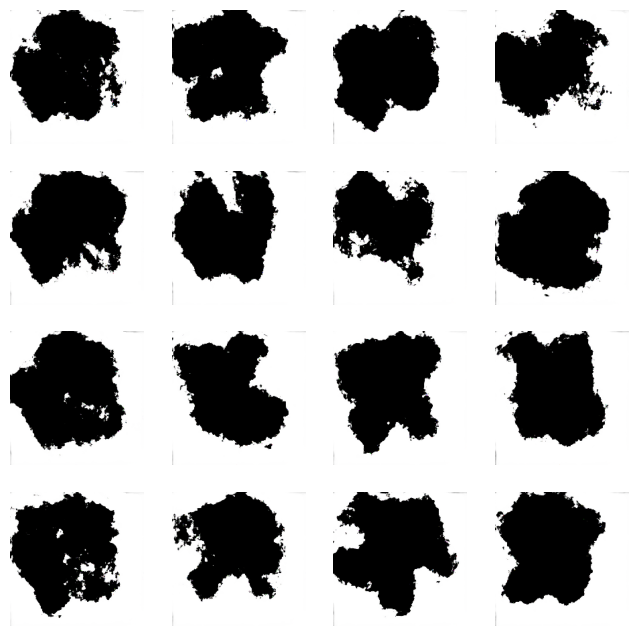

In [37]:
import matplotlib.pyplot as plt

# Generate 16 samples with a ground truth value of 0.5
samples = generate_samples(16, 1.5)

# Reshape the samples to image format and move them to CPU
samples = samples.view(-1, 3, 200, 200).cpu()

# Create a grid of images and convert them to numpy arrays
samples = samples.permute(0, 2, 3, 1).numpy()

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(samples[i])
    ax.axis('off')
plt.show()